# Aprendizaje Automatico 1

Tecnicatura Universitaria en Inteligencia Artificial

Materia: Aprendizaje Automático 1

**Trabajo Práctico 1**

**Docentes:**
- Agustín Almada
- Bruno Cocitto
- Joel Spak

**Integrantes:**

| Apellido y Nombre | Legajo   |
| --- | --- |
| Palermo, Leonel    | P-5192/6 |
| Wagner, Juan       | W-0557/6 |

Año: 2023

## Importamos la información y librerías que vamos a usar
Creamos un dataframe crudo, luego ubicamos nuestras localidades de interés y creamos un df que posea sólo esas localidades para concentrarnos en nuestro objetivo de estudio.

In [96]:
!gdown "1Xmv6uMuQr7IrmwKx4qdC_zSjYZETpi5k"

Downloading...
From: https://drive.google.com/uc?id=1Xmv6uMuQr7IrmwKx4qdC_zSjYZETpi5k
To: /content/weatherAUS.csv
100% 17.2M/17.2M [00:00<00:00, 160MB/s]


In [97]:
!head -n 5 weatherAUS.csv

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,,,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,,16.9,21.8,No,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,,,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,,,17.2,24.3,No,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,,,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,,,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,,,18.1,26.5,No,No,1.0


In [98]:
!tail -n 5 weatherAUS.csv

145454,2017-06-20,Uluru,3.5,21.8,0.0,,,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,,,9.4,20.9,No,No,0.0
145455,2017-06-21,Uluru,2.8,23.4,0.0,,,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,,,10.1,22.4,No,No,0.0
145456,2017-06-22,Uluru,3.6,25.3,0.0,,,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,,,10.9,24.5,No,No,0.0
145457,2017-06-23,Uluru,5.4,26.9,0.0,,,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,,,12.5,26.1,No,No,0.0
145458,2017-06-24,Uluru,7.8,27.0,0.0,,,SE,28.0,SSE,N,13.0,7.0,51.0,24.0,1019.4,1016.5,3.0,2.0,15.1,26.0,No,No,0.0


In [99]:
!cut -d ',' -f 1 weatherAUS.csv | sort | uniq -d

Como ningun valor de la primer columna se repite podemos usar esa columna como indice.

In [100]:
!pip install statsmodels --quiet
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import LassoCV, RidgeCV,ElasticNetCV, LinearRegression, SGDRegressor
from sklearn.metrics import explained_variance_score,max_error,mean_squared_log_error,median_absolute_error,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error, r2_score, PredictionErrorDisplay
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import plotly.express as px
import plotly.subplots as sp
import warnings
from tabulate import tabulate

np.random.seed(777)
warnings.filterwarnings("ignore")

In [101]:
df_raw=pd.read_csv('weatherAUS.csv', index_col=0)
y_target_name=['RainTomorrow','RainfallTomorrow']
df_raw.shape

(145412, 24)

In [102]:
# No hay datos faltantes en Date
df_raw["Date"].isna().any()

False

In [103]:
# Asignamos el tipo de dato adecuado a Date
df_raw["Date"]=pd.to_datetime(df_raw["Date"])

In [104]:
# Guardamos solo aquellas zonas que son consideradas de interes y las consideramos como un solo lugar, por lo que podemos luego, descartar la columna.
LOI=['Sydney','SydneyAirport','Canberra', 'Melbourne','MelbourneAirport']
print("Cantidad de Locations of Interest", len(LOI))
MASK_LOCATION=df_raw["Location"].isin(LOI)
df=df_raw[MASK_LOCATION]

Cantidad de Locations of Interest 5


## EDA

### Variables Dependiente $y$
- $y$: `RainTomorrow`,`RainfallTomorrow`
- Eliminamos aquellas filas las cuales no tengan valores en $y$ dado que es un problema de regresión y es un metodo supervisado. Necesitamos tener datos etiquetados. -> no existen valores faltantes en $y$ para las ubicaciones de interés.
- Se observa que en los días en los cuales llovió,`RainfallTomorrow` tiene valores superiores a `1`.
- Existe en desbalanceo de datos sobre la variable dependiente ~1:4
- Por último analizámos la variable dependiente a lo largo del tiempo

In [105]:
# Estamos en un problema de clasificación, no nos aporta tener variables cuyo target no este presente.
df[y_target_name].isna().sum()

RainTomorrow        787
RainfallTomorrow    787
dtype: int64

In [106]:
# vamos a borrar el ~5% de los datos (787) filas
to_be_removed=df.dropna(how="any", subset=y_target_name).shape[0]
df.shape[0]-to_be_removed, 1-to_be_removed/df.shape[0]

(787, 0.04923057675466036)

In [107]:
df.dropna(how="any", subset=y_target_name, inplace=True)

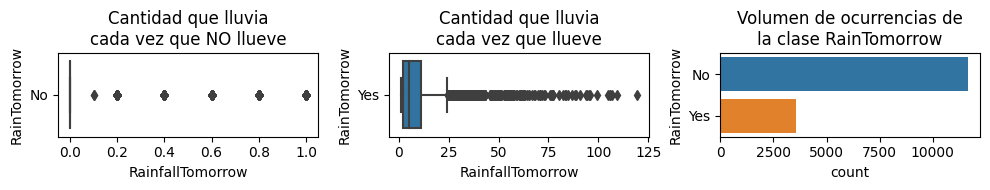

count      mean        std  min  25%  50%   75%    max
RainTomorrow                                                          
No            11643.0  0.073916   0.198571  0.0  0.0  0.0   0.0    1.0
Yes            3556.0  9.599663  12.787249  1.2  2.4  5.0  11.2  119.4

In [108]:
def plot_y(df):
  fig, axes = plt.subplots(1, 3, figsize=(10, 2))
  sns.boxplot(df[df['RainTomorrow'] == 'No'], x='RainfallTomorrow', y='RainTomorrow', ax=axes[0])
  sns.boxplot(df[df['RainTomorrow'] == 'Yes'], x='RainfallTomorrow', y='RainTomorrow', ax=axes[1])
  sns.barplot(x='count', y='RainTomorrow',ax=axes[2],
              data=df.groupby('RainTomorrow')['RainTomorrow'].count().reset_index(name='count'))

  axes[0].set_title('Cantidad que lluvia\ncada vez que NO llueve')
  axes[1].set_title('Cantidad que lluvia\ncada vez que llueve')
  axes[2].set_title("Volumen de ocurrencias de\nla clase RainTomorrow")

  plt.tight_layout()
  plt.show()

  return df.groupby("RainTomorrow")['RainfallTomorrow'].describe()
plot_y(df)

Variable dependiente $y$ a lo largo del tiempo

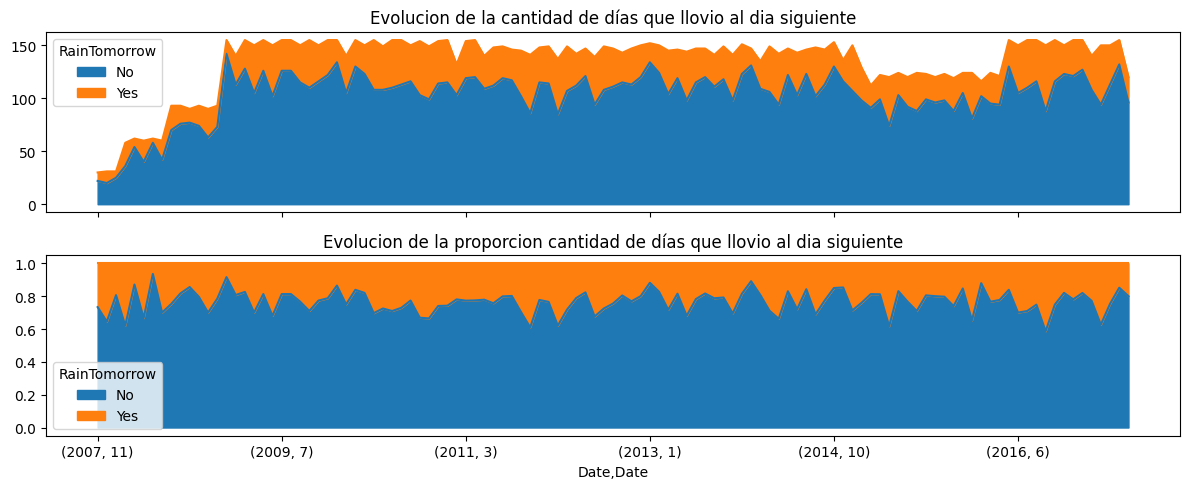

In [109]:
y_rain_evolution=df.groupby([df["Date"].dt.year, df["Date"].dt.month,'RainTomorrow'])['RainTomorrow'].count().unstack()

fig, axs = plt.subplots(2, 1, figsize=(12, 5), sharex=True)
y_rain_evolution.plot.area(ax=axs[0], title="Evolucion de la cantidad de días que llovio al dia siguiente")
y_rain_evolution.div(
    df.groupby([df["Date"].dt.year, df["Date"].dt.month])['RainTomorrow'].count(),axis=0
).plot.area(stacked=True,ax=axs[1],title="Evolucion de la proporcion cantidad de días que llovio al dia siguiente")
fig.tight_layout()

### Variables Independientes $X$
- Variables Cualitativas:
  - `Date` (Variable Temporal)
  - `Location` (**NO ESTUDIAREMOS ESTA VARIABLE**)
  - Dirección del viento: `WindGustDir`, `WindDir9am`, `WindDir3pm`
  - ¿LLueve el dia de hoy?: `RainToday`
- Variables Cuantitativas:
  - Temperatura: `MinTemp`, `MaxTemp`, `Temp3pm`, `Temp9am`
  - Velocidad del viento: `WindGustSpeed`, `WindSpeed9am`, `WindSpeed3pm`
  - Humedad: `Humidity9am`, `Humidity3pm`
  - Presion: `Pressure9am`, `Pressure3pm`
  - Nubocidad??: `Cloud9am`, `Cloud3pm`
  - `Rainfall`
  - `Evaporation`
  - `Sunshine`

#### Variables Cuantitativas

##### Variable Temporal `Date`
- Los datos observados corresponden al periodo `2007-11` - `2017-6`, practicamente 10 años.
- El grueso de datos esta concentrado a partir del año `2009`.
- Existen meses completos faltantes `2011-4`, `2012-12` y `2013-2`.
- La cantidad maxima de filas por mes que podríamos encontrar oscila entre los **140** registros para febrero y 155 para aquellos con 31 días.
- Se puede observar el comportamiento ciclico de las variables cuantitativas.

In [110]:
# cantidad de días que tiene cada mes * cantidad de ubicaciones de interes
pd.date_range(start='2010',end='2011', freq='M').to_series("Registros totales por mes").dt.day*len(LOI)

2010-01-31    155
2010-02-28    140
2010-03-31    155
2010-04-30    150
2010-05-31    155
2010-06-30    150
2010-07-31    155
2010-08-31    155
2010-09-30    150
2010-10-31    155
2010-11-30    150
2010-12-31    155
Freq: M, dtype: int64

In [111]:
# Cantidad de registros disponibles para entrenar el modelo (que tiene valores $y$)
df_by_date=df.groupby([df["Date"].dt.month, df["Date"].dt.year], dropna=False)
df_by_date["Date"].count().unstack().style.background_gradient(cmap="viridis",axis=1)

Creamos la columna "Month" para tener la selección de meses más a mano.

In [112]:
df["Month"]=pd.Categorical(df["Date"].dt.month, categories=sorted(df["Date"].dt.month.unique()), ordered=True)

Hacemos un análisis de cómo evolucionan las diferentes categorías a lo largo de los meses.

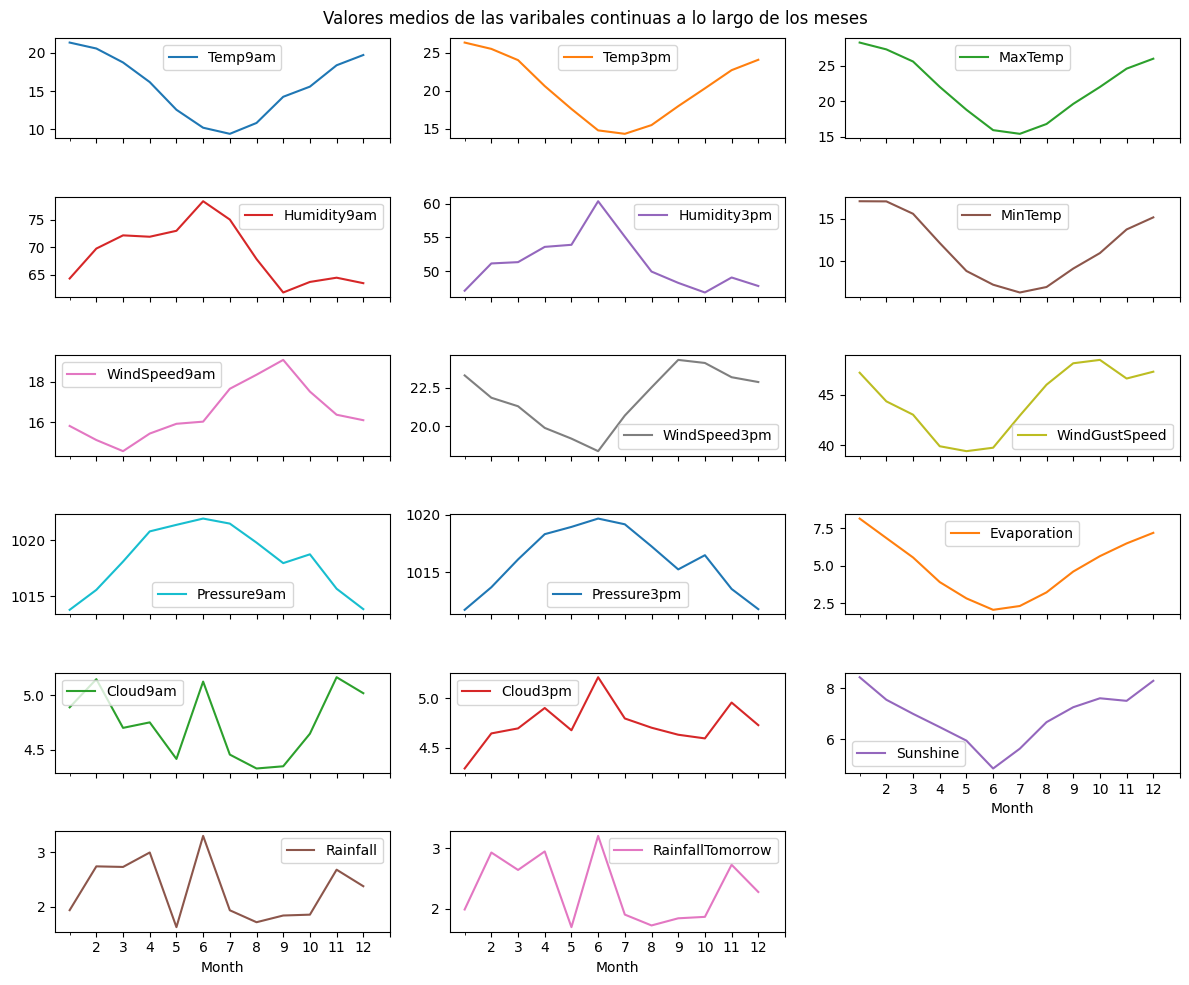

In [113]:
df.groupby(["Month"])['Temp9am', 'Temp3pm', 'MaxTemp',
'Humidity9am', 'Humidity3pm','MinTemp',
'WindSpeed9am', 'WindSpeed3pm', 'WindGustSpeed',
'Pressure9am', 'Pressure3pm','Evaporation',
'Cloud9am', 'Cloud3pm', 'Sunshine',
'Rainfall','RainfallTomorrow'].mean().plot(
    title="Valores medios de las varibales continuas a lo largo de los meses",
    sharex=True, subplots=True,layout=(-1,3), figsize=(12,10), xticks=range(1,13))
plt.tight_layout()
plt.show()

##### `RainToday`
- 1% de datos faltantes (163 registros)
- Nuestra intención era recuperar esos registros, hicimos un intento reemplazando con los valores de RainTomorrow ya que sería lo mismo pero un día anterior, pero esto no fue posible. Dado que los valores faltantes no representaban una cantidad significativa, decidimos ignorarlos.

In [114]:
def plot_cate(df_aux,cols):
  cols_sort=df_aux[cols[0]].unique()
  fig,axs=plt.subplots(1,len(cols),sharey=True, figsize=(3*len(cols),5),sharex=True)
  for i,col in enumerate(cols):
    df_aux.value_counts(subset=col,dropna=False).reindex(cols_sort).plot.barh(ax=axs[i] if len(cols)>1 else axs, title=col)
  return df_aux[cols].describe()

RainToday
count      15036
unique         2
top           No
freq       11541

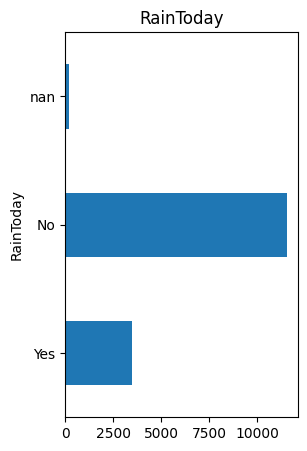

In [115]:
plot_cate(df, ["RainToday"])

In [116]:
df["RainToday"].isna().sum(), df["RainToday"].isna().sum()/df["RainToday"].count()

(163, 0.010840649108805533)

count        mean        std   min   25%    50%    75%    max
No   113.0  102.132743  23.725929  19.0  96.0  108.0  117.0  142.0
Yes  113.0   30.929204  11.386644   4.0  24.0   30.0   42.0   60.0
nan  113.0    1.442478   1.875300   0.0   0.0    0.0    3.0    7.0

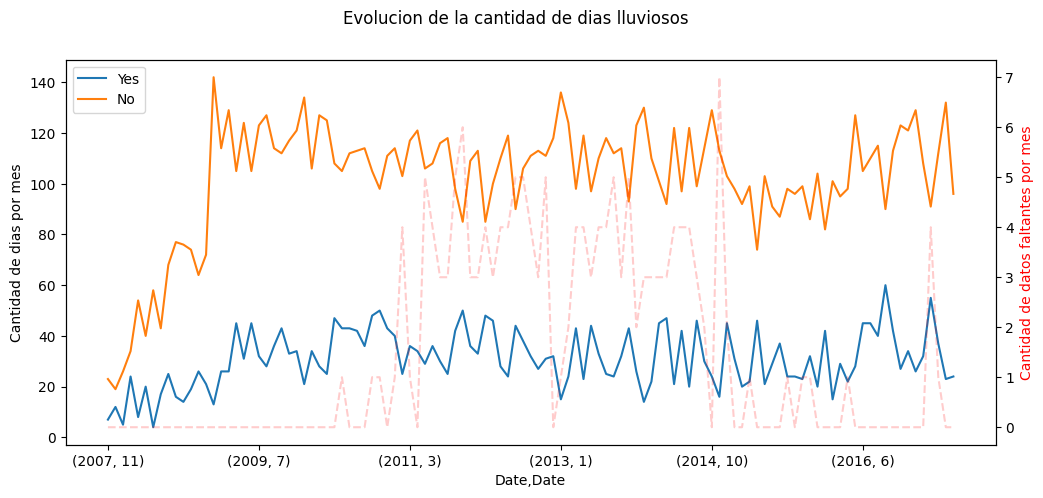

In [117]:
raintoday_na=df[["Date","RainToday"]].groupby([df["Date"].dt.year, df["Date"].dt.month,"RainToday"],dropna=False)\
.count().unstack().fillna(0)
raintoday_na.columns=raintoday_na.columns.map(lambda v: str(v[1]))

fig, ax1 = plt.subplots(figsize=(12,5))
fig.suptitle("Evolucion de la cantidad de dias lluviosos")
r_unique=df["RainToday"].unique()
raintoday_na[r_unique[~pd.isna(r_unique)]].plot(ax=ax1)
ax1.set_ylabel('Cantidad de dias por mes')
if pd.isna(r_unique).any():
  ax2 = ax1.twinx()
  raintoday_na['nan'].plot(ax=ax2, color='r', linestyle='--', alpha=0.2)
  ax2.set_ylabel('Cantidad de datos faltantes por mes', color='r')
raintoday_na.describe().T

###### Inferimos los datos faltanes
(Intento infructuoso de completar los datos faltantes de RainToday a partir de RainTomorrow - <font color="red">NO ES NECESARIO LEER ESTE APARTADO</font>)
Si sabemos que cada fila tiene información de lo que ocurre al día siguiente, podemos intentar completar los faltanes de una fila con información del día anterior.
Se encontró que no fue posible completarlo debido a que justo las filas a los días anteriores no están presentes en el dataset. 😞

In [118]:
estado_inicial=df.groupby(["Location"])["RainToday","RainTomorrow"].count()
estado_inicial

RainToday  RainTomorrow
Location                                 
Canberra               3401          3417
Melbourne              2297          2434
MelbourneAirport       3008          3008
Sydney                 3330          3336
SydneyAirport          3000          3004

In [119]:
# creamos un dataset original donde le agregamos la fecha del dia siguiente
df_aux=df.copy().assign(Date_Tomorrow=lambda x: x["Date"]+pd.Timedelta(days=1))

In [120]:
# existen diferencias lo cual nos hace pensar que podría usarse para compeltar faltantes.
df_aux[(df_aux["Location"]=="Canberra")].groupby([df_aux["Date_Tomorrow"].dt.day])["RainfallTomorrow"].sum().compare(
df_aux[(df_aux["Location"]=="Canberra")].groupby([df_aux["Date"].dt.day])["Rainfall"].sum())

self  other
5   264.8  263.6
7   142.4  135.4
20  183.0  148.2
31  126.0  118.4

In [121]:
def search_date(dt,l,df_,col):
  value_mask=(df_["Location"]==l)&(df_["Date_Tomorrow"]==dt)
  # print(l, dt)
  if not value_mask.any():
    return np.nan

  return df_[value_mask][col].values[0]


d_temp=df.copy()
for l in LOI:
  for c in ["RainToday","RainTomorrow"]:
    df_mask=(d_temp["Location"]==l)&(d_temp[c].isna())
    d_temp.loc[df_mask,c]=d_temp[df_mask]['Date'].apply(search_date, args=(l,df_aux,c))
d_temp.groupby(["Location"])["RainToday","RainTomorrow"].count().compare(estado_inicial)

Empty DataFrame
Columns: []
Index: []

In [122]:
# para nuestra desgracia encontramos que las filas correspondientes justo faltan
((df["Location"]=="Melbourne")&(df["Date"]=="2014-11-25")).any(),((df["Location"]=="Melbourne")&(df["Date"]=="2014-11-24")).any()

(True, False)

##### `WindGustDir`,	`WindDir9am`,	`WindDir3pm`
Encontramos que posee una cantidad significativa de valores faltantes:
- `WindGustDir`: 10%
- `WindDir9am`: 5%
- `WindDir3pm`: 1%

De todos modos, al analizar los valores más significativos para la predicción, encontramos que podíamos obviar estos.

In [123]:
wind_dir_cols=["WindGustDir",	"WindDir9am",	"WindDir3pm"]
df[wind_dir_cols].isna().sum()/df[wind_dir_cols].count()

WindGustDir    0.105060
WindDir9am     0.046691
WindDir3pm     0.019383
dtype: float64

WindGustDir WindDir9am WindDir3pm
count        13754      14521      14910
unique          16         16         16
top              N          N          S
freq          1983       2311       1860

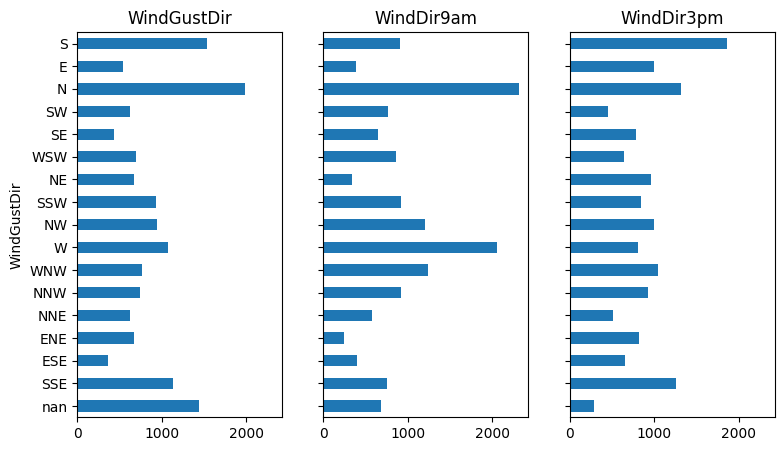

In [124]:
plot_cate(df, wind_dir_cols)

#### Variables Cuantitativas
Resumen variables relevantes a la predicción:
- $TEMPERATURA$: Dado que tenían una alta correlación decidimos seleccionar las más relevantes y usar las otras para completar valores faltantes.
- $VIENTO$: Dado que comprobamos que `WindGustSpeed` es el valor más relevante (a través de **Lasso**), usaremos valores de `WindSpeed9am`,`WindSpeed3pm` para inferir datos faltantes en `WindGustSpeed`.
- $HUMEDAD$: Los valores faltantes de esta variable eran totalmente despreciables en cuanto a la totalidad de las entradas.
- $PRESIÓN$: Al intentar recuperar los valores faltantes de presión nos encontramos con dificultades que nos llevaban a tener una predicción menos exacta, de todas maneras los valores eran pocos así que preferimos dejarlos sin tratar.
- $SOL$: En este caso los valores faltantes representaban un 15% del total, por lo cual usamos el promedio correspondiente al mismo de la entrada faltante para completar los datos, esto tomando en cuenta si coincidía con un día en el que había llovido o no.


Funciones en común que usaremos para describir las variables cuantitativas.

In [125]:
def cuanti_describe(df,cols):
  """
  Realiza un describe clasico de las variables y agrega otras filas como:
  - std_rel: desv std relativa
  - var_rel: varianza relativa
  - nan_total: cantidad de ratos faltantes
  - nan_rel: relación de datos faltantes sobre el total
  """
  aux = df[cols].describe().T
  aux["std_rel"] = aux["std"] / aux["mean"]
  aux["var_rel"] = df[cols].var() / aux["mean"]
  aux["nan_total"]=df[cols].isna().sum()
  aux["nan_rel"]=df[cols].isna().sum()/df[cols].count()
  return aux

# Función Generica para estudiar las variables cuantitativas
def plot_group(df_aux, cols:list[str], same_range=True, xscale='linear', stratified=False):
  """
  Grafica en forma simultanea un histograma y un diagrama caja y bigotes de las columnas especificadas.
  Tambien, permite estratificar estdos dos graficos por la variable cualitativa `RainToday`.
  """
  n_cols=len(cols)
  df_aux=df_aux[cols+['RainToday']]
  fig = plt.figure(figsize=(4.25*n_cols, 5))
  gs = GridSpec(nrows=2, ncols=n_cols, height_ratios=[n_cols, 1])
  axs = [fig.add_subplot(gs[i, j % n_cols]) for i in range(2) for j in range(n_cols)]

  for i, col in enumerate(cols):
    if stratified:
      df_aux[df_aux['RainToday'] == 'No'][col].plot(kind='hist', ax=axs[i], alpha=0.6, label='RainToday: No', bins=50, color='tab:orange')
      df_aux[df_aux['RainToday'] == 'Yes'][col].plot(kind='hist', ax=axs[i], alpha=0.9, label='RainToday: Yes', bins=50, color='tab:blue')
    else:
      df_aux[col].plot(kind='hist', ax=axs[i], bins=50)
    axs[i].set_title(col)
    axs[i].set_ylabel('Frecuencia')
    axs[i].legend()

    df_aux.plot.box(by='RainToday' if stratified else None, column=col, vert=False, ax=axs[i+n_cols], showmeans=True, title=None)

  if same_range:
    [ax.set_xscale(xscale) for ax in axs]
    x_min_max_lim = (0.9*df_aux.min().min(), 1.1*df_aux.max().max())
    [ax.set_xlim(*x_min_max_lim) for ax in axs]
  else:
    for j, col_name in enumerate(df_aux):
      [axs[n_cols * i + j].set_xscale(xscale) for i in range(2)]
      x_min_max_lim = (0.9*df_aux[col_name].min().min(), 1.1*df_aux[col_name].max().max())
      [axs[n_cols * i + j].set_xlim(*x_min_max_lim) for i in range(2)]

  fig.tight_layout()
  fig.show()

def plot_mean_evol(df, cols:list[str], title:str, ylabel:str):
  """
  Grafica la evolucion temporal en forma simultanea de las columas listadas.
  """
  aux_groupped=df[["Date"]+cols].groupby([df["Date"].dt.year, df["Date"].dt.month]).mean()
  aux_groupped.plot(figsize=(12,5), title=title)
  plt.ylabel(ylabel)
  plt.xlabel('Date')
  plt.tight_layout()
  plt.show()
  return aux_groupped.describe().T

##### `MinTemp`,`MaxTemp`,`Temp9am`,`Temp3pm`
- Todas tienen un comportamiento normal.
- Se completan datos faltantes vinculando las minimas temperaturas con las de las 9 AM y las maximas con las de 3 PM

In [126]:
temp_cols=['MinTemp','Temp9am','Temp3pm','MaxTemp']
cuanti_describe(df,temp_cols)

count       mean       std  min   25%   50%   75%   max   std_rel  \
MinTemp  15189.0  11.606057  5.877294 -8.0   7.9  11.6  15.9  30.5  0.506399   
Temp9am  15175.0  15.570662  5.570913 -1.3  11.6  15.4  19.6  37.2  0.357783   
Temp3pm  15183.0  20.260304  5.858891  3.7  16.0  19.8  24.2  46.1  0.289181   
MaxTemp  15193.0  21.784203  6.055148  4.1  17.2  21.3  25.8  46.8  0.277961   

          var_rel  nan_total   nan_rel  
MinTemp  2.976255         10  0.000658  
Temp9am  1.993176         24  0.001582  
Temp3pm  1.694279         16  0.001054  
MaxTemp  1.683092          6  0.000395

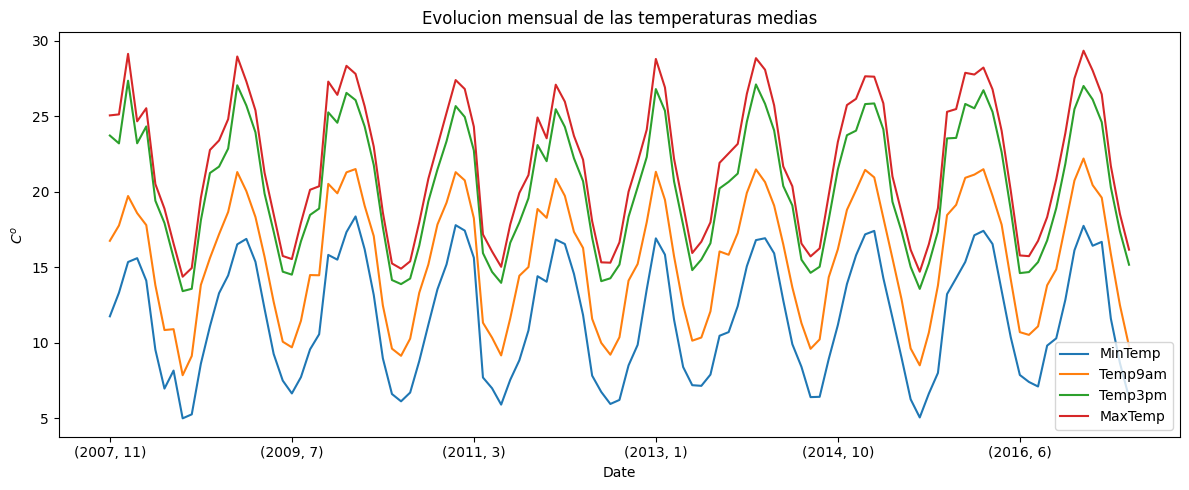

count       mean       std        min        25%        50%  \
MinTemp  113.0  11.619841  3.934895   5.000000   7.895918  11.532414   
Temp9am  113.0  15.595533  4.097724   7.854839  11.586395  15.827517   
Temp3pm  113.0  20.356720  4.237532  13.419355  16.624161  20.380282   
MaxTemp  113.0  21.876116  4.497718  14.375269  17.974830  21.965306   

               75%        max  
MinTemp  15.359355  18.364748  
Temp9am  19.132773  22.198065  
Temp3pm  24.129508  27.348387  
MaxTemp  25.737500  29.334839

In [127]:
plot_mean_evol(df, cols=temp_cols,title="Evolucion mensual de las temperaturas medias", ylabel="$C^o$")

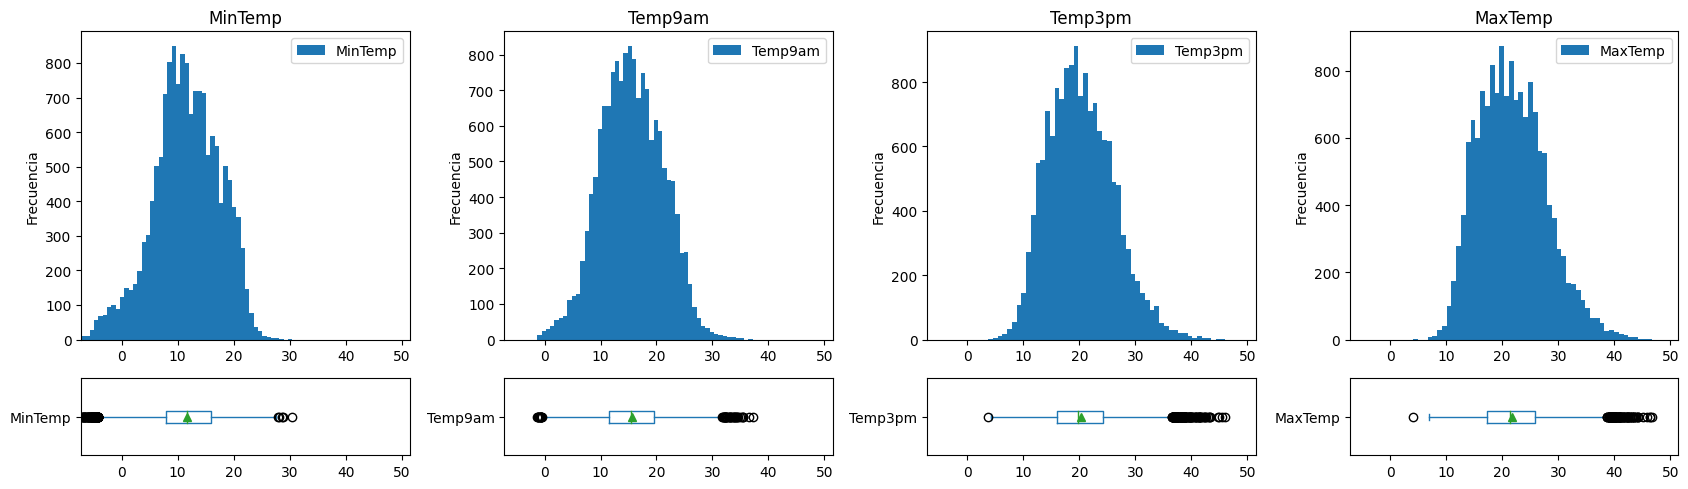

In [128]:
plot_group(df,temp_cols)

Observamos la correlatividad de las variables de temperatura, en base a esto empezamos a vislumbrar que podríamos reducir algunas de estas variables en favor de otras.

In [129]:
df[temp_cols].corr().style.background_gradient(cmap="viridis", axis=None, vmin=0)

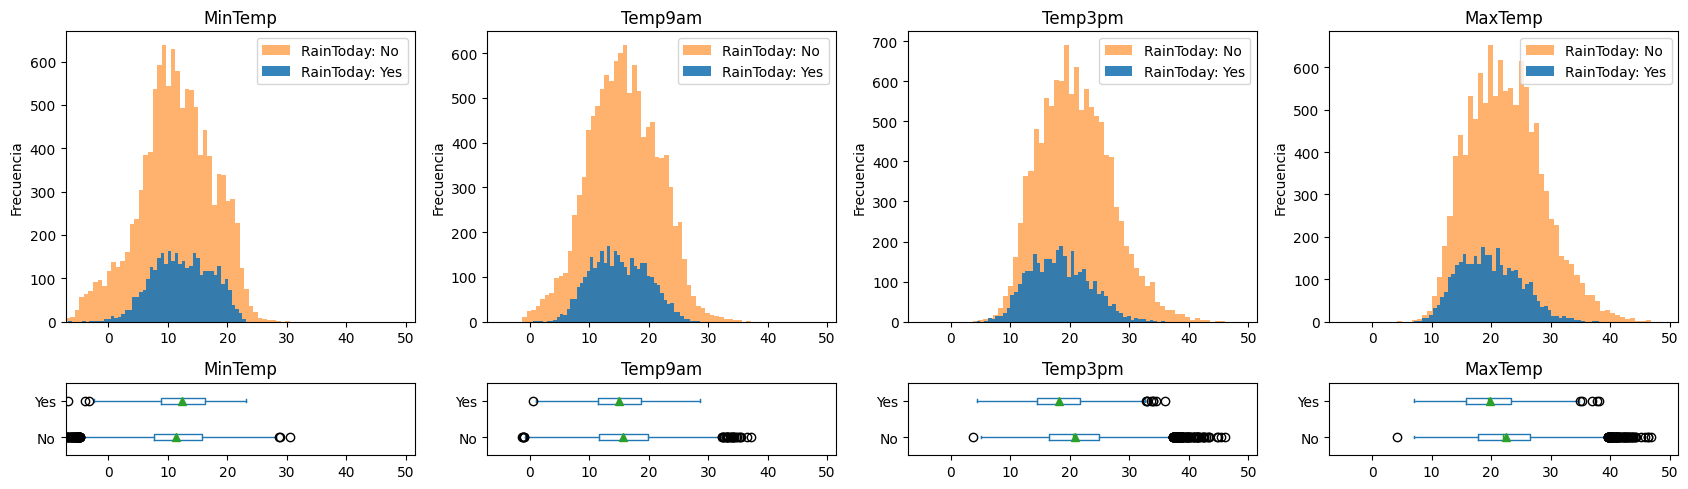

In [130]:
_=plot_group(df,temp_cols,stratified=True)

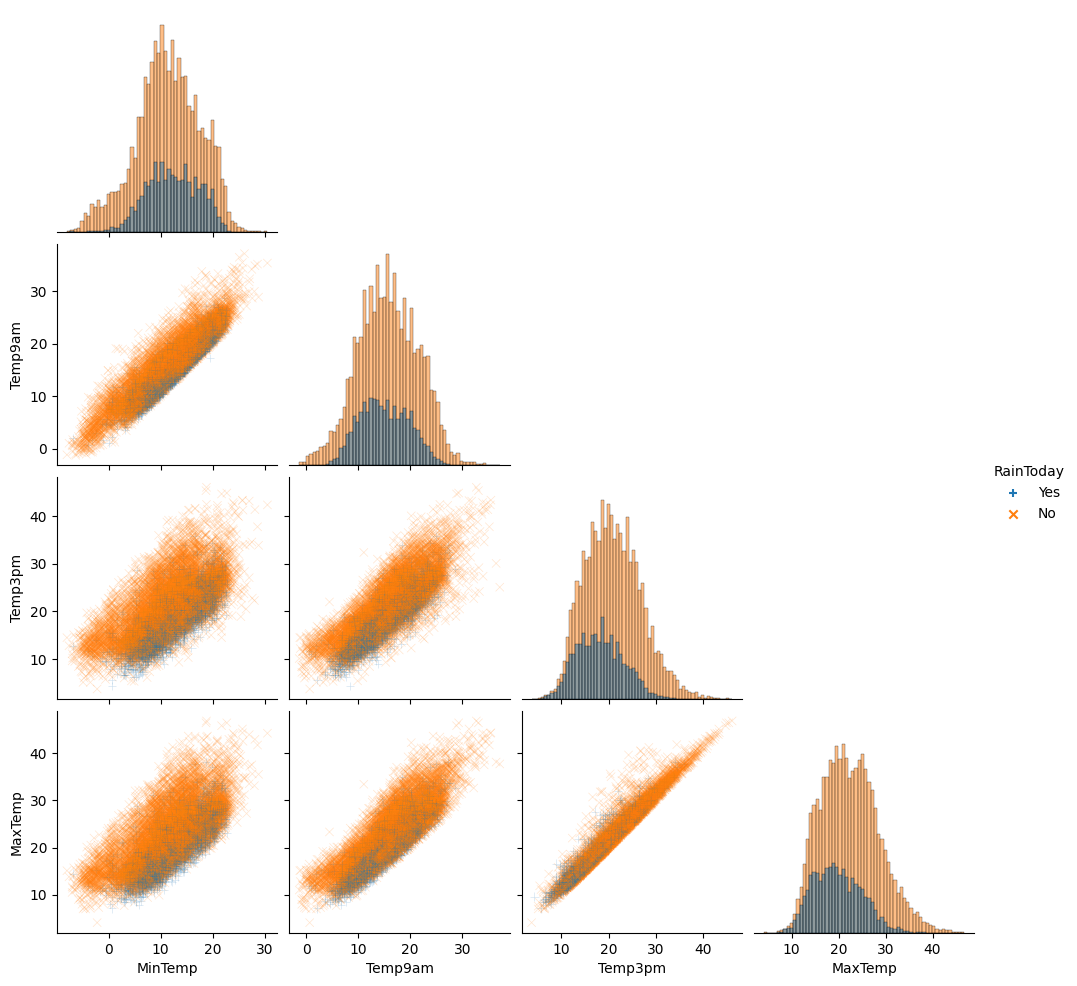

In [131]:
sns.pairplot(data=df,vars=temp_cols,diag_kind="hist", hue="RainToday", corner=True,markers=["+","x"], plot_kws={'alpha': 0.2})

In [132]:
df.groupby("RainToday")[temp_cols].corr().style.background_gradient(cmap="viridis", axis=None, vmin=0)

##### `WindGustSpeed`,`WindSpeed9am`,`WindSpeed3pm`
- Todas tienen un comportamiento normal.
- Faltan el 10% de los datos de `WindGustSpeed`
- Dado que comprobamos que `WindGustSpeed` es el valor más relevante (a través de **Lasso**), usaremos valores de `WindSpeed9am`,`WindSpeed3pm` para inferir datos faltantes en `WindGustSpeed`.

In [134]:
wind_cols=['WindGustSpeed','WindSpeed9am','WindSpeed3pm']
cuanti_describe(df,wind_cols)

count       mean        std   min   25%   50%   75%    max  \
WindGustSpeed  13756.0  44.323786  14.952565  11.0  33.0  43.0  54.0  122.0   
WindSpeed9am   14939.0  16.479617  10.282170   0.0   9.0  15.0  22.0   69.0   
WindSpeed3pm   14950.0  21.746622   9.529054   0.0  15.0  20.0  28.0   76.0   

                std_rel   var_rel  nan_total   nan_rel  
WindGustSpeed  0.337349  5.044226       1443  0.104900  
WindSpeed9am   0.623933  6.415381        260  0.017404  
WindSpeed3pm   0.438185  4.175493        249  0.016656

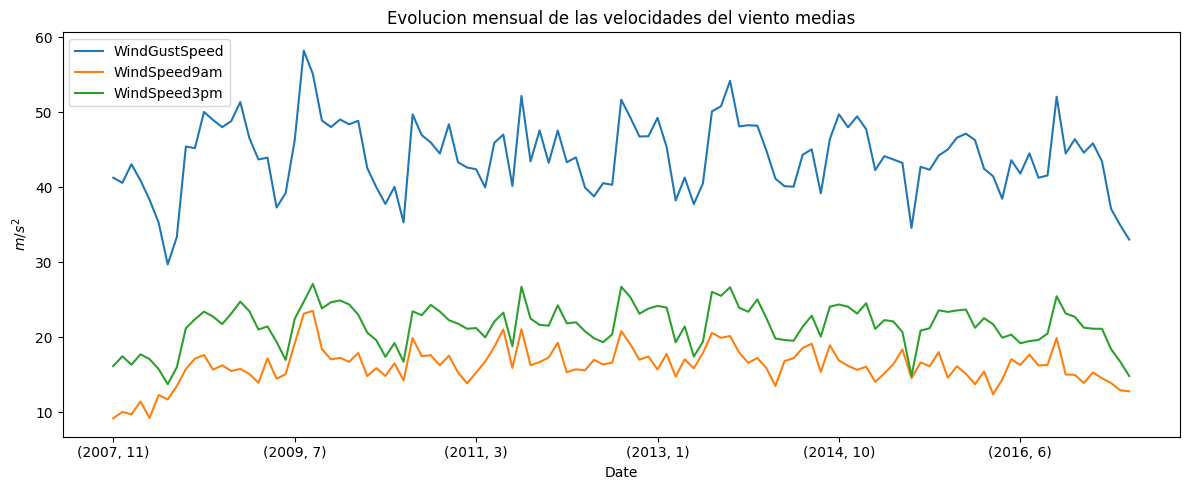

count       mean       std        min        25%        50%  \
WindGustSpeed  113.0  44.152689  4.890630  29.700000  40.896552  44.222222   
WindSpeed9am   113.0  16.204235  2.512457   9.166667  15.013333  16.241611   
WindSpeed3pm   113.0  21.531589  2.815200  13.725806  19.812081  21.738636   

                     75%        max  
WindGustSpeed  47.740157  58.206522  
WindSpeed9am   17.468531  23.504202  
WindSpeed3pm   23.457143  27.100000

In [135]:
plot_mean_evol(df, cols=wind_cols,title="Evolucion mensual de las velocidades del viento medias", ylabel="$m/s^2$")

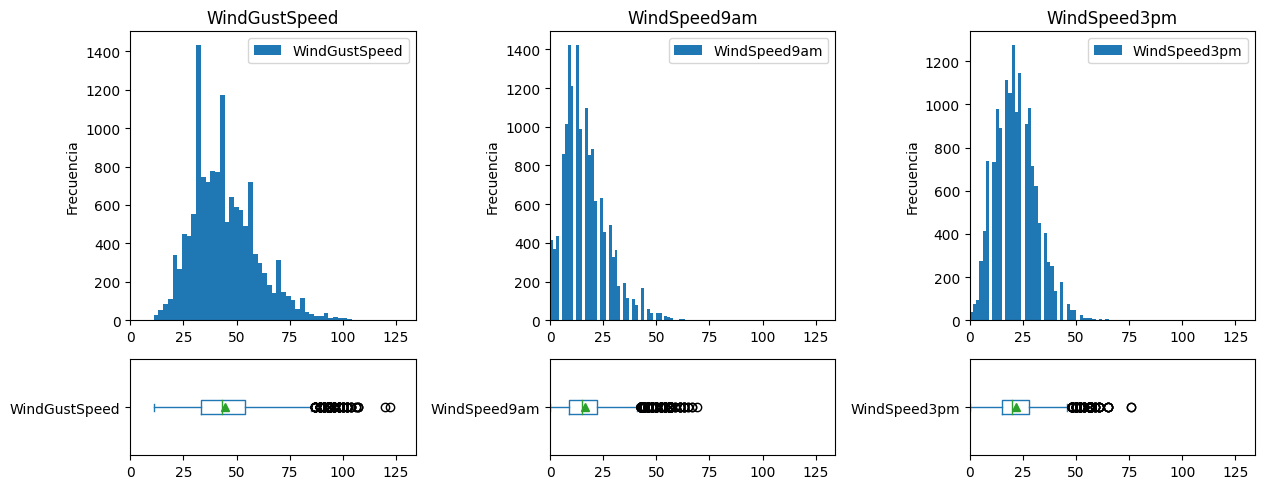

In [136]:
plot_group(df,wind_cols)

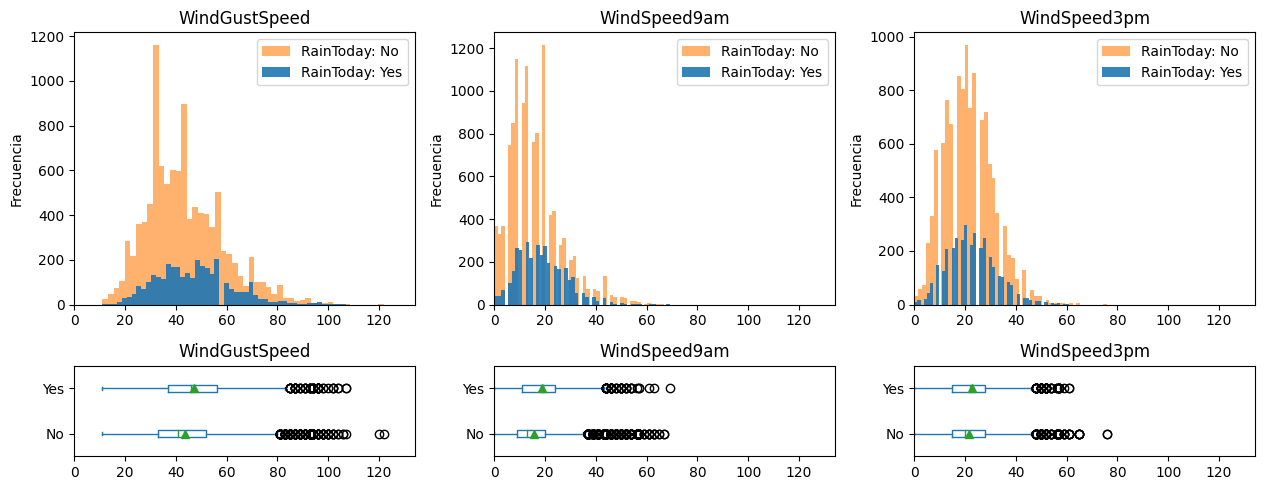

In [137]:
plot_group(df,wind_cols,stratified=True)

In [138]:
df['WindGustSpeed'].fillna(df[['WindSpeed9am','WindSpeed3pm']].max(axis=1), inplace=True)

##### `Humidity9am`,`Humidity3pm`

In [139]:
humidity_cols=['Humidity9am','Humidity3pm']
cuanti_describe(df,humidity_cols)

count       mean        std   min   25%   50%   75%    max  \
Humidity9am  15111.0  68.884918  15.645965  11.0  59.0  70.0  80.0  100.0   
Humidity3pm  15154.0  51.238683  17.735612   3.0  39.0  51.0  62.0  100.0   

              std_rel   var_rel  nan_total   nan_rel  
Humidity9am  0.227132  3.553698         88  0.005824  
Humidity3pm  0.346137  6.138955         45  0.002970

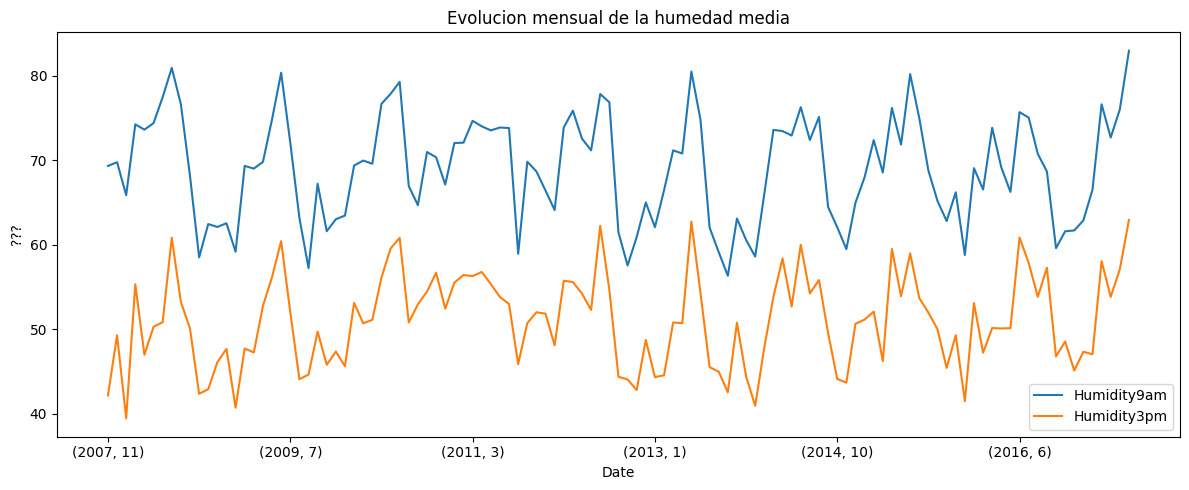

count       mean       std        min        25%        50%  \
Humidity9am  113.0  69.032917  6.261801  56.335570  63.461039  69.335714   
Humidity3pm  113.0  51.055736  5.491511  39.451613  46.983871  50.806897   

                   75%        max  
Humidity9am  73.882759  82.975000  
Humidity3pm  54.671141  62.941667

In [140]:
plot_mean_evol(df, cols=humidity_cols,
  title="Evolucion mensual de la humedad media", ylabel="???")

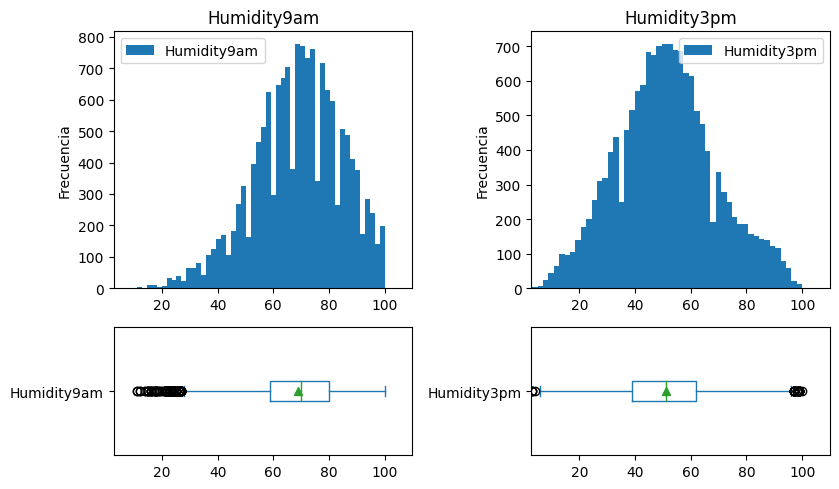

In [141]:
plot_group(df,humidity_cols)

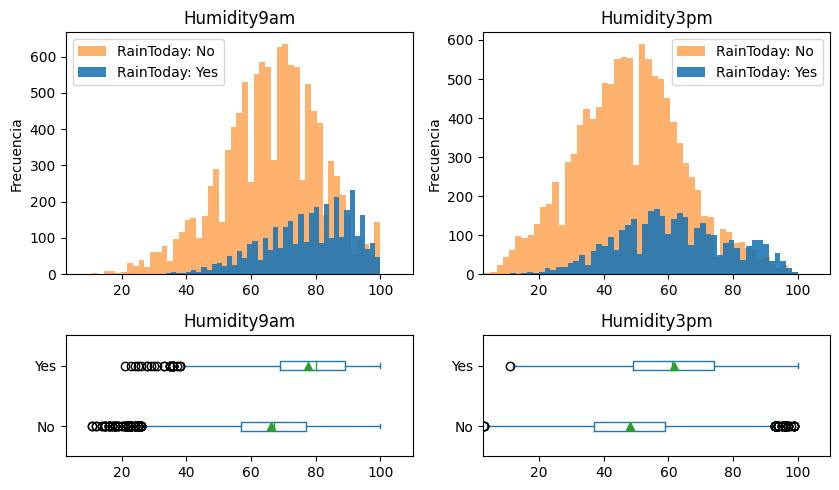

In [142]:
plot_group(df,humidity_cols,stratified=True)

##### `Pressure9am`,`Pressure3pm`
- Se intento recuperar los datos faltantes pero se observó que el modelo es muy sensible a la presión.

In [143]:
pressure_cols=['Pressure9am','Pressure3pm']
cuanti_describe(df,pressure_cols)

count         mean       std    min     25%     50%     75%  \
Pressure9am  14946.0  1018.334022  7.398337  986.7  1013.4  1018.5  1023.3   
Pressure3pm  14954.0  1016.079898  7.264708  985.5  1011.2  1016.3  1021.0   

                max   std_rel   var_rel  nan_total   nan_rel  
Pressure9am  1040.6  0.007265  0.053750        253  0.016928  
Pressure3pm  1037.9  0.007150  0.051941        245  0.016384

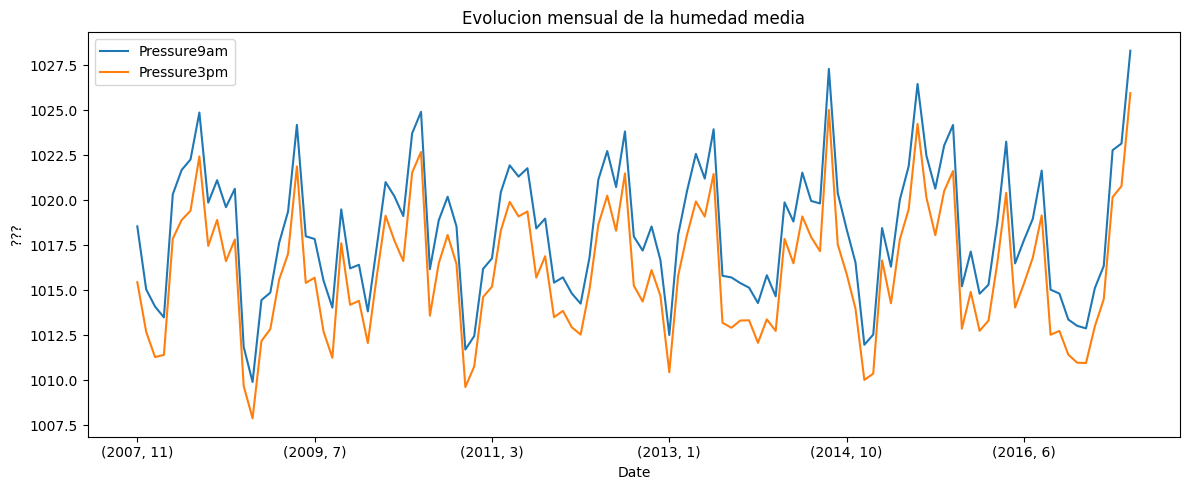

count         mean       std          min          25%  \
Pressure9am  113.0  1018.336113  3.718494  1009.908602  1015.402685   
Pressure3pm  113.0  1016.059822  3.616000  1007.888172  1013.198639   

                     50%          75%          max  
Pressure9am  1018.437671  1021.009091  1028.305833  
Pressure3pm  1015.809333  1018.655634  1025.951667

In [144]:
plot_mean_evol(df, cols=pressure_cols,title="Evolucion mensual de la humedad media", ylabel="???")

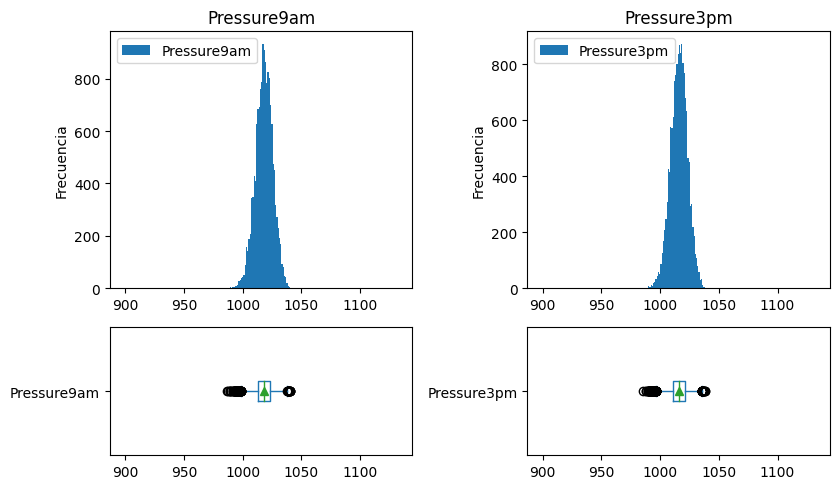

In [145]:
plot_group(df,pressure_cols)

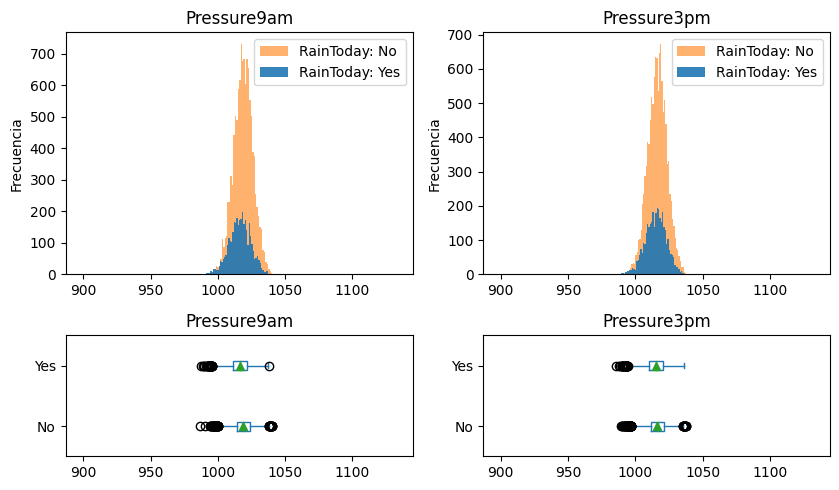

In [146]:
plot_group(df,pressure_cols,stratified=True)

###### Intento de completado de datos 😞
Se busco la estrategia de conocer como es la presion a las 9 AM y a las 3 PM, en funcion de los dias lluviosos a lo largo de los meses, sin embargo, al completar los datos faltantes el modelo terminaba teniendo peores metricas.

In [147]:
df_press=df.copy()
pressure_9am_groupped=df_press.groupby(["Month","RainToday"])['Pressure9am'].mean()
pressure_3pm_groupped=df_press.groupby(["Month","RainToday"])['Pressure3pm'].mean()
distancias_presion_9am_a_3pm=pressure_9am_groupped.sub(pressure_3pm_groupped).unstack()
distancias_presion_9am_a_3pm

RainToday        No       Yes
Month                        
1          2.305842  0.852743
2          2.118246  1.064583
3          2.157239  1.408989
4          2.768015  1.700647
5          2.701969  1.297656
6          2.540435  1.580110
7          2.666777  1.240825
8          2.879390  1.346540
9          3.113397  1.250963
10         2.773756  0.681753
11         2.528153  1.007939
12         2.341821  1.111550

In [148]:
mask_fill_pre=(~df_press['Pressure9am'].isna())&(df_press['Pressure3pm'].isna())
for c in ["Yes","No"]:
  mask=mask_fill_pre&(df_press['RainToday']==c)
  df_press.loc[mask,'Pressure3pm']=df_press[mask].apply(lambda s: s["Pressure9am"]-distancias_presion_9am_a_3pm.loc[s["Month"],c],axis=1)

mask_fill_pre=(df_press['Pressure9am'].isna())&(~df_press['Pressure3pm'].isna())
for c in ["Yes","No"]:
  mask=mask_fill_pre&(df_press['RainToday']==c)
  df_press.loc[mask,'Pressure9am']=df_press[mask].apply(lambda s: s["Pressure3pm"]+distancias_presion_9am_a_3pm.loc[s["Month"],c],axis=1)

mask_fill_pre=(df_press['Pressure9am'].isna())&(df_press['Pressure3pm'].isna())
for c in ["Yes","No"]:
  mask=mask_fill_pre&(df_press['RainToday']==c)
  df_press.loc[mask,'Pressure9am']=df_press[mask].apply(lambda s: pressure_9am_groupped.loc[s["Month"],c],axis=1)
  df_press.loc[mask,'Pressure3pm']=df_press[mask].apply(lambda s: pressure_3pm_groupped.loc[s["Month"],c],axis=1)

In [149]:
cuanti_describe(df_press,pressure_cols)

count         mean       std    min     25%     50%     75%  \
Pressure9am  15198.0  1018.307378  7.352039  986.7  1013.5  1018.5  1023.2   
Pressure3pm  15198.0  1016.054928  7.217455  985.5  1011.3  1016.2  1021.0   

                max   std_rel   var_rel  nan_total   nan_rel  
Pressure9am  1040.6  0.007220  0.053081          1  0.000066  
Pressure3pm  1037.9  0.007103  0.051269          1  0.000066

##### `Cloud9am`,`Cloud3pm`
- Faltan ~16% de los datos de `Cloud9am`,`Cloud3pm`

In [150]:
cloud_cols=['Cloud9am','Cloud3pm']
cuanti_describe(df,cloud_cols)

count      mean       std  min  25%  50%  75%  max   std_rel  \
Cloud9am  13158.0  4.738486  2.731410  0.0  2.0  6.0  7.0  9.0  0.576431   
Cloud3pm  12917.0  4.735852  2.593568  0.0  2.0  6.0  7.0  8.0  0.547646   

           var_rel  nan_total   nan_rel  
Cloud9am  1.574469       2041  0.155115  
Cloud3pm  1.420356       2282  0.176666

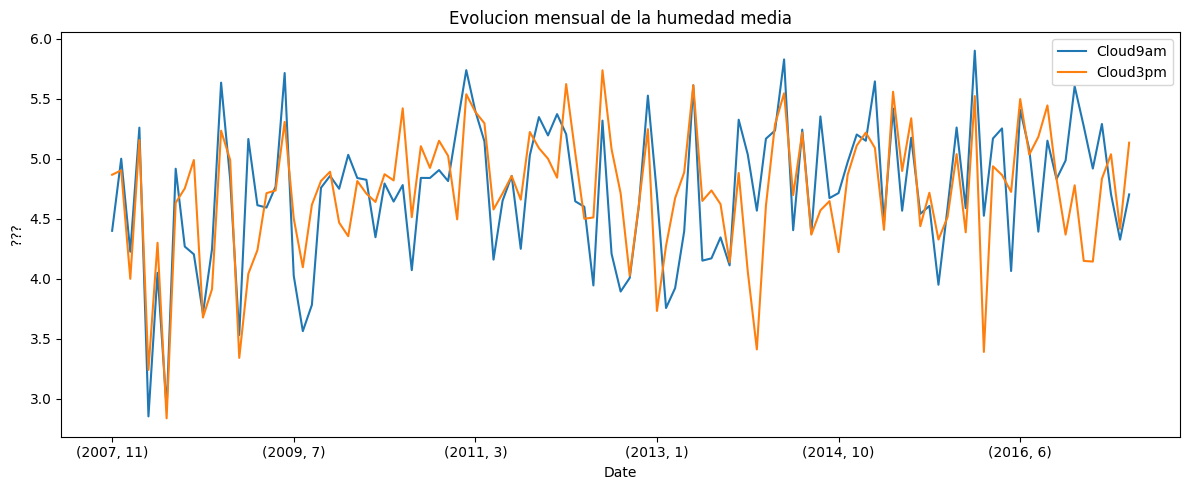

count      mean       std       min       25%       50%       75%  \
Cloud9am  113.0  4.730324  0.584255  2.854839  4.346667  4.767742  5.174757   
Cloud3pm  113.0  4.720414  0.534223  2.838710  4.467742  4.752688  5.079365   

               max  
Cloud9am  5.899083  
Cloud3pm  5.736264

In [151]:
plot_mean_evol(df, cols=cloud_cols,
  title="Evolucion mensual de la humedad media", ylabel="???")

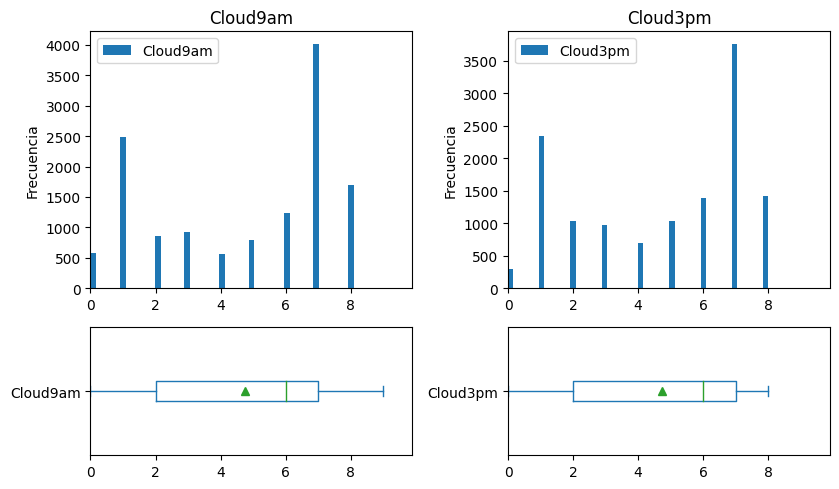

In [152]:
plot_group(df,cloud_cols)

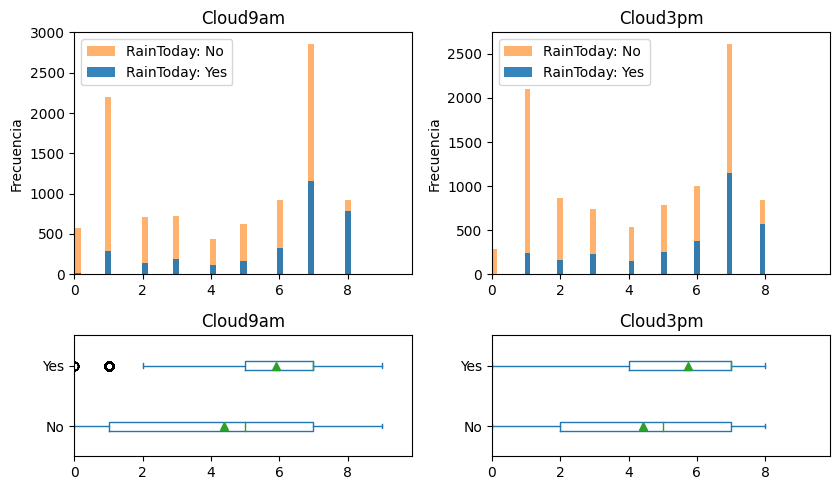

In [153]:
plot_group(df,cloud_cols,stratified=True)

##### `Rainfall`

In [154]:
rainfall_cols=['Rainfall']
cuanti_describe(df,rainfall_cols)

count      mean       std  min  25%  50%  75%    max   std_rel  \
Rainfall  15036.0  2.299601  7.404618  0.0  0.0  0.0  0.8  119.4  3.219958   

            var_rel  nan_total   nan_rel  
Rainfall  23.842557        163  0.010841

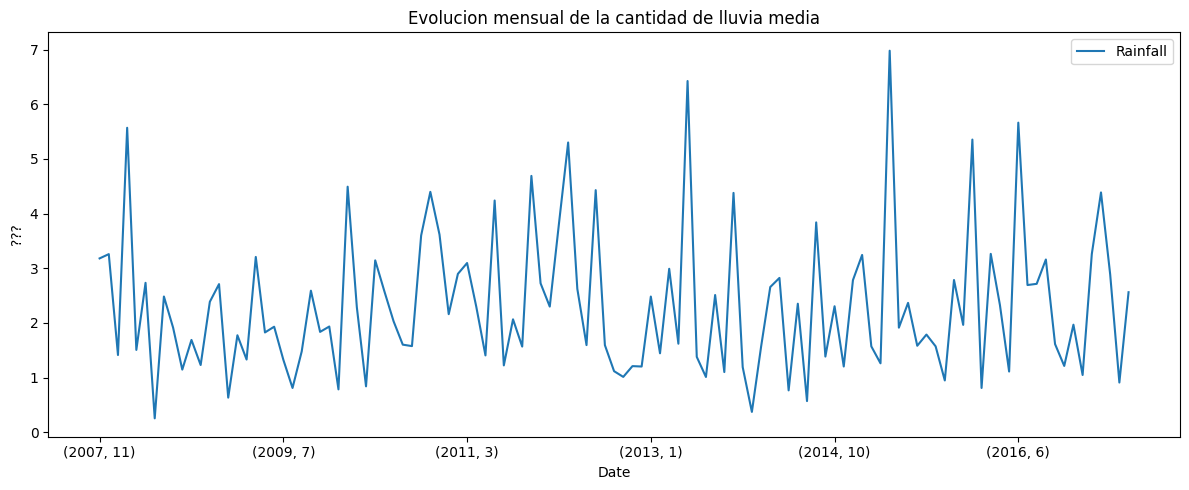

count      mean       std       min       25%       50%       75%  \
Rainfall  113.0  2.316036  1.314149  0.254839  1.379021  1.967742  2.887248   

               max  
Rainfall  6.978333

In [155]:
plot_mean_evol(df, cols=rainfall_cols,title="Evolucion mensual de la cantidad de lluvia media", ylabel="???")

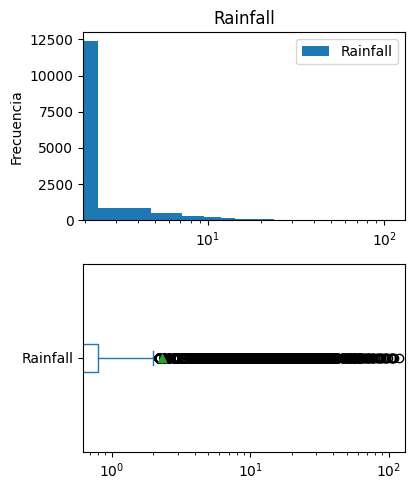

In [156]:
plot_group(df,rainfall_cols,  xscale='log')

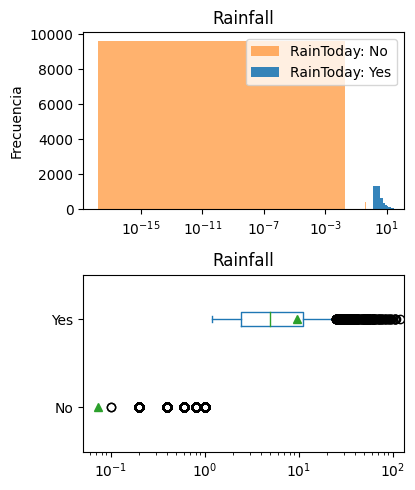

In [157]:
plot_group(df,rainfall_cols,stratified=True,  xscale='log')

##### `Evaporation`
- Falta el 12% de los datos de evaporacion

In [158]:
evaporation_cols=['Evaporation']
cuanti_describe(df,evaporation_cols)

count      mean       std  min  25%  50%  75%   max   std_rel  \
Evaporation  13505.0  4.869108  3.057514  0.0  2.6  4.2  6.6  23.8  0.627941   

             var_rel  nan_total   nan_rel  
Evaporation  1.91994       1694  0.125435

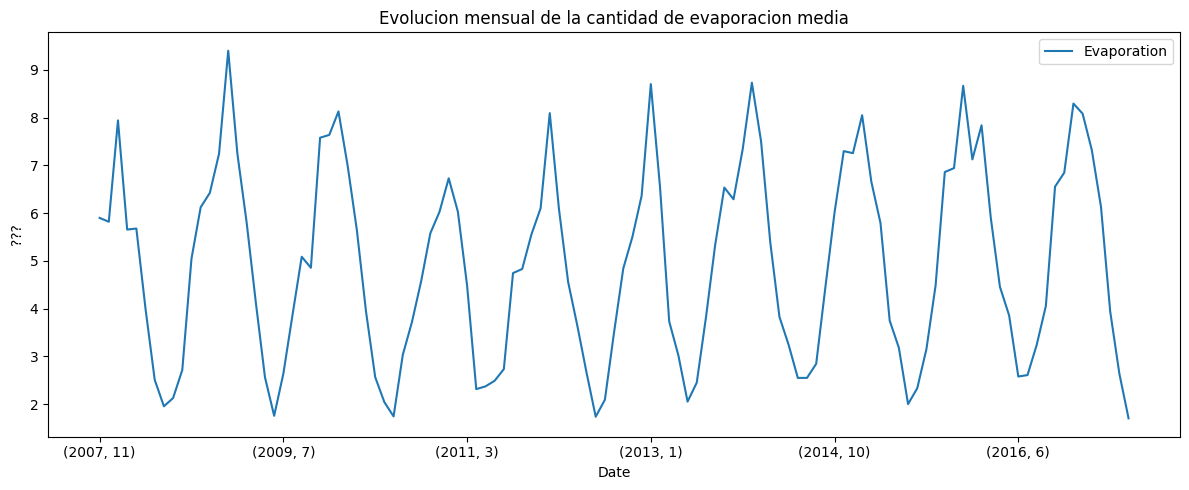

count    mean       std       min       25%       50%       75%  \
Evaporation  113.0  4.9181  2.052668  1.704167  3.022069  4.840441  6.549664   

             max  
Evaporation  9.4

In [159]:
plot_mean_evol(df, cols=evaporation_cols,title="Evolucion mensual de la cantidad de evaporacion media", ylabel="???")

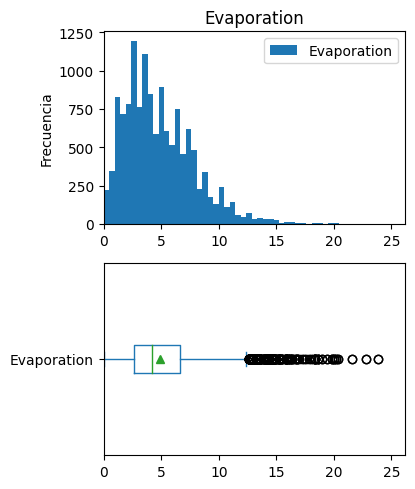

In [160]:
plot_group(df,evaporation_cols)

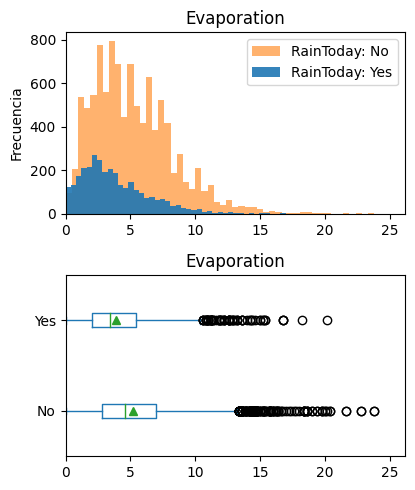

In [161]:
plot_group(df,evaporation_cols,stratified=True)

##### `Sunshine`
- Se completan la totalidad de los valores falantes sobre esta variable que representaban  el 15%.

In [162]:
sunshine_cols=['Sunshine']
cuanti_describe(df,sunshine_cols)

count     mean       std  min  25%  50%   75%   max   std_rel  \
Sunshine  13260.0  6.89727  3.836702  0.0  3.8  7.6  10.0  13.9  0.556264   

           var_rel  nan_total   nan_rel  
Sunshine  2.134219       1939  0.146229

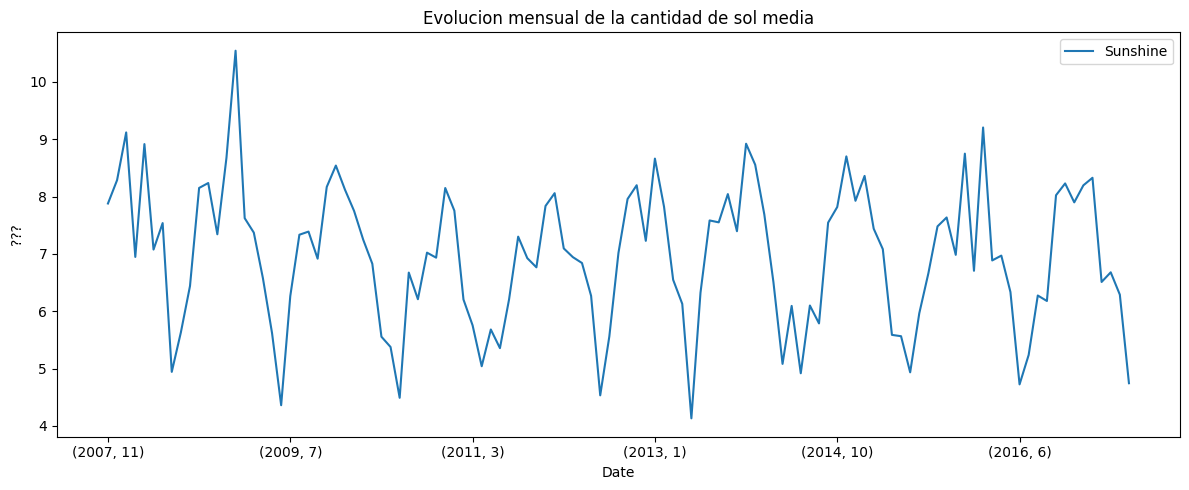

count      mean       std       min       25%       50%   75%  \
Sunshine  113.0  6.960903  1.230447  4.133333  6.205385  6.985057  7.88   

                max  
Sunshine  10.544516

In [163]:
plot_mean_evol(df, cols=sunshine_cols,title="Evolucion mensual de la cantidad de sol media", ylabel="???")

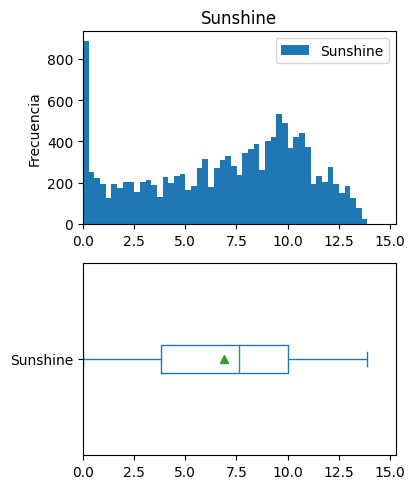

In [164]:
plot_group(df,sunshine_cols)

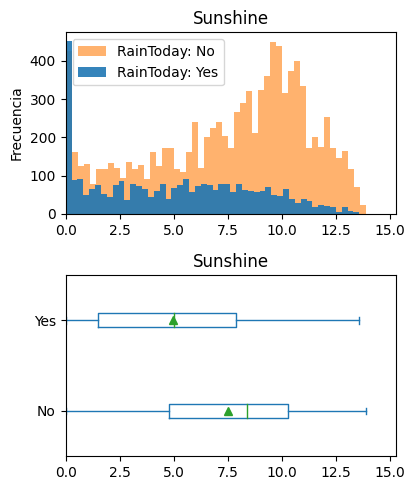

In [165]:
plot_group(df,sunshine_cols,stratified=True)

###### Completamos datos falantes en Sunshine
Podemos observar que para determinar la cantidad de sol era importante conocer si habia o no llovido y el mes en el que se encontraba. En funcion de esos dos parametros, completados los datos faltantes.

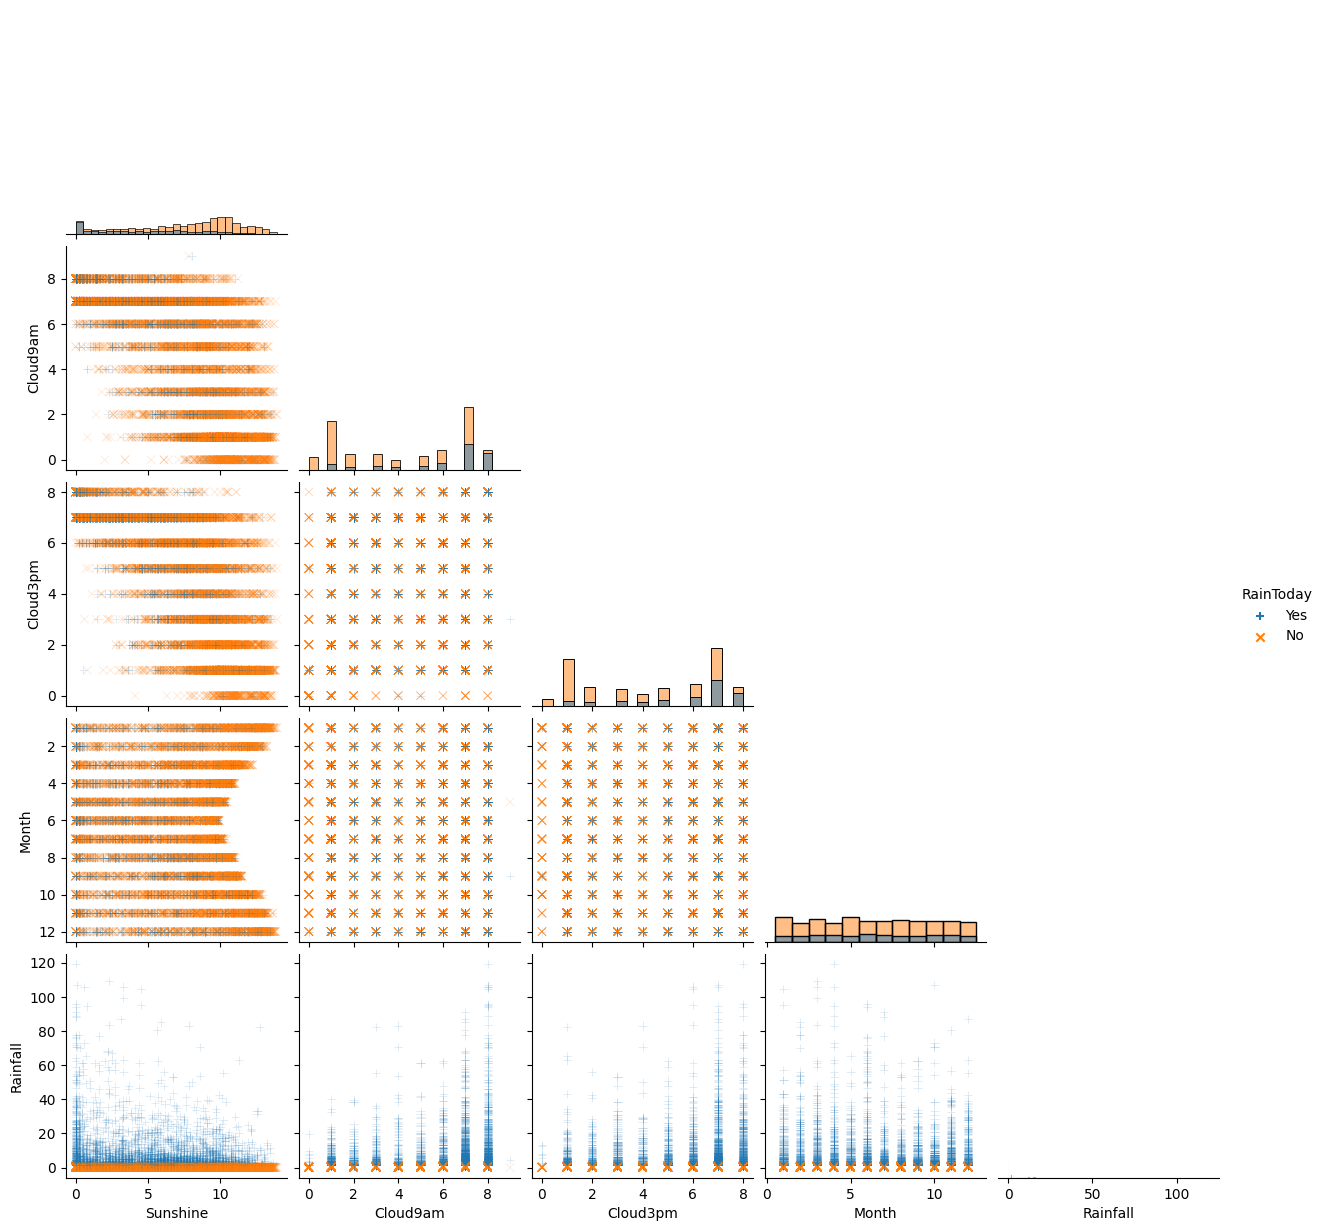

In [166]:
sns.pairplot(data=df,vars=sunshine_cols+cloud_cols+["Month","Rainfall"],diag_kind="hist", hue="RainToday", corner=True,markers=["+","x"], plot_kws={'alpha': 0.2})

In [167]:
promedio_sunshine_rain_yes = df[df["RainToday"] == "Yes"].groupby(df["Date"].dt.month)["Sunshine"].mean()
promedio_sunshine_rain_no = df[df["RainToday"] == "No"].groupby(df["Date"].dt.month)["Sunshine"].mean()

for index, row in df.iterrows():
    if pd.isna(row["Sunshine"]):
        mes = row["Date"].month
        if row["RainToday"] == "Yes":
            promedio_mes = promedio_sunshine_rain_yes.get(mes)
        elif row["RainToday"] == "No":
            promedio_mes = promedio_sunshine_rain_no.get(mes)
        if promedio_mes is not None:
            df.at[index, "Sunshine"] = promedio_mes

cuanti_describe(df,sunshine_cols)

count      mean       std  min  25%  50%  75%   max   std_rel  \
Sunshine  15199.0  6.932003  3.620907  0.0  4.4  7.6  9.7  13.9  0.522346   

           var_rel  nan_total  nan_rel  
Sunshine  1.891368          0      0.0

### Valores Faltantes en $X$
Luego de haber explorado las variables independientes, y tratado de completar los valores falantes con alguna estrategia, este es el resultado final de los mismos.

In [168]:
"""
Proporcion de datos faltantes entre los datos existentes por mes:
Muestra la cantidad relativa de datos faltantes sobre el total de datos totales
que deberia haber en funcion de la cantidad de filas presentes en ese mes.
Ej:
 - No existen datos faltantes en Novimebre y Diciembre de 2007, es decir, todas
    las filas estan completas con datos.
 - De la cantidad de filas existentes en Enero del 2010, la cantidad de datos
    faltantes corresponde al 9% del total.
 - el `nan` corresponde a lo no existencia de filas en el dataset para el mes y
    año correspondiente, es decir, no existen datos de abril 2011, diciembre 2012
    y febrero 2013 en el dataset.
"""
df_by_date=df.groupby([df["Date"].dt.month, df["Date"].dt.year], dropna=False)
(1-df_by_date.count().sum(axis=1).div(df_by_date["Date"].count()*df.shape[1]))\
.unstack().style.background_gradient(cmap="viridis",axis=None)

In [169]:
# Validamos algunos datos sean verdaderos - en 2007, Nov y Dic no hay datos faltantes
df[(df["Date"].dt.year==2007)].isna().any(axis=None)

False

In [170]:
r_loi=df_by_date.count().sub(df_by_date["Date"].count(), axis=0).abs()
r_loi['date'] = r_loi.index.map(lambda x: f"{x[1]}-{x[0]}")
r_loi.set_index('date', inplace=True)
fig=px.bar(r_loi)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Total")
fig.update_layout(barmode="stack",
    title_text="Cantidad de valores faltantes por variable explicativa a lo largo del tiempo")
fig.show()

<Axes: title={'center': 'Comparativa de la proporción de datos faltantes totales por cada variable explicativa'}>

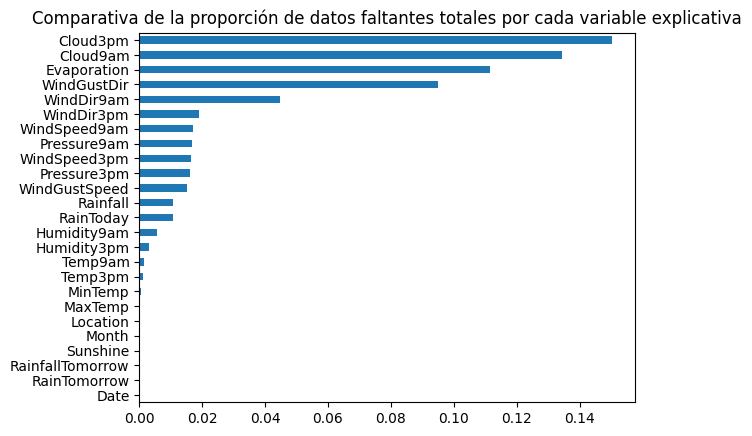

In [171]:
(df.isna().sum(axis=0).sort_values()/df.shape[0]).plot.barh(
    title="Comparativa de la proporción de datos faltantes totales por cada variable explicativa")

In [172]:
"""
Proporcion de valores faltantes por location por variable explicativa:
ej:
- Canberra tiene falante el 46% de los datos de evaporación.
"""
na_list=df.isna().sum(axis=0).sort_values(ascending=False).index.to_list()
na_matrix=(1-(df.groupby("Location", dropna=False).count().div(df.groupby("Location", dropna=False)["Location"].count(), axis=0))
).sort_values(by=na_list, ascending=False).reindex(columns=na_list)
na_matrix.style.background_gradient(cmap="viridis", axis=None)

In [173]:
fig=px.bar(na_matrix)
fig.update_xaxes(title_text="Date")
fig.update_yaxes(title_text="Total")
fig.update_layout(
    title_text="Proporcion de valores faltantes por location por variable explicativa",
    barmode="stack")
fig.show()

### Correlación
- Observando el valor de correlación de spearman con algunas variables predictoras vemos que en particular:
- `Humidity3pm`
- `WindGustSpeed`
- `Pressure9am`
- `Pressure3pm`
- `Rainfall`
- `Temp3pm`
- `MinTemp`
- `Sunshine`
- `Location`

Parecen ser buenas candidatas a ser incluidas para predecir $y$.

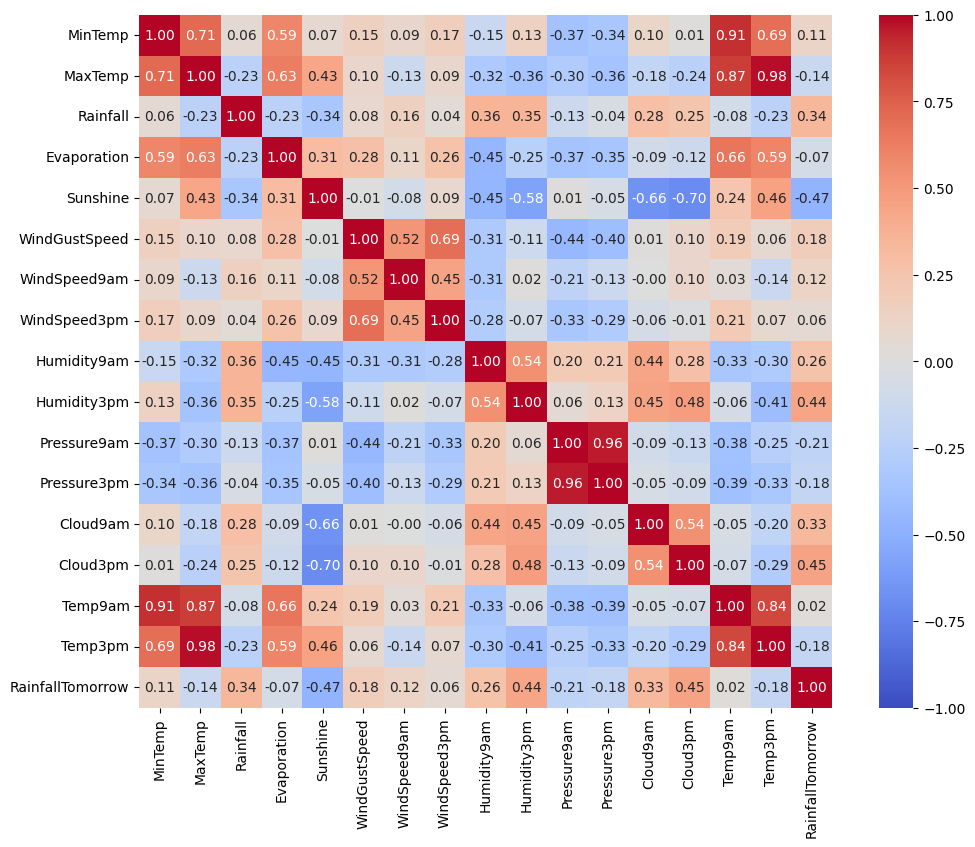

In [174]:
plt.figure(figsize=(12, 9))
sns.heatmap(df.corr(numeric_only=True, method="spearman"), annot=True, fmt='.2f', cmap='coolwarm', square=True, vmin=-1, vmax=1)
plt.show()

#### Correlación $y$ `RainfallTomorrow` con el resto de las variables explicativas cuantitativas

In [175]:
y_corr=pd.concat([df.corr(numeric_only=True, method=m).loc["RainfallTomorrow"].to_frame(m) for m in ["pearson","spearman"]],axis=1)\
.sort_values(by="pearson",ascending=False)
y_corr.style.background_gradient(cmap="viridis", vmin=-1, vmax=1)

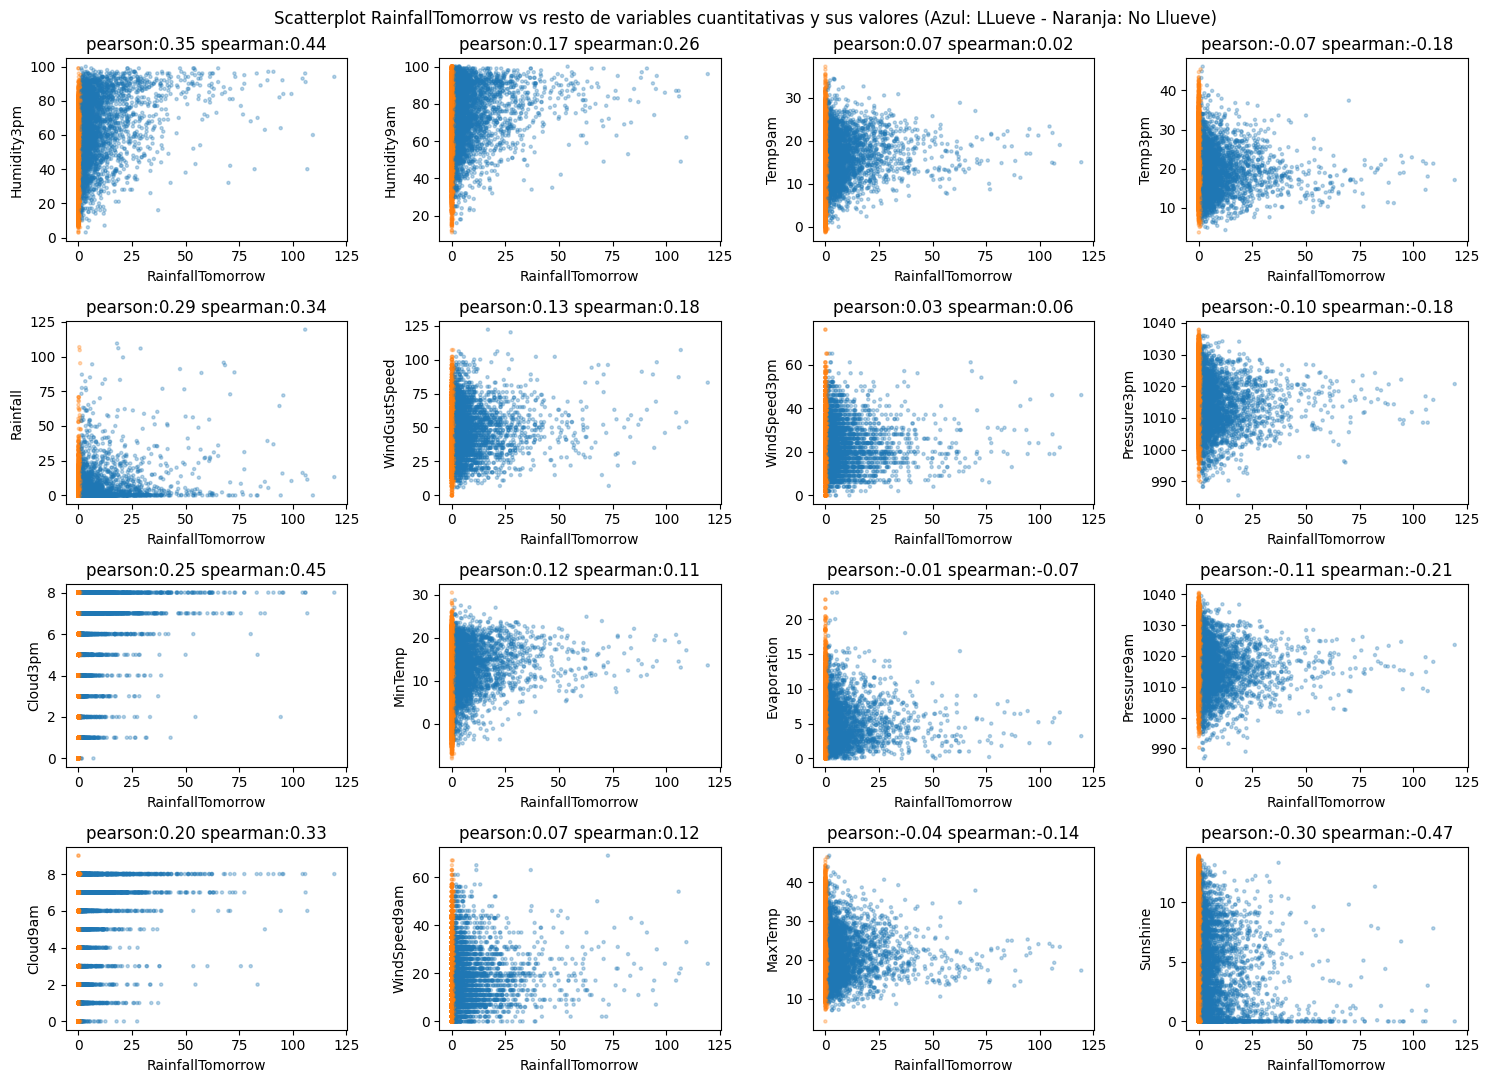

In [176]:
num_cols = y_corr.index.to_list()
num_cols.remove("RainfallTomorrow")

fig, axs = plt.subplots(4, len(num_cols)//4, figsize=(15, 11))
for i, c in enumerate(num_cols):
    scatter_kwards = dict(alpha=0.3, marker='.')
    color = ['tab:blue' if v == 'Yes' else 'tab:orange' for v in df['RainTomorrow']]
    axs[i%4, i//4].set_title(f"pearson:{y_corr.loc[c, 'pearson']:.2f} spearman:{y_corr.loc[c, 'spearman']:.2f}")
    df.plot.scatter(x="RainfallTomorrow", y=c, ax=axs[i%4, i//4], color=color, **scatter_kwards)

fig.suptitle("Scatterplot RainfallTomorrow vs resto de variables cuantitativas y sus valores (Azul: LLueve - Naranja: No Llueve)")
fig.tight_layout()
fig.show()

##### Comparando RainTomorrow = No con RainTomorrow = Yes

###### `RainTomorrow` "No"

In [177]:
mask=(df["RainTomorrow"]=="No")
df_rain_no=df[mask]
y_corr_rain_no=pd.concat([df_rain_no.corr(numeric_only=True, method=m).loc["RainfallTomorrow"].to_frame(m)
                          for m in ["pearson","spearman"]],axis=1).sort_values(by="pearson",ascending=False)
y_corr_rain_no.style.background_gradient(cmap="viridis", vmin=-1, vmax=1)

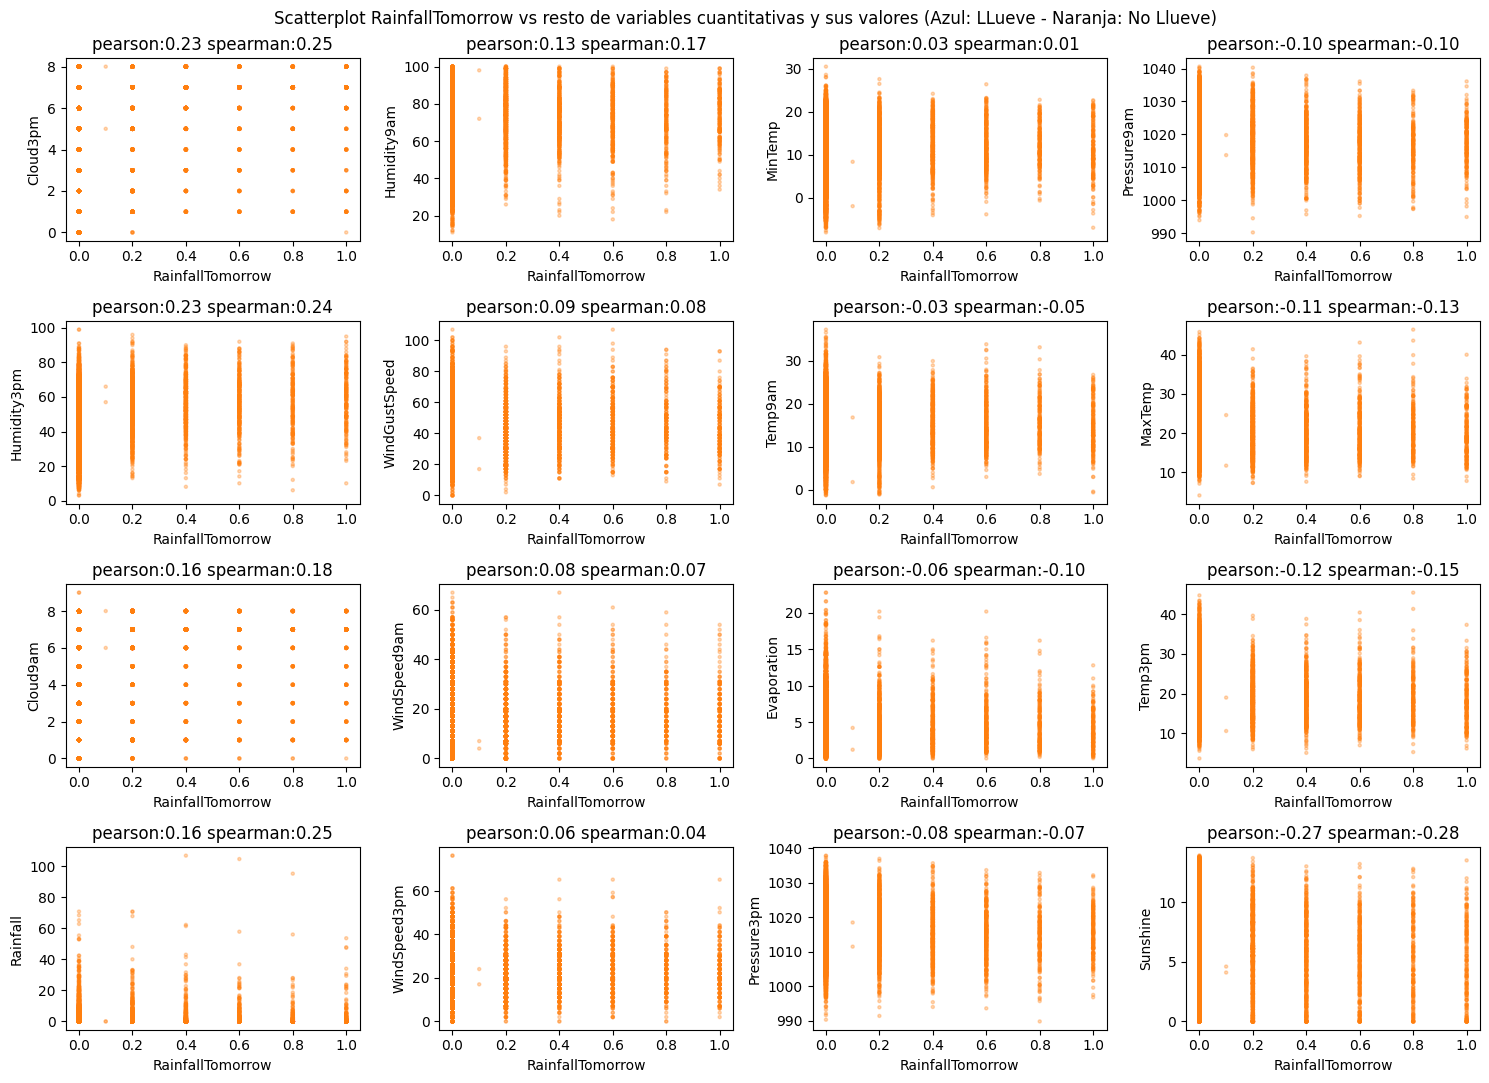

In [178]:
num_cols = y_corr_rain_no.index.to_list()
num_cols.remove("RainfallTomorrow")

fig, axs = plt.subplots(4, len(num_cols)//4, figsize=(15, 11))
for i, c in enumerate(num_cols):
    scatter_kwards = dict(alpha=0.3, marker='.')
    color = ['tab:blue' if v == 'Yes' else 'tab:orange' for v in df_rain_no['RainTomorrow']]
    axs[i%4, i//4].set_title(f"pearson:{y_corr_rain_no.loc[c, 'pearson']:.2f} spearman:{y_corr_rain_no.loc[c, 'spearman']:.2f}")
    df_rain_no.plot.scatter(x="RainfallTomorrow", y=c, ax=axs[i%4, i//4], color=color, **scatter_kwards)

fig.suptitle("Scatterplot RainfallTomorrow vs resto de variables cuantitativas y sus valores (Azul: LLueve - Naranja: No Llueve)")
fig.tight_layout()
fig.show()

###### `RainTomorrow` "Yes"

In [179]:
mask=(df["RainTomorrow"]=="Yes")
df_rain_yes=df[mask]
y_corr_rain_yes=pd.concat([df_rain_yes.corr(numeric_only=True, method=m).loc["RainfallTomorrow"].to_frame(m)
                          for m in ["pearson","spearman"]],axis=1).sort_values(by="pearson",ascending=False)
y_corr_rain_yes.style.background_gradient(cmap="viridis", vmin=-1, vmax=1)

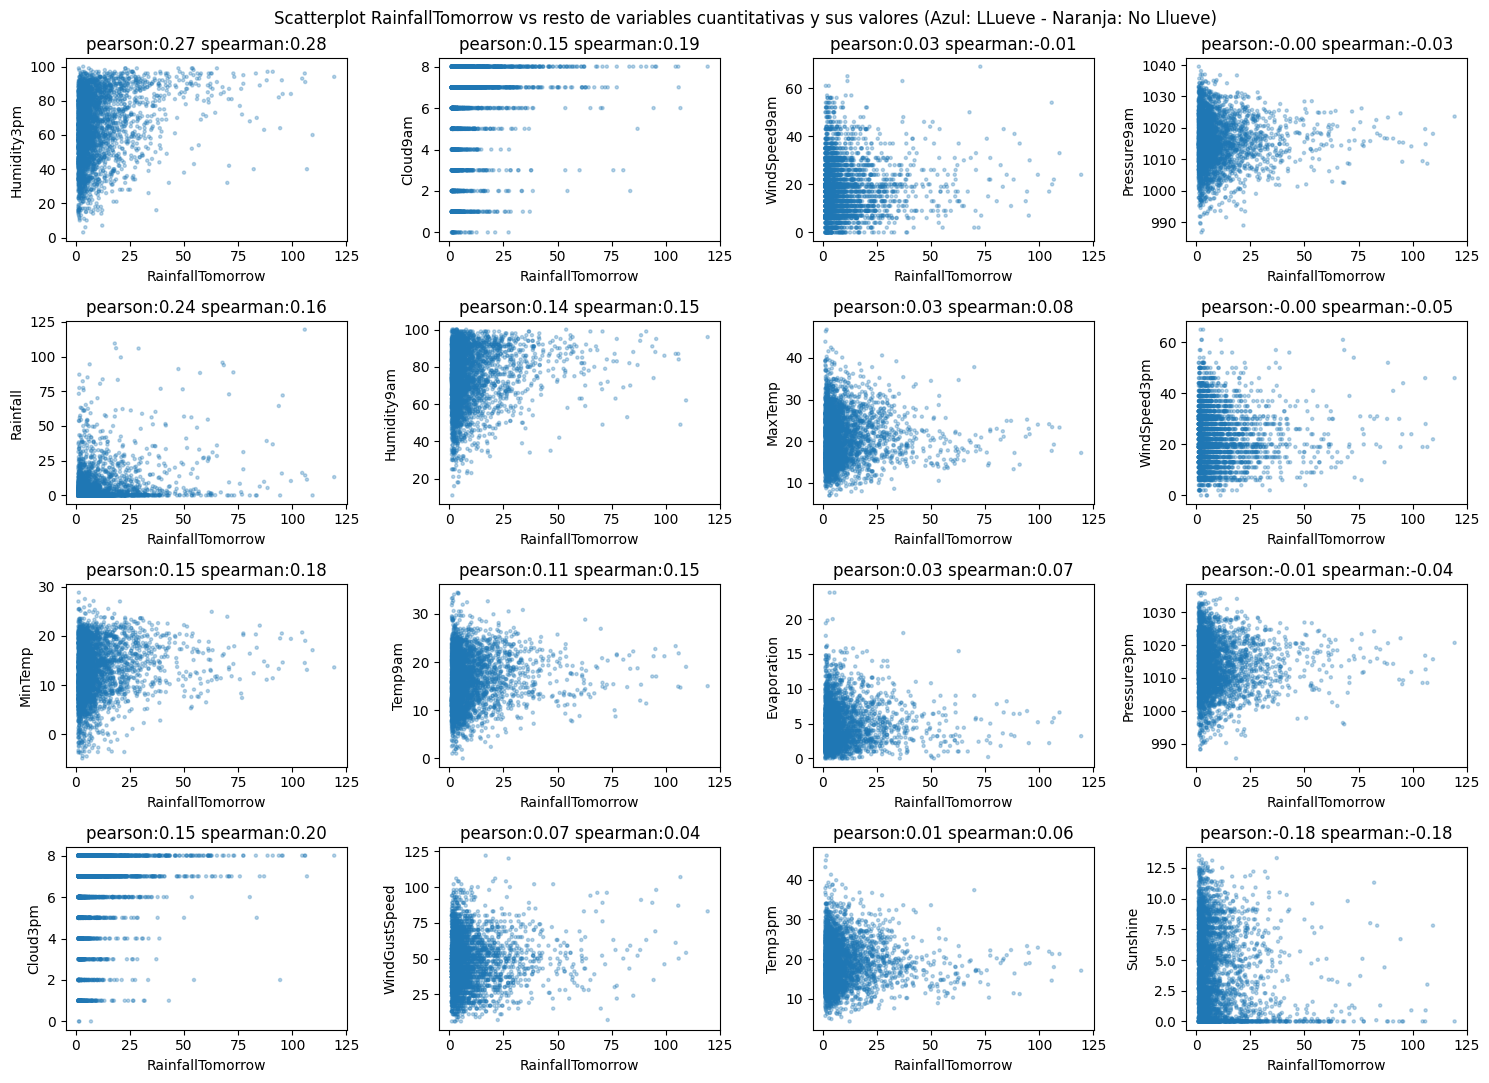

In [180]:
num_cols = y_corr_rain_yes.index.to_list()
num_cols.remove("RainfallTomorrow")

fig, axs = plt.subplots(4, len(num_cols)//4, figsize=(15, 11))
for i, c in enumerate(num_cols):
    scatter_kwards = dict(alpha=0.3, marker='.')
    color = ['tab:blue' if v == 'Yes' else 'tab:orange' for v in df_rain_yes['RainTomorrow']]
    axs[i%4, i//4].set_title(f"pearson:{y_corr_rain_yes.loc[c, 'pearson']:.2f} spearman:{y_corr_rain_yes.loc[c, 'spearman']:.2f}")
    df_rain_yes.plot.scatter(x="RainfallTomorrow", y=c, ax=axs[i%4, i//4], color=color, **scatter_kwards)

fig.suptitle("Scatterplot RainfallTomorrow vs resto de variables cuantitativas y sus valores (Azul: LLueve - Naranja: No Llueve)")
fig.tight_layout()
fig.show()

#### correlación $X$

In [181]:
from itertools import combinations

df_corr=df.corr(numeric_only=True).stack()[[c for c in combinations(df.select_dtypes(np.number).columns, 2)]].sort_values(ascending=False)
df_corr.head(20)

MaxTemp        Temp3pm         0.977000
Pressure9am    Pressure3pm     0.959991
MinTemp        Temp9am         0.904726
MaxTemp        Temp9am         0.851056
Temp9am        Temp3pm         0.819627
WindGustSpeed  WindSpeed3pm    0.701131
MinTemp        MaxTemp         0.681959
               Temp3pm         0.655332
Evaporation    Temp9am         0.637492
MaxTemp        Evaporation     0.601558
WindGustSpeed  WindSpeed9am    0.579869
MinTemp        Evaporation     0.568761
Evaporation    Temp3pm         0.563594
Humidity9am    Humidity3pm     0.559756
Cloud9am       Cloud3pm        0.525857
WindSpeed9am   WindSpeed3pm    0.494410
Humidity3pm    Cloud3pm        0.465399
               Cloud9am        0.437147
Sunshine       Temp3pm         0.432657
MaxTemp        Sunshine        0.413683
dtype: float64

In [182]:
df_corr.tail(20)

WindSpeed9am   Humidity9am   -0.340614
Humidity9am    Temp3pm       -0.341292
MinTemp        Pressure3pm   -0.346779
WindSpeed3pm   Pressure9am   -0.349533
Evaporation    Pressure9am   -0.356266
MaxTemp        Pressure3pm   -0.359779
               Humidity9am   -0.363168
MinTemp        Pressure9am   -0.372341
Pressure9am    Temp9am       -0.378793
Pressure3pm    Temp9am       -0.387828
Humidity9am    Temp9am       -0.388464
MaxTemp        Humidity3pm   -0.417356
WindGustSpeed  Pressure3pm   -0.425489
Sunshine       Humidity9am   -0.427448
Evaporation    Humidity9am   -0.454682
WindGustSpeed  Pressure9am   -0.456287
Humidity3pm    Temp3pm       -0.475433
Sunshine       Humidity3pm   -0.595675
               Cloud9am      -0.642322
               Cloud3pm      -0.679973
dtype: float64

### Normalización: **StandardScaler** vs **RobustScaler**

#### Normalización: $y$

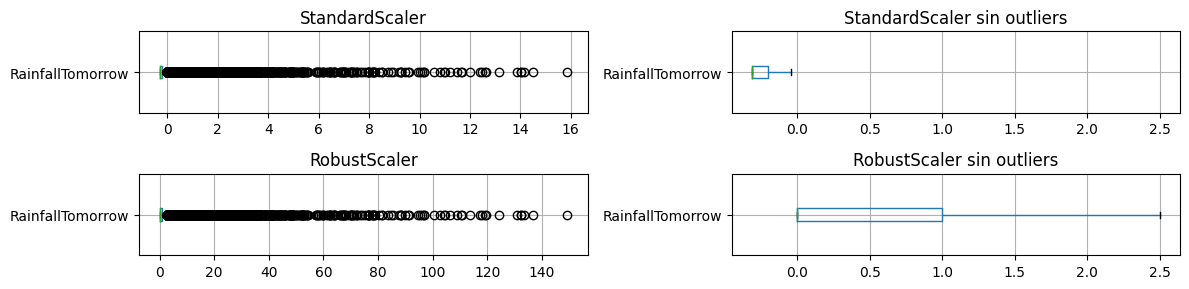

StandardScaler  RobustScaler
count    1.519900e+04  15199.000000
mean    -2.991956e-17      2.878232
std      1.000033e+00      9.231564
min     -3.117919e-01      0.000000
25%     -3.117919e-01      0.000000
50%     -3.117919e-01      0.000000
75%     -2.034643e-01      1.000000
max      1.585610e+01    149.250000

In [183]:
y=np.reshape(df['RainfallTomorrow'].values, (-1,1))
y_scaled=[]
scalers=[StandardScaler, RobustScaler]
fig,axs=plt.subplots(2,2,figsize=(12,3))
axs[0,1].sharex(axs[1,1])
for i,scaler in enumerate(scalers):
  y_norm=pd.DataFrame(scaler().fit_transform(y),columns=['RainfallTomorrow'])
  y_norm.boxplot(vert=False,ax=axs[i,0])
  y_norm.boxplot(vert=False,ax=axs[i,1], showfliers=False)
  axs[i,0].set_title(scaler.__name__)
  axs[i,1].set_title(f"{scaler.__name__} sin outliers")
  y_scaled.append(y_norm.describe())

plt.tight_layout()
plt.show()

y_desc=pd.concat(y_scaled,axis=1)
y_desc.columns=[s.__name__ for s in scalers]
y_desc

In [184]:
desc_temp=y_norm.describe()
df_out=df[df["RainTomorrow"]=="No"]['RainfallTomorrow']
Q1=df_out.quantile(0.25)
Q3=df_out.quantile(0.75)
RIC=Q3-Q1
desc_temp.loc['outliers']=(df_out<Q1-1.5*RIC).sum()+(Q3+1.5*RIC<df_out).sum()
desc_temp

RainfallTomorrow
count         15199.000000
mean              2.878232
std               9.231564
min               0.000000
25%               0.000000
50%               0.000000
75%               1.000000
max             149.250000
outliers       1944.000000

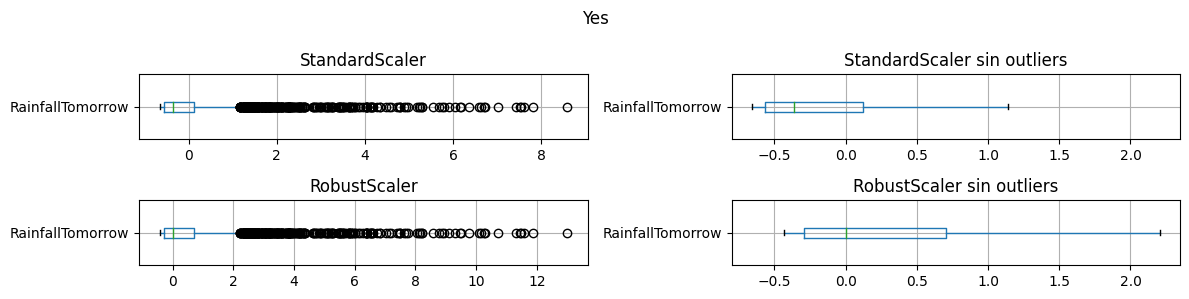

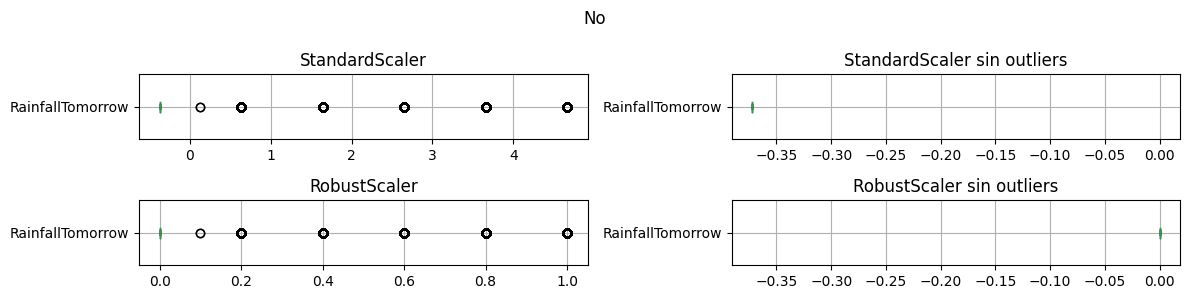

count          mean       std  \
Yes StandardScaler RainfallTomorrow   3556.0 -9.591128e-17  1.000141   
    RobustScaler   RainfallTomorrow   3556.0  5.226889e-01  1.453097   
No  StandardScaler RainfallTomorrow  11643.0  9.764394e-18  1.000043   
    RobustScaler   RainfallTomorrow  11643.0  7.391566e-02  0.198571   

                                          min       25%       50%       75%  \
Yes StandardScaler RainfallTomorrow -0.656970 -0.563114 -0.359758  0.125169   
    RobustScaler   RainfallTomorrow -0.431818 -0.295455  0.000000  0.704545   
No  StandardScaler RainfallTomorrow -0.372254 -0.372254 -0.372254 -0.372254   
    RobustScaler   RainfallTomorrow  0.000000  0.000000  0.000000  0.000000   

                                           max  outliers  outliers_rel  
Yes StandardScaler RainfallTomorrow   8.587913     315.0      0.088583  
    RobustScaler   RainfallTomorrow  13.000000     312.0      0.087739  
No  StandardScaler RainfallTomorrow   4.663950    1944.0      0.166967  
    RobustScaler   RainfallTomorrow   1.000000    1944.0      0.166967

In [185]:
y_scaled=[]
for b in ["Yes", "No"]:
  df_out=df[df["RainTomorrow"]==b]['RainfallTomorrow']
  y=np.reshape(df_out.values, (-1,1))
  scalers=[StandardScaler, RobustScaler]
  fig,axs=plt.subplots(2,2,figsize=(12,3))
  axs[0,1].sharex(axs[1,1])
  for i,scaler in enumerate(scalers):
    y_norm=pd.DataFrame(scaler().fit_transform(y),columns=['RainfallTomorrow'])
    y_norm.boxplot(vert=False,ax=axs[i,0])
    y_norm.boxplot(vert=False,ax=axs[i,1], showfliers=False)
    axs[i,0].set_title(scaler.__name__)
    axs[i,1].set_title(f"{scaler.__name__} sin outliers")

    # contamos outliers
    desc_temp=y_norm.describe()
    Q1=y_norm.quantile(0.25)
    Q3=y_norm.quantile(0.75)
    RIC=Q3-Q1
    desc_temp.loc['outliers']=(y_norm<Q1-1.5*RIC).sum()+(Q3+1.5*RIC<y_norm).sum()
    desc_temp.loc['outliers_rel']=desc_temp.loc['outliers']/desc_temp.loc['count']
    y_scaled.append(desc_temp)
  plt.suptitle(b)
  plt.tight_layout()
  plt.show()

y_desc=pd.concat(y_scaled,axis=1, keys=[(b, s.__name__,) for b in ["Yes", "No"] for s in scalers])
y_desc.T

#### Normalización: $X$

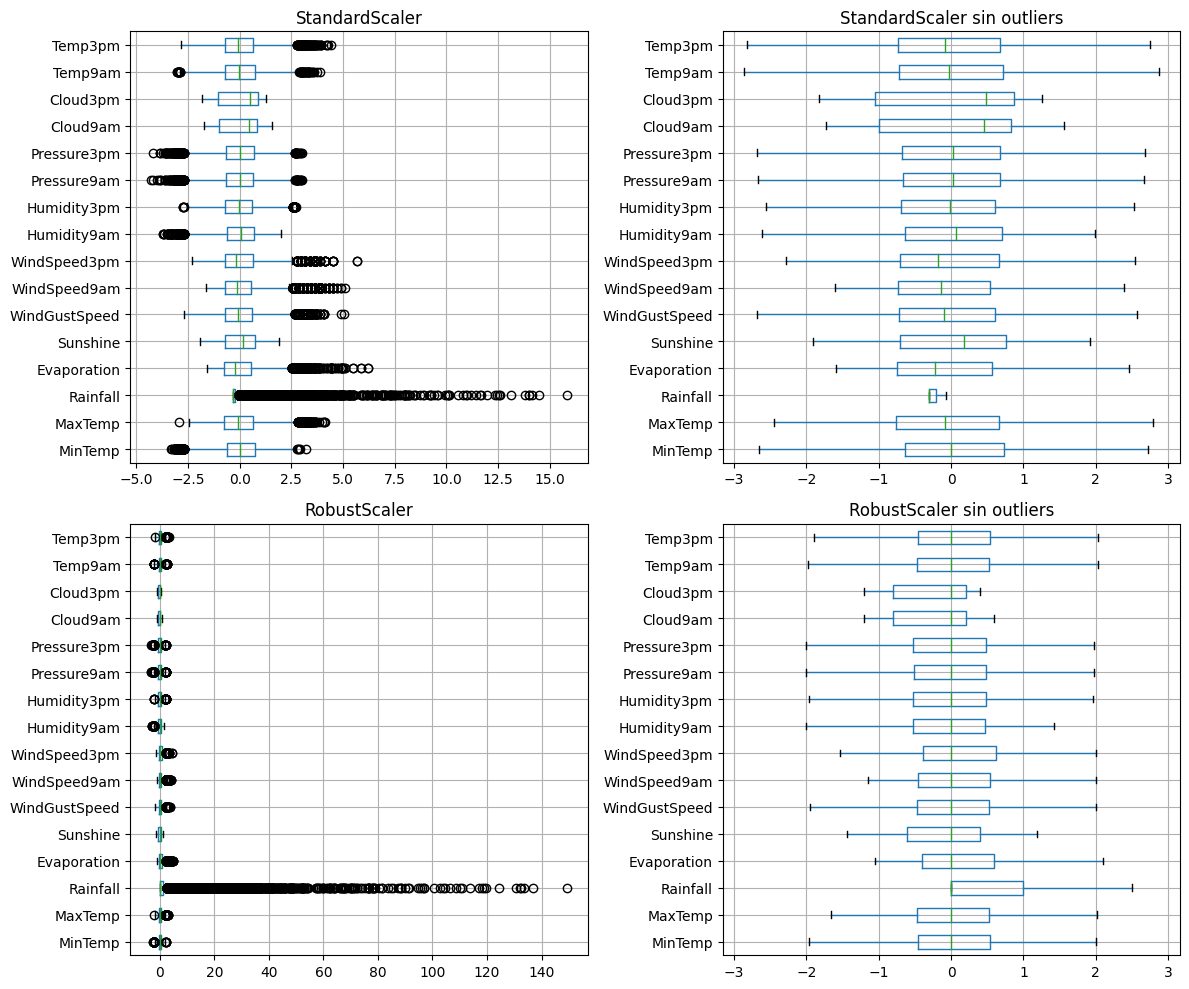

count                        mean                 \
              RobustScaler StandardScaler RobustScaler StandardScaler   
MinTemp            15189.0        15189.0     0.000757  -3.592711e-16   
MaxTemp            15193.0        15193.0     0.056303  -3.442108e-16   
Rainfall           15036.0        15036.0     2.874501   0.000000e+00   
Evaporation        13505.0        13505.0     0.167277  -5.050878e-17   
Sunshine           15199.0        15199.0    -0.126037   1.495978e-17   
WindGustSpeed      14970.0        14970.0     0.068178   9.113173e-17   
WindSpeed9am       14939.0        14939.0     0.113817   1.065410e-16   
WindSpeed3pm       14950.0        14950.0     0.134356  -4.562682e-17   
Humidity9am        15111.0        15111.0    -0.053099   7.899621e-17   
Humidity3pm        15154.0        15154.0     0.010378  -3.751050e-18   
Pressure9am        14946.0        14946.0    -0.016765  -1.968183e-15   
Pressure3pm        14954.0        14954.0    -0.022459  -1.056264e-15   
Cloud9am           13158.0        13158.0    -0.252303  -1.382421e-16   
Cloud3pm           12917.0        12917.0    -0.252830   3.520534e-17   
Temp9am            15175.0        15175.0     0.021333  -2.247516e-16   
Temp3pm            15183.0        15183.0     0.056135  -1.078239e-15   

                       std                         min                 \
              RobustScaler StandardScaler RobustScaler StandardScaler   
MinTemp           0.734662       1.000033    -2.450000      -3.336009   
MaxTemp           0.704087       1.000033    -2.000000      -2.920620   
Rainfall          9.255772       1.000033     0.000000      -0.310573   
Evaporation       0.764379       1.000037    -1.050000      -1.592564   
Sunshine          0.683190       1.000033    -1.433962      -1.914501   
WindGustSpeed     0.753590       1.000033    -1.952381      -2.681335   
WindSpeed9am      0.790936       1.000033    -1.153846      -1.602791   
WindSpeed3pm      0.733004       1.000033    -1.538462      -2.282215   
Humidity9am       0.745046       1.000033    -2.809524      -3.699793   
Humidity3pm       0.771114       1.000033    -2.086957      -2.719967   
Pressure9am       0.747307       1.000033    -3.212121      -4.275972   
Pressure3pm       0.741297       1.000033    -3.142857      -4.209518   
Cloud9am          0.546282       1.000038    -1.200000      -1.734879   
Cloud3pm          0.518714       1.000039    -1.200000      -1.826069   
Temp9am           0.696364       1.000033    -2.087500      -3.028447   
Temp3pm           0.714499       1.000033    -1.963415      -2.826618   

                       25%                         50%                 \
              RobustScaler StandardScaler RobustScaler StandardScaler   
MinTemp          -0.462500      -0.630593          0.0      -0.001031   
MaxTemp          -0.476744      -0.757100          0.0      -0.079968   
Rainfall          0.000000      -0.310573          0.0      -0.310573   
Evaporation      -0.400000      -0.742169          0.0      -0.218849   
Sunshine         -0.603774      -0.699296          0.0       0.184489   
WindGustSpeed    -0.476190      -0.722391          0.0      -0.090474   
WindSpeed9am     -0.461538      -0.727460          0.0      -0.143906   
WindSpeed3pm     -0.384615      -0.708029          0.0      -0.183301   
Humidity9am      -0.523810      -0.631808          0.0       0.071272   
Humidity3pm      -0.521739      -0.690085          0.0      -0.013458   
Pressure9am      -0.515152      -0.666932          0.0       0.022435   
Pressure3pm      -0.520408      -0.671749          0.0       0.030298   
Cloud9am         -0.800000      -1.002629          0.0       0.461872   
Cloud3pm         -0.800000      -1.054901          0.0       0.487435   
Temp9am          -0.475000      -0.712772          0.0      -0.030636   
Temp3pm          -0.463415      -0.727176          0.0      -0.078568   

                       75%                         max                 
    

In [186]:
x_cols_num=df.select_dtypes(np.number).columns.to_list()
x_cols_num.remove('RainfallTomorrow')
X=np.reshape(df[x_cols_num].values, (-1,len(x_cols_num)))
X_scaled=[]
scalers=[StandardScaler, RobustScaler]
fig,axs=plt.subplots(2,2,figsize=(12,10))
axs[0,1].sharex(axs[1,1])
for i,scaler in enumerate(scalers):
  y_norm=pd.DataFrame(scaler().fit_transform(X),columns=df[x_cols_num].columns)
  y_norm.boxplot(vert=False, ax=axs[i,0])
  y_norm.boxplot(vert=False, ax=axs[i,1], showfliers=False)
  axs[i,0].set_title(scaler.__name__)
  axs[i,1].set_title(f"{scaler.__name__} sin outliers")
  X_scaled.append(y_norm.describe())

plt.tight_layout()
plt.show()

X_desc=pd.concat(X_scaled,axis=1, keys=[(s.__name__,) for s in scalers])
X_desc.T.unstack(0)

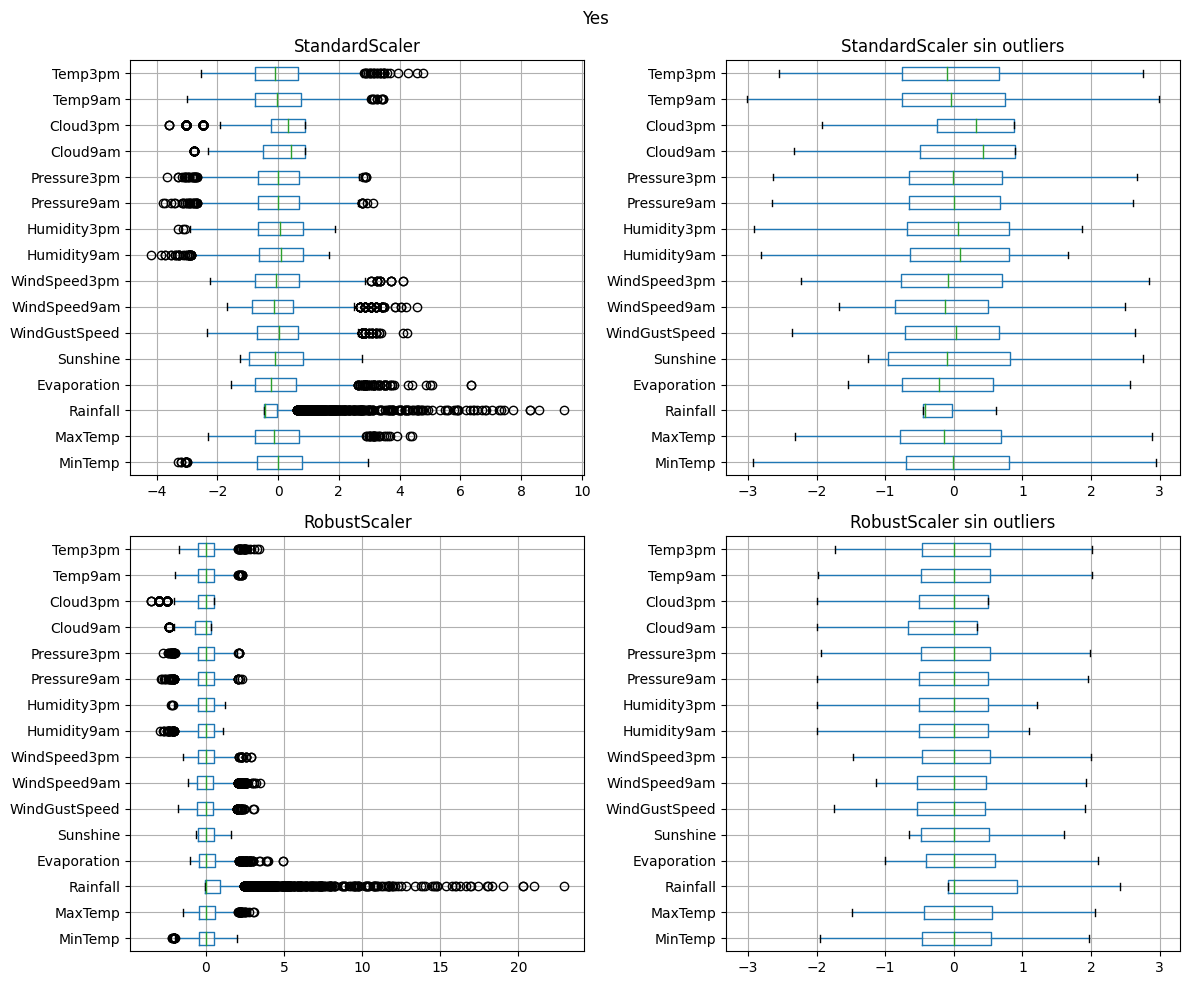

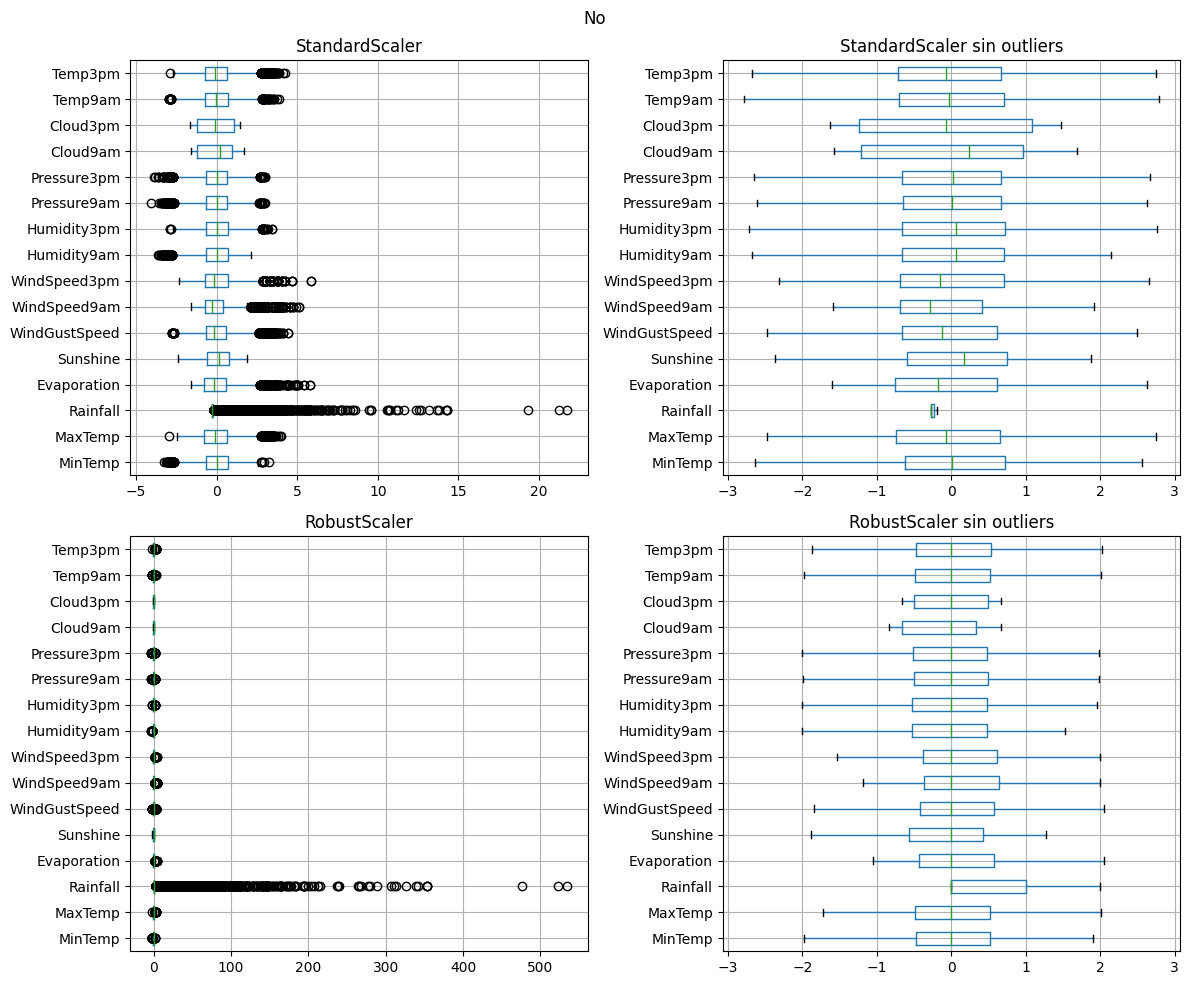

Yes                                            \
             StandardScaler                                             
                    MinTemp       MaxTemp      Rainfall   Evaporation   
count          3.554000e+03  3.555000e+03  3.443000e+03  3.197000e+03   
mean           3.198842e-17 -2.398456e-16  3.301970e-17 -2.667036e-17   
std            1.000141e+00  1.000141e+00  1.000145e+00  1.000156e+00   
min           -3.282921e+00 -2.317482e+00 -4.539076e-01 -1.546704e+00   
25%           -6.960394e-01 -7.780221e-01 -4.539076e-01 -7.511691e-01   
50%           -1.236354e-02 -1.351706e-01 -4.208911e-01 -2.208126e-01   
75%            8.006564e-01  6.937694e-01 -2.469286e-02  5.747223e-01   
max            2.944073e+00  4.415541e+00  9.401523e+00  6.342350e+00   
outliers       1.300000e+01  2.500000e+01  4.450000e+02  6.500000e+01   
outliers_rel   3.657850e-03  7.032349e-03  1.292477e-01  2.033156e-02   

                                                                      \
                                                                       
                  Sunshine WindGustSpeed  WindSpeed9am  WindSpeed3pm   
count         3.556000e+03  3.505000e+03  3.501000e+03  3.504000e+03   
mean          1.079002e-16  4.865343e-17  1.095953e-16  4.055609e-18   
std           1.000141e+00  1.000143e+00  1.000143e+00  1.000143e+00   
min          -1.257291e+00 -2.357078e+00 -1.675439e+00 -2.228205e+00   
25%          -9.597763e-01 -7.087677e-01 -8.588032e-01 -7.633038e-01   
50%          -9.698443e-02  3.012996e-02 -1.329051e-01 -7.968326e-02   
75%           8.253103e-01  6.553511e-01  5.022558e-01  7.015973e-01   
max           2.759154e+00  4.236163e+00  4.585433e+00  4.119700e+00   
outliers      0.000000e+00  3.400000e+01  6.400000e+01  1.700000e+01   
outliers_rel  0.000000e+00  9.700428e-03  1.828049e-02  4.851598e-03   

                                          ...            No                \
                                          ...  RobustScaler                 
               Humidity9am   Humidity3pm  ...  WindSpeed9am  WindSpeed3pm   
count         3.548000e+03  3.545000e+03  ...  11438.000000  11446.000000   
mean          1.842445e-16  2.405222e-17  ...      0.261091      0.109175   
std           1.000141e+00  1.000141e+00  ...      0.906043      0.713543   
min          -4.188034e+00 -3.284841e+00  ...     -1.181818     -1.538462   
25%          -6.355439e-01 -6.777851e-01  ...     -0.363636     -0.384615   
50%           8.811136e-02  6.708812e-02  ...      0.000000      0.000000   
75%           8.117667e-01  8.119614e-01  ...      0.636364      0.615385   
max           1.666996e+00  1.876066e+00  ...      4.909091      4.307692   
outliers      3.000000e+01  3.000000e+00  ...    473.000000     98.000000   
outliers_rel  8.455468e-03  8.462623e-04  ...      0.041353      0.008562   

                                                                      \
                                                                       
               Humidity9am   Humidity3pm   Pressure9am   Pressure3pm   
count         11563.000000  11609.000000  11440.000000  11453.000000   
mean             -0.042253     -0.042090     -0.006911     -0.020805   
std               0.730970      0.722294      0.759179      0.749243   
min              -2.714286     -2.142857     -3.085106     -2.924731   
25%              -0.523810     -0.523810     -0.500000     -0.516129   
50%               0.000000      0.000000      0.000000      0.000000   
75%               0.476190      0.476190      0.500000      0.483871   
max               1.523810      2.428571      2.276596      2.247312   
outliers         82.000000     22.000000     84.000000     76.000000   
outliers_rel      0.007092      0.001895      0.007343      0.006636   

                                                                     
                                                                     
                  Cloud9am     Cloud3pm       Temp9am     

In [187]:
X_scaled=[]
for b in ["Yes", "No"]:
  df_out=df[df["RainTomorrow"]==b][x_cols_num]
  x_cols_num=df.select_dtypes(np.number).columns.to_list()
  x_cols_num.remove('RainfallTomorrow')
  X=np.reshape(df_out.values, (-1,len(x_cols_num)))
  scalers=[StandardScaler, RobustScaler]
  fig,axs=plt.subplots(2,2,figsize=(12,10))
  axs[0,1].sharex(axs[1,1])
  for i,scaler in enumerate(scalers):
    X_norm=pd.DataFrame(scaler().fit_transform(X),columns=df[x_cols_num].columns)
    X_norm.boxplot(vert=False, ax=axs[i,0])
    X_norm.boxplot(vert=False, ax=axs[i,1], showfliers=False)
    axs[i,0].set_title(scaler.__name__)
    axs[i,1].set_title(f"{scaler.__name__} sin outliers")

    desc_temp=X_norm.describe()
    Q1=X_norm.quantile(0.25)
    Q3=X_norm.quantile(0.75)
    RIC=Q3-Q1
    desc_temp.loc['outliers']=(X_norm<Q1-1.5*RIC).sum()+(Q3+1.5*RIC<X_norm).sum()
    desc_temp.loc['outliers_rel']=desc_temp.loc['outliers']/desc_temp.loc['count']
    X_scaled.append(desc_temp)

  plt.suptitle(b)
  plt.tight_layout()
  plt.show()

X_desc=pd.concat(X_scaled,axis=1, keys=[(b, s.__name__,) for b in ["Yes", "No"] for s in scalers])
X_desc

### Outliers
- Al observar los outliers, notamos que en proporción la cantidad de outliers de la mayoría de las variables es muy inferior a la variable `Rainfall`, por lo cual no nos preocupa que esto modifique nuestra predicción. Y en el caso de `Rainfall`consideramos que es lógico la presencia de Outliers dado que esa variable depende fuertemente de que haya o no llovido, y como vimos en el principio del análisis de los datos, la proporción de días lluviosos con respecto a días no lluviosos es de 4/1 a favor de los no lluviosos.

In [188]:
df_rain_yes = df[df["RainToday"] == "Yes"]
df_rain_no = df[df["RainToday"] == "No"]
Q1_rain_yes = df_rain_yes["RainfallTomorrow"].quantile(0.25)
Q3_rain_yes = df_rain_yes["RainfallTomorrow"].quantile(0.75)
IQR_rain_yes = Q3_rain_yes - Q1_rain_yes

lower_bound_rain_yes = Q1_rain_yes - 1.5 * IQR_rain_yes
upper_bound_rain_yes = Q3_rain_yes + 1.5 * IQR_rain_yes

outliers_rain_yes = df_rain_yes[(df_rain_yes["RainfallTomorrow"] < lower_bound_rain_yes) | (df_rain_yes["RainfallTomorrow"] > upper_bound_rain_yes)]
outliers_rain_yes

Date   Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
30178 2008-02-03     Sydney     21.6     24.5       6.6          2.4   
30179 2008-02-04     Sydney     20.2     22.8      18.8          2.2   
30182 2008-02-07     Sydney     18.6     26.3       6.2          5.2   
30183 2008-02-08     Sydney     17.2     22.3      27.6          5.8   
30203 2008-02-28     Sydney     17.9     21.4       4.2          4.2   
...          ...        ...      ...      ...       ...          ...   
70109 2016-09-15  Melbourne      8.7     14.6       2.0          3.2   
70315 2017-04-09  Melbourne     11.7     15.2      10.6          7.8   
70316 2017-04-10  Melbourne      9.0     17.0      25.4          2.8   
70331 2017-04-25  Melbourne     16.2     17.7      21.6          3.4   
70332 2017-04-26  Melbourne     10.1     14.5      20.0          4.2   

       Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Pressure9am  \
30178       0.1         NaN           17.0        ESE  ...      1016.7   
30179       0.0         NaN           22.0        NNE  ...      1014.2   
30182       5.2         NaN           15.0          W  ...       999.0   
30183       2.1         NaN           15.0          S  ...      1008.3   
30203       0.0         NaN           20.0          S  ...      1010.0   
...         ...         ...            ...        ...  ...         ...   
70109       1.0         WSW           37.0         NW  ...      1006.7   
70315       0.5         WSW           44.0          W  ...      1007.2   
70316       0.0           S           63.0        SSW  ...      1015.1   
70331       3.6          NW           30.0        WNW  ...      1008.1   
70332       5.3         SSW           59.0          S  ...      1009.9   

       Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
30178       1015.6       7.0       8.0     23.5     23.0        Yes   
30179       1011.8       8.0       8.0     21.4     20.9        Yes   
30182       1000.3       4.0       7.0     21.7     22.3        Yes   
30183       1007.4       7.0       8.0     18.9     21.1        Yes   
30203       1010.1       8.0       8.0     20.4     19.2        Yes   
...            ...       ...       ...      ...      ...        ...   
70109       1009.2       6.0       7.0     12.0     12.0        Yes   
70315       1005.1       7.0       7.0     11.7     12.4        Yes   
70316       1018.0       8.0       7.0     14.9     15.5        Yes   
70331       1006.9       7.0       7.0     16.4     17.1        Yes   
70332       1015.0       7.0       4.0     13.2     10.5        Yes   

       RainTomorrow  RainfallTomorrow  Month  
30178           Yes              18.8      2  
30179           Yes              77.4      2  
30182           Yes              27.6      2  
30183           Yes              12.6      2  
30203           Yes              33.0      2  
...             ...               ...    ...  
70109           Yes              13.4      9  
70315           Yes              25.4      4  
70316           Yes              15.4      4  
70331           Yes              20.0      4  
70332           Yes              15.4      4  

[433 rows x 25 columns]

In [189]:
Q1_rain_no = df_rain_no["RainfallTomorrow"].quantile(0.25)
Q3_rain_no = df_rain_no["RainfallTomorrow"].quantile(0.75)
IQR_rain_no = Q3_rain_no - Q1_rain_no

lower_bound_rain_no = Q1_rain_yes - 1.5 * IQR_rain_no
upper_bound_rain_no = Q3_rain_yes + 1.5 * IQR_rain_no

outliers_rain_no = df_rain_no[(df_rain_no["RainfallTomorrow"] < lower_bound_rain_no) | (df_rain_no["RainfallTomorrow"] > upper_bound_rain_no)]
outliers_rain_no

Date   Location  MinTemp  MaxTemp  Rainfall  Evaporation  \
30187 2008-02-12     Sydney     18.9     27.3       0.0          6.8   
30201 2008-02-26     Sydney     19.3     26.2       0.0          3.6   
30205 2008-03-01     Sydney     12.8     22.0       0.2          6.2   
30211 2008-03-07     Sydney     19.9     24.9       0.0          7.6   
30227 2008-03-23     Sydney     16.3     24.8       0.4          4.0   
...          ...        ...      ...      ...       ...          ...   
70314 2017-04-08  Melbourne     18.6     28.1       0.0          9.4   
70326 2017-04-20  Melbourne     14.6     26.5       0.0          7.4   
70330 2017-04-24  Melbourne     15.9     24.7       0.0          2.8   
70363 2017-05-27  Melbourne     11.9     17.8       0.0          1.4   
70372 2017-06-05  Melbourne      5.6     17.5       0.0          1.4   

       Sunshine WindGustDir  WindGustSpeed WindDir9am  ... Pressure9am  \
30187       6.7         NaN           24.0          N  ...      1010.7   
30201       8.4         NaN           28.0        WSW  ...      1018.3   
30205      11.3         NaN           31.0          W  ...      1020.9   
30211       4.5         NaN           24.0        SSW  ...      1021.3   
30227       6.1         NaN           13.0        WNW  ...      1023.1   
...         ...         ...            ...        ...  ...         ...   
70314       7.1           N           44.0          N  ...      1018.6   
70326       5.1         NNW           43.0          N  ...      1026.1   
70330       4.9           N           28.0        NNE  ...      1020.7   
70363       4.1           N           54.0          N  ...      1017.5   
70372       2.7          NW           28.0        NNE  ...      1025.5   

       Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  RainToday  \
30187       1007.5       7.0       7.0     22.9     24.7         No   
30201       1015.6       1.0       6.0     23.0     25.8         No   
30205       1020.6       0.0       1.0     15.9     21.2         No   
30211       1020.7       5.0       7.0     22.9     23.3         No   
30227       1020.6       5.0       6.0     18.5     24.8         No   
...            ...       ...       ...      ...      ...        ...   
70314       1012.8       2.0       5.0     21.7     27.8         No   
70326       1022.2       3.0       7.0     21.7     25.2         No   
70330       1014.7       7.0       7.0     16.6     24.5         No   
70363       1012.0       7.0       7.0     13.9     17.2         No   
70372       1021.7       7.0       7.0      8.7     16.8         No   

       RainTomorrow  RainfallTomorrow  Month  
30187           Yes              14.4      2  
30201           Yes              22.2      2  
30205           Yes               5.4      3  
30211           Yes              17.4      3  
30227           Yes              17.0      3  
...             ...               ...    ...  
70314           Yes              10.6      4  
70326           Yes               9.4      4  
70330           Yes              21.6      4  
70363           Yes               6.8      5  
70372           Yes               6.4      6  

[910 rows x 25 columns]

## Predicción `RainfallTomorrow` a través de Regresión Lineal Múltiple

### Funciones utilizadas
Definimos el conjunto de funciones que utilizaremos para realizar la regresion. Ademas las aplicamos para el método de Lasso para mostrar su uso.

In [190]:
def evaluate_metrics(y_test, y_hat):
  """
  Evalua un conjunto de métricas
  """
  return (
      explained_variance_score(y_test, y_hat),                # EVS
      max_error(y_test, y_hat),                               # MAX ERROR
      mean_absolute_error(y_test, y_hat),                     # MAE
      mean_squared_error(y_test, y_hat),                      # MSE
      mean_squared_error(y_test, y_hat, squared = False),     # RMSE
      #mean_squared_log_error(y_test, y_hat, squared = False),# MSLE
      r2_score(y_test, y_hat),                                # R2
      median_absolute_error(y_test, y_hat),                   # MeAE
      mean_absolute_percentage_error(y_test, y_hat),          # MAPE
      )

def plot_prediction_error(dataframe, X_test, y_test, y_hat, title):
  """
  Grafica los diagrama de dispersión para los residuos y la comparación entre los valores reales y estimados.
  """
  fig, axs = plt.subplots(ncols=2, figsize=(8, 3))
  # aquellos en los que si llovio al dia siguiente estan muy mal estimados.
  scatter_kwards=dict(alpha=0.3,marker='.',color=['r' if v else 'tab:blue' for v in dataframe.loc[X_test.index]['RainTomorrow']=='Yes'])
  PredictionErrorDisplay(y_true=y_test,y_pred=y_hat).plot(ax=axs[0],kind="actual_vs_predicted",scatter_kwargs=scatter_kwards)
  PredictionErrorDisplay(y_true=y_test,y_pred=y_hat).plot(ax=axs[1],kind="residual_vs_predicted",scatter_kwargs=scatter_kwards)
  axs[0].set_title("Valores Reales vs Valores Estimados")
  axs[1].set_title("Residuos vs Valores Estimados")
  fig.suptitle(title)
  fig.tight_layout()
  fig.show()

def evaluate_pipe(X_train, X_test, y_train, y_test, pipe: make_pipeline, dataframe: pd.DataFrame, plot=True):
  """
  Entrena y evalua 1 pipeline
  """
  name=pipe[-1].__class__.__name__
  pipe.fit(X_train, y_train)
  y_hat=pipe.predict(X_test)
  if plot:
    plot_prediction_error(dataframe, X_test, y_test, y_hat,name)
  return [name,*evaluate_metrics(y_test, y_hat)]

def evaluate_pipes(X_train, X_test, y_train, y_test,models_pipeline: list[make_pipeline],
                   dataframe: pd.DataFrame, plot=True):
  """
  Entrena y evalua un conjunto de pipeline mostrando una tabla resumen de métricas
  """
  data=[['Model Name','EVS','MAX ERROR','MAE','MSE','RMSE','R^2','MeAE','MAPE',"Best Alpha","L1 ratio"]]
  for model_pipeline in models_pipeline:
    data.append(
        evaluate_pipe(X_train, X_test, y_train, y_test, model_pipeline, dataframe, plot=plot)+
        [
            model_pipeline[-1].alpha_ if "alpha_" in dir(model_pipeline[-1]) else None,         # Alpha
            model_pipeline[-1].l1_ratio_ if "l1_ratio_" in dir(model_pipeline[-1]) else None,   # l1 ratio
        ])
  print(tabulate(data,headers='firstrow',tablefmt='fancy_grid'))
  return data

def evaluate_models(df, model_pipes: list[make_pipeline],cols=None,plot_errors=True,plot_models=True,comment=""):
  """
  Evalua un conjunto de datos en funcion de unas columnas de interes y unos modelos (pipes) para aplicar regresión.
  Reliza:
    - entrenamiento de cada modelo
    - calculo de metricas
    - muestra una tabla que resumen todos los valores de las metricas
    - grafica los residuos de las predicciones
    - grafica los pesos de las variables explicativas
  """
  if cols==None:
    cols=df.columns

  df_aux=df[cols].dropna(how='any')
  y=df_aux[y_target_name[1]]

  cols_cat=df_aux.select_dtypes(exclude=np.number).columns.to_list()
  [cols_cat.remove(c) for c in ['Date', "RainTomorrow"] if c in cols_cat]
  X=pd.get_dummies(data=df_aux, columns=cols_cat, drop_first=True).drop(columns=['Date',*y_target_name])
  X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y<=1, random_state=777)

  models=evaluate_pipes(X_train, X_test, y_train, y_test, model_pipes, df_aux,plot=plot_errors)
  df_stem=pd.DataFrame(
      {model.__class__.__name__:model.coef_.flatten() for model in map(lambda x: x[-1],model_pipes)},
      index=X_train.columns).sort_values(by="LassoCV")

  if plot_models:
    fig, ax = plt.subplots(1,len(model_pipes), figsize=(1+3*len(model_pipes), 3+1.5*len(cols_cat)), sharey=True)
    if len(model_pipes)==1:
      ax=[ax]
    for i,col in enumerate(df_stem.columns):
      ax[i].stem(df_stem.index, df_stem[col], markerfmt=' ', orientation="horizontal")
      ax[i].set_title(col);
    ax[0].set_ylabel('Parametros')
    fig.tight_layout()
    fig.show()
  return df_stem.assign(comment=comment) if comment else df_stem

╒══════════════╤══════════╤═════════════╤═════════╤═════════╤═════════╤═════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name   │      EVS │   MAX ERROR │     MAE │     MSE │    RMSE │     R^2 │    MeAE │        MAPE │   Best Alpha │ L1 ratio   │
╞══════════════╪══════════╪═════════════╪═════════╪═════════╪═════════╪═════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV      │ 0.216892 │     79.7661 │ 2.92003 │ 36.7729 │ 6.06407 │ 0.21689 │ 1.64652 │ 4.84586e+15 │    0.0149234 │            │
╘══════════════╧══════════╧═════════════╧═════════╧═════════╧═════════╧═════════╧═════════╧═════════════╧══════════════╧════════════╛


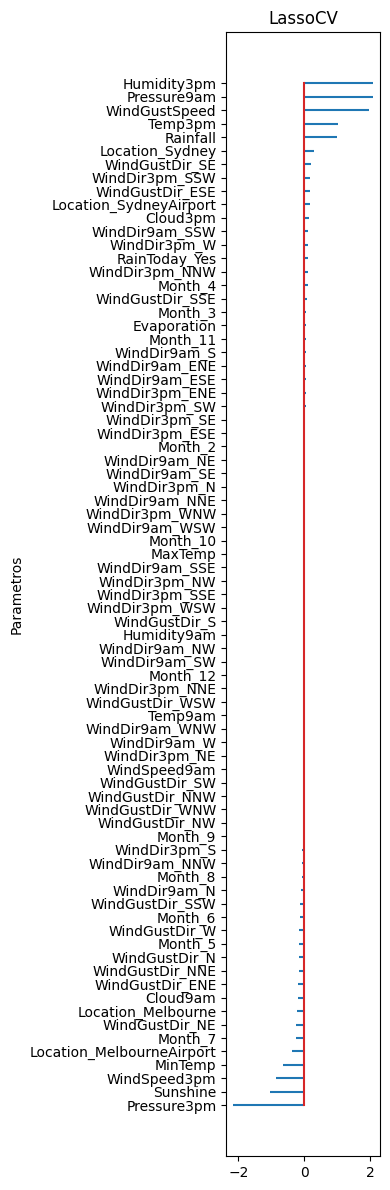

In [191]:
# prueba de los metodos con todo el data set, usando Lasso
example1=evaluate_models(df,[make_pipeline(StandardScaler(),LassoCV())],plot_errors=False)

In [ ]:
example1

In [192]:
example1["LassoCV"].describe()

count    77.000000
mean      0.037192
std       0.541462
min      -2.160500
25%      -0.054620
50%       0.000000
75%       0.063332
max       2.091263
Name: LassoCV, dtype: float64

### Balanceo de datos
Como habiamos visto los datos no se encuentran balanceados.
Intentaremos realizar un downsamplin de la clase predominante para ver como esto afecta a los resultados.


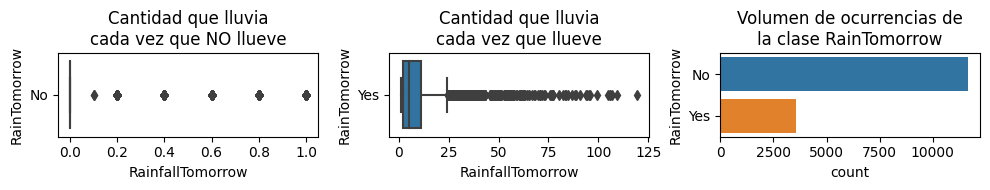

count      mean        std  min  25%  50%   75%    max
RainTomorrow                                                          
No            11643.0  0.073916   0.198571  0.0  0.0  0.0   0.0    1.0
Yes            3556.0  9.599663  12.787249  1.2  2.4  5.0  11.2  119.4

In [193]:
plot_y(df)

In [221]:
ori_df_bal=df.groupby(["Month","RainTomorrow"])["RainfallTomorrow"].count().unstack()
ori_df_bal

RainTomorrow    No  Yes
Month                  
1             1101  251
2              852  258
3             1056  314
4              859  321
5             1139  262
6              949  366
7              962  310
8              982  290
9              948  288
10             964  310
11             931  325
12             900  261

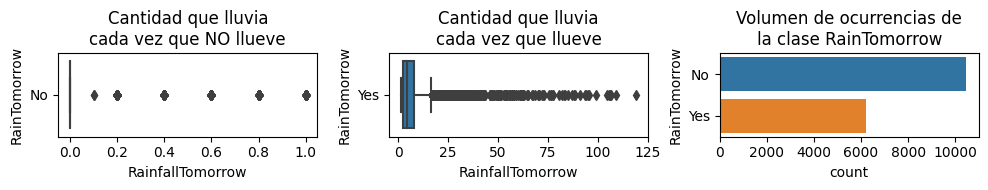

count      mean        std  min  25%  50%  75%    max
RainTomorrow                                                         
No            10479.0  0.074587   0.198852  0.0  0.0  0.0  0.0    1.0
Yes            6218.0  7.304793  10.174951  1.2  2.2  4.2  8.0  119.4

In [219]:
# criterio para establecer un peso al momento de seleccionar elementos.
a=(3*df[df["RainTomorrow"]=="Yes"].groupby("Month")["Date"].count().div(
    df[(df["RainTomorrow"]=="No")].groupby("Month")["Date"].count()))
ratio=a/a.max()
df_undersampled=pd.concat([df[(df["RainTomorrow"]=="No")].sample(
                      frac=0.9,
                      weights=df[(df["RainTomorrow"]=="No")]["Month"].apply(lambda m: ratio[m])
                  ),df[df["RainTomorrow"]=="Yes"],
                    df[(df["RainTomorrow"]=="Yes")&((df["RainfallTomorrow"]<df[df["RainTomorrow"]=="Yes"]["RainfallTomorrow"].quantile(0.75)))]
                           ]).reset_index(drop=True)
plot_y(df_undersampled)

In [222]:
df_undersampled.groupby(["Month","RainTomorrow"])["RainfallTomorrow"].count().unstack().compare(ori_df_bal)

RainTomorrow   No        Yes      
             self other self other
Month                             
1             925  1101  429   251
2             772   852  428   258
3             964  1056  528   314
4             810   859  556   321
5             932  1139  460   262
6             897   949  639   366
7             890   962  574   310
8             870   982  527   290
9             864   948  516   288
10            886   964  565   310
11            882   931  549   325
12            787   900  447   261

### Modelos
Ejecutaremos un conjunto de modelos de regresiones lineales a fin de comparar para un mismo conjunto de datos las diferentes métricas y las contribuciones de las variables explicativas.

In [223]:
model_pipes=lambda scaler: [
  make_pipeline(scaler(),LassoCV(alphas=np.linspace(0.001, 1,50))),
  make_pipeline(scaler(),RidgeCV(np.linspace(0.001, 1,50))),
  make_pipeline(scaler(),ElasticNetCV(
    l1_ratio=np.linspace(0.001, 1,50),
    alphas=np.logspace(-10, 10, 200),)),
  make_pipeline(LinearRegression()),
  make_pipeline(scaler(),SGDRegressor())
]

╒══════════════════╤══════════╤═════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │      EVS │   MAX ERROR │     MAE │     MSE │    RMSE │      R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪══════════╪═════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │ 0.216892 │     79.795  │ 2.90949 │ 36.7729 │ 6.06406 │ 0.216891 │ 1.64111 │ 4.81711e+15 │    0.0213878 │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │ 0.214877 │     79.8108 │ 2.96456 │ 36.8675 │ 6.07186 │ 0.214875 │ 1.69896 │ 4.99299e+15 │    1         │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ ElasticNetCV     │ 0.2168

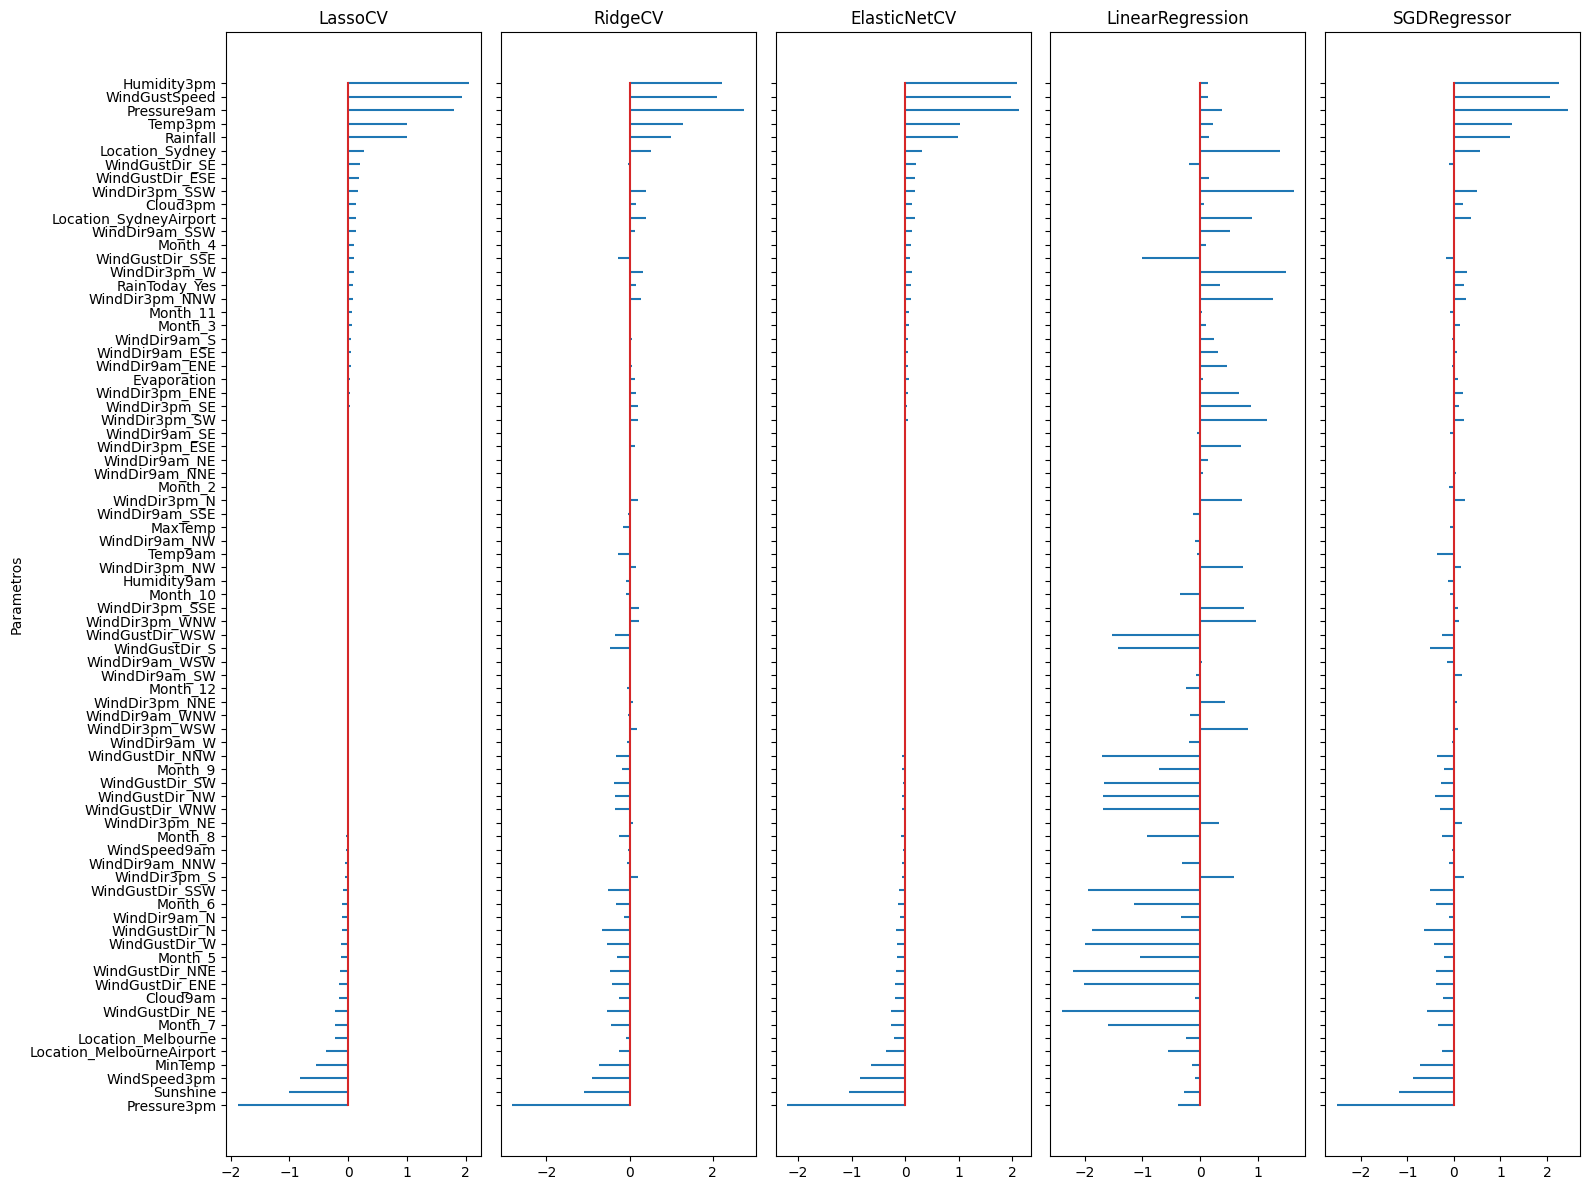

In [224]:
# df
# columnas: TODAS
# Scaler: Standard
_=evaluate_models(df,model_pipes(StandardScaler),plot_errors=False, plot_models=True)

╒══════════════════╤═══════════╤═════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │       EVS │   MAX ERROR │     MAE │     MSE │    RMSE │      R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪═══════════╪═════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │ 0.212335  │     79.2992 │ 2.89923 │ 36.9868 │ 6.08168 │ 0.212335 │ 1.65813 │ 4.78659e+15 │    0.0213878 │            │
├──────────────────┼───────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │ 0.215074  │     79.8019 │ 2.96241 │ 36.8583 │ 6.0711  │ 0.215072 │ 1.69491 │ 4.9852e+15  │    1         │            │
├──────────────────┼───────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ ElasticNetCV     │

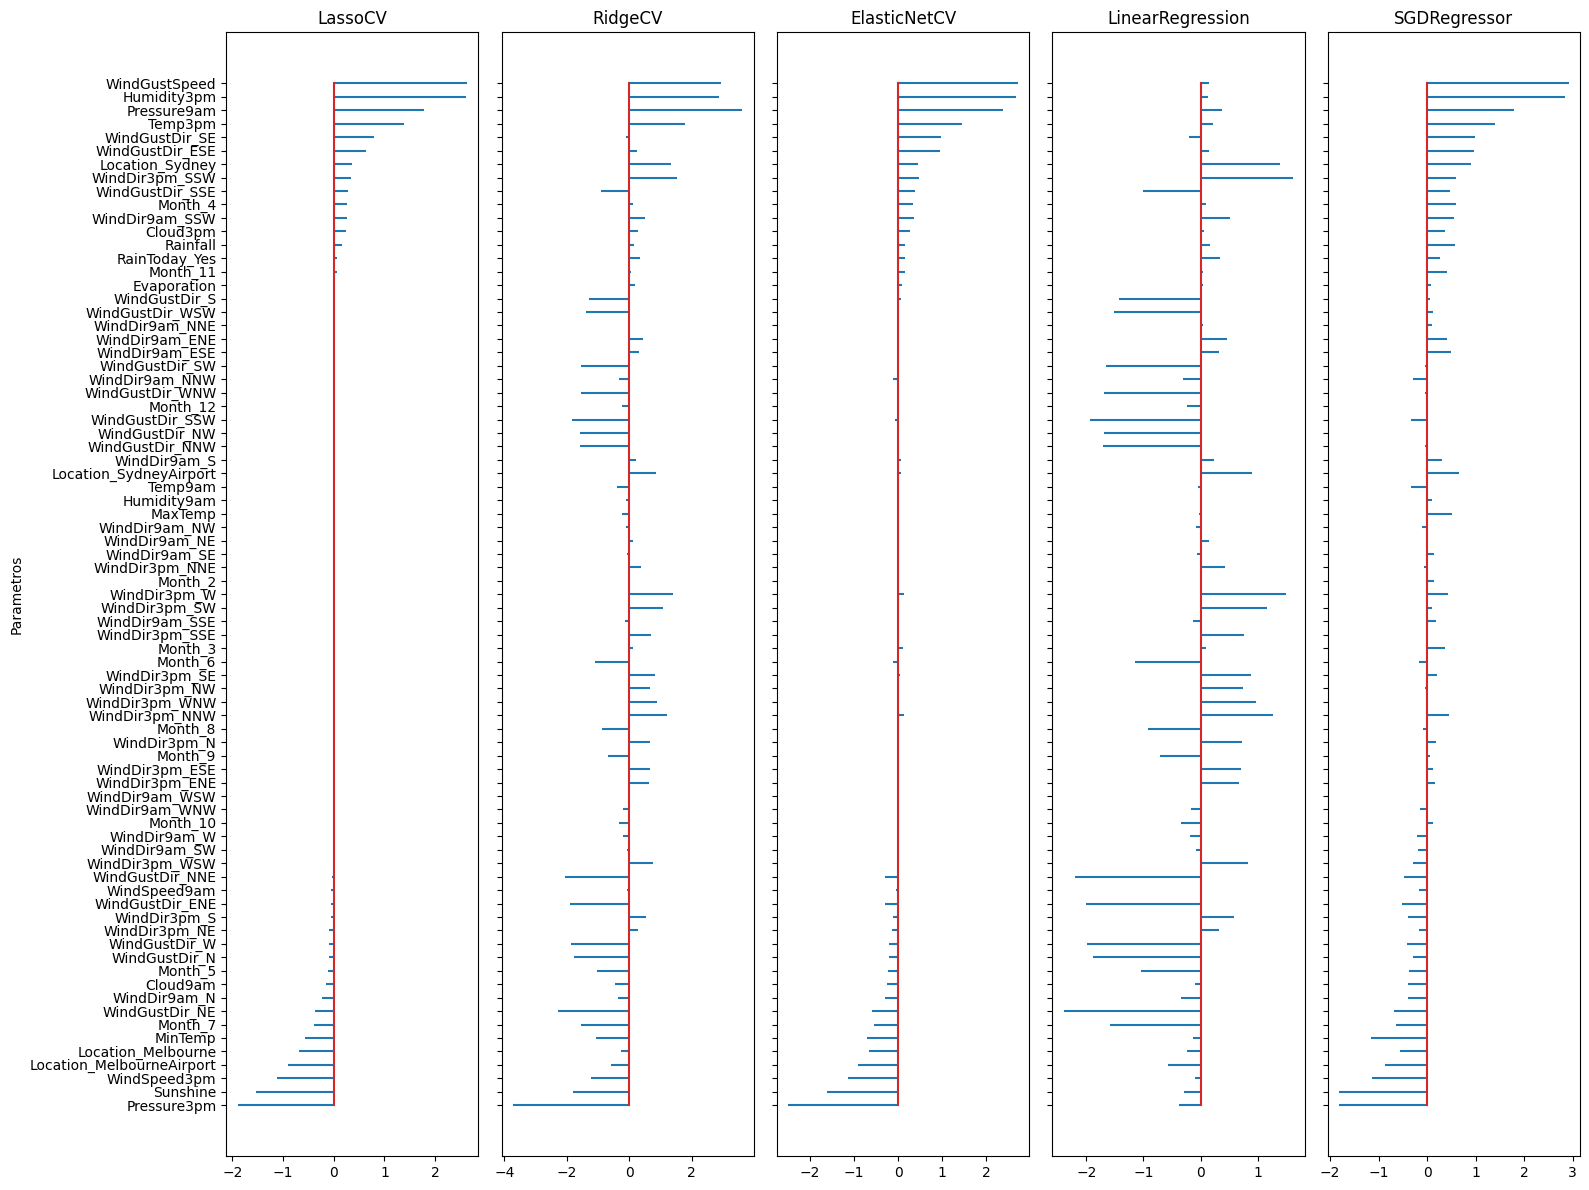

In [225]:
# df
# columnas: TODAS
# Scaler: Robust
_=evaluate_models(df,model_pipes(RobustScaler),plot_errors=False, plot_models=True)

In [226]:
# df under-sampled
# columnas: TODAS
# Scaler: Standard
_=evaluate_models(df_undersampled,model_pipes(StandardScaler),plot_errors=False,plot_models=False)

╒══════════════════╤══════════╤═════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │      EVS │   MAX ERROR │     MAE │     MSE │    RMSE │      R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪══════════╪═════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │ 0.190888 │     83.1866 │ 2.91518 │ 33.9421 │ 5.82599 │ 0.189763 │ 1.82536 │ 4.02333e+15 │    0.0213878 │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │ 0.187325 │     83.1979 │ 2.97605 │ 34.0928 │ 5.8389  │ 0.186166 │ 1.87925 │ 4.16783e+15 │    1         │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ ElasticNetCV     │ 0.1898

In [227]:
# df unser-sampled
# columnas: TODAS
# Scaler: Robust
_=evaluate_models(df_undersampled,model_pipes(RobustScaler),plot_errors=False,plot_models=False)

╒══════════════════╤══════════╤═════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │      EVS │   MAX ERROR │     MAE │     MSE │    RMSE │      R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪══════════╪═════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │ 0.187865 │     83.1693 │ 2.96445 │ 34.0707 │ 5.83701 │ 0.186694 │ 1.85443 │ 4.13193e+15 │   0.001      │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │ 0.18737  │     83.1972 │ 2.97449 │ 34.0909 │ 5.83874 │ 0.18621  │ 1.87364 │ 4.1629e+15  │   1          │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ ElasticNetCV     │ 0.1931

╒══════════════════╤══════════╤═════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │      EVS │   MAX ERROR │     MAE │     MSE │    RMSE │      R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪══════════╪═════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │ 0.236841 │     76.8351 │ 3.14302 │ 37.3428 │ 6.11087 │ 0.236249 │ 1.88666 │ 5.55974e+15 │   0.001      │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │ 0.23685  │     76.8357 │ 3.14387 │ 37.3424 │ 6.11084 │ 0.236257 │ 1.88431 │ 5.56286e+15 │   1          │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ ElasticNetCV     │ 0.2368

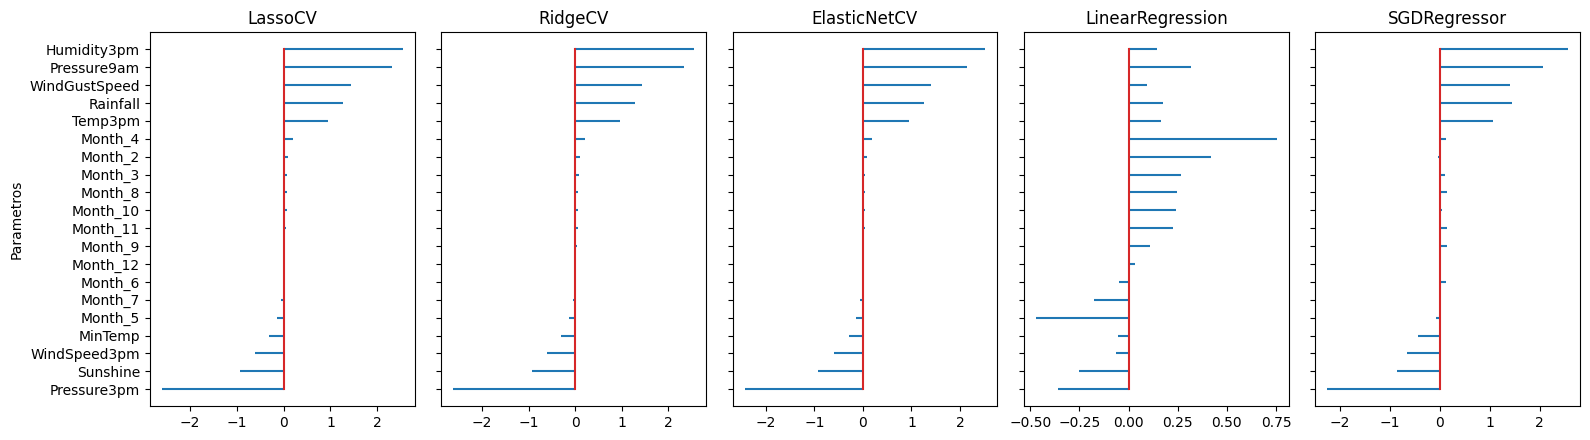

In [230]:
# df
# columnas: 'Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm','Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm','Month'
# Scaler: Standard
_=evaluate_models(
    df,model_pipes=model_pipes(StandardScaler),plot_errors=False,plot_models=True,
    cols=['Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm',
          'Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm',
          'Month']+['Date']+y_target_name)

╒══════════════════╤═══════════╤═════════════╤═════════╤══════════╤══════════╤═══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │       EVS │   MAX ERROR │     MAE │      MSE │     RMSE │       R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪═══════════╪═════════════╪═════════╪══════════╪══════════╪═══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │  0.236855 │     76.8435 │ 3.14226 │  37.342  │  6.11081 │  0.236265 │ 1.88458 │ 5.55697e+15 │   0.001      │            │
├──────────────────┼───────────┼─────────────┼─────────┼──────────┼──────────┼───────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │  0.236859 │     76.8356 │ 3.14367 │  37.342  │  6.11081 │  0.236266 │ 1.88324 │ 5.56217e+15 │   1          │            │
├──────────────────┼───────────┼─────────────┼─────────┼──────────┼──────────┼───────────┼─────────┼─────────────┼──────────────┼────────────┤

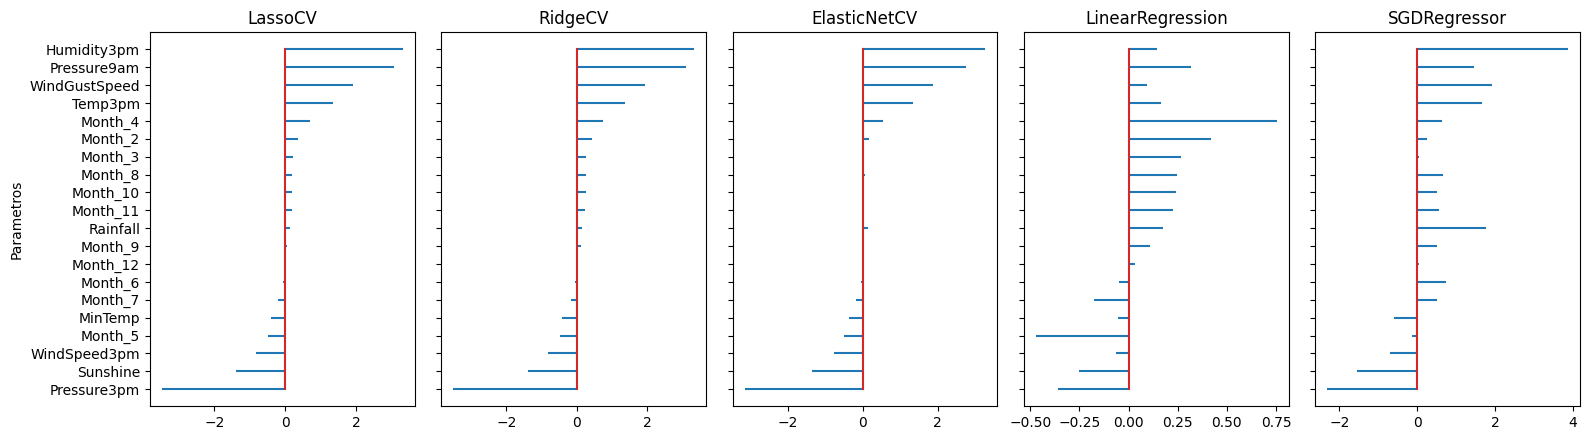

In [231]:
# df
# columnas: 'Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm','Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm','Month'
# Scaler: Robust
_=evaluate_models(
    df,model_pipes=model_pipes(RobustScaler),plot_errors=False,plot_models=True,
    cols=['Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm',
          'Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm',
          'Month']+['Date']+y_target_name)

In [232]:
_=evaluate_models(
    df,model_pipes=model_pipes(RobustScaler),plot_errors=False,plot_models=False,
    cols=['Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm',
          'Rainfall','Temp3pm', 'MinTemp','Sunshine',"Location"]+['Date']+y_target_name)

╒══════════════════╤══════════╤═════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │      EVS │   MAX ERROR │     MAE │     MSE │    RMSE │      R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪══════════╪═════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │ 0.238194 │     94.5747 │ 3.14554 │ 48.4111 │ 6.95781 │ 0.237897 │ 1.73825 │ 5.22034e+15 │   0.001      │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │ 0.238248 │     94.5696 │ 3.14766 │ 48.4076 │ 6.95756 │ 0.237951 │ 1.74829 │ 5.22883e+15 │   1          │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ ElasticNetCV     │ 0.2381

╒══════════════════╤══════════╤═════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │      EVS │   MAX ERROR │     MAE │     MSE │    RMSE │      R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪══════════╪═════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │ 0.239368 │     76.8449 │ 3.11452 │ 37.1902 │ 6.09838 │ 0.239147 │ 1.81735 │ 5.34447e+15 │  0.001       │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │ 0.239358 │     76.8488 │ 3.11554 │ 37.1908 │ 6.09842 │ 0.239137 │ 1.82056 │ 5.34809e+15 │  1           │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ ElasticNetCV     │ 0.2394

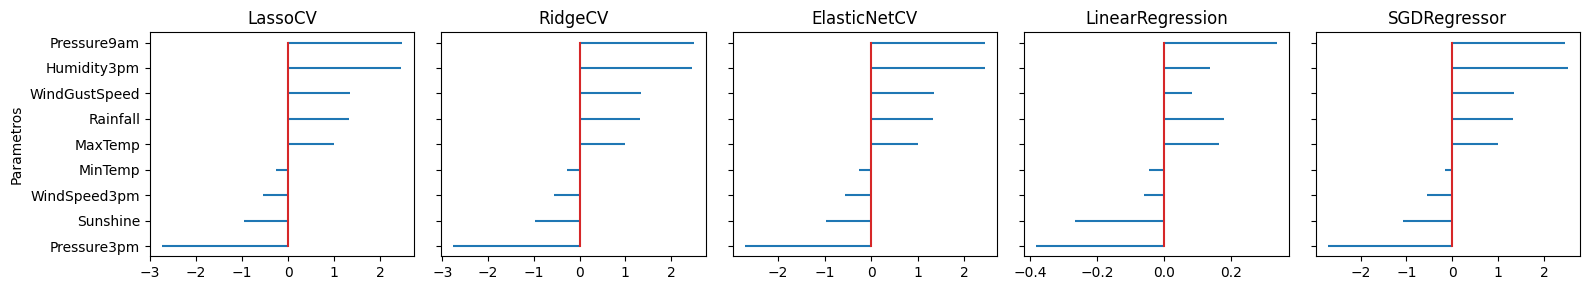

In [234]:
# df
# columnas: 'Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm','Rainfall','MaxTemp', 'MinTemp','Sunshine','WindSpeed3pm'
# Scaler: Standard
_=evaluate_models(
    df,model_pipes=model_pipes(StandardScaler),plot_errors=False,plot_models=True,
    cols=['Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm',
          'Rainfall','MaxTemp', 'MinTemp','Sunshine','WindSpeed3pm']+['Date']+y_target_name)

╒══════════════════╤══════════╤═════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │      EVS │   MAX ERROR │     MAE │     MSE │    RMSE │      R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪══════════╪═════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │ 0.246232 │     76.6722 │ 3.16133 │ 36.8862 │ 6.0734  │ 0.245588 │ 1.89188 │ 5.71732e+15 │   0.001      │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │ 0.246135 │     76.6758 │ 3.16283 │ 36.8909 │ 6.07379 │ 0.245492 │ 1.89506 │ 5.72253e+15 │   1          │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ ElasticNetCV     │ 0.2465

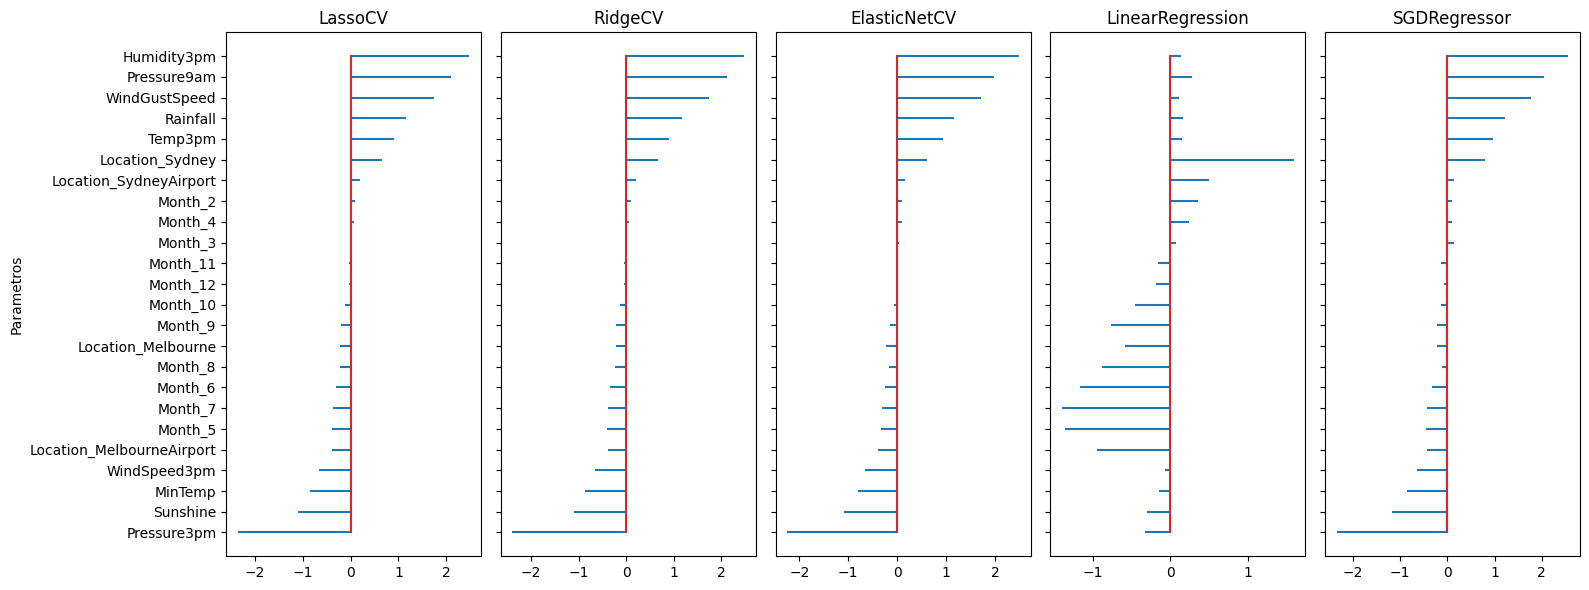

In [235]:
# df
# columnas: 'Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm','Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm','Month',"location"
# Scaler: Standard
_=evaluate_models(
    df,model_pipes=model_pipes(StandardScaler),plot_errors=False,plot_models=True,
    cols=['Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm',
          'Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm',
          'Month','Location']+['Date']+y_target_name)

╒══════════════════╤═══════════╤═════════════╤═════════╤══════════╤══════════╤═══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │       EVS │   MAX ERROR │     MAE │      MSE │     RMSE │       R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪═══════════╪═════════════╪═════════╪══════════╪══════════╪═══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │  0.217788 │     86.5406 │ 3.03958 │  31.1101 │  5.57764 │  0.217691 │ 1.81622 │ 5.51335e+15 │   0.001      │            │
├──────────────────┼───────────┼─────────────┼─────────┼──────────┼──────────┼───────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │  0.217541 │     86.4817 │ 3.04476 │  31.1196 │  5.5785  │  0.217451 │ 1.82296 │ 5.53447e+15 │   1          │            │
├──────────────────┼───────────┼─────────────┼─────────┼──────────┼──────────┼───────────┼─────────┼─────────────┼──────────────┼────────────┤

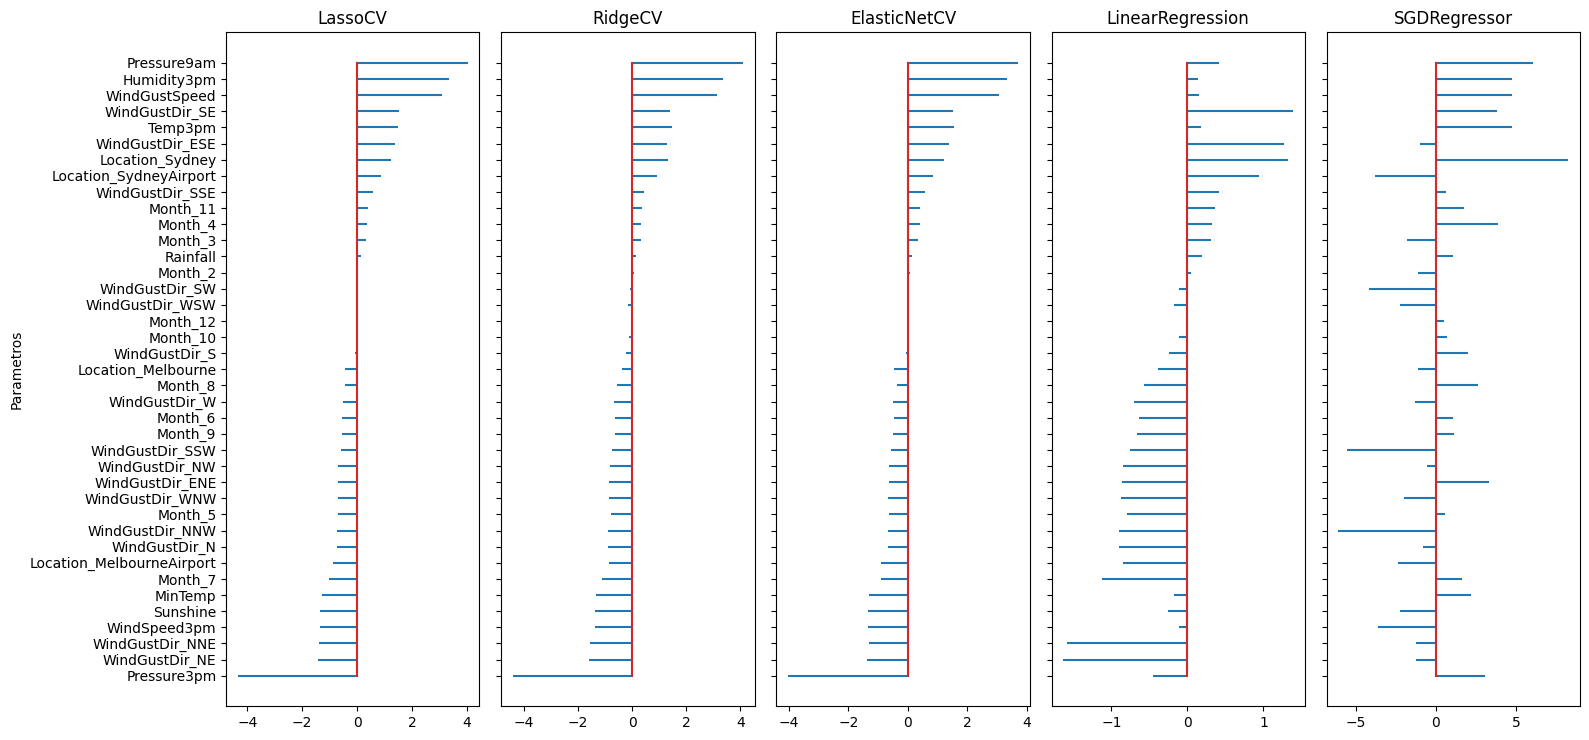

In [240]:
# df
# columnas: 'Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm','Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm','Month',"location"
# Scaler: Robust
_=evaluate_models(
    df,model_pipes=model_pipes(RobustScaler),plot_errors=False,plot_models=True,
    cols=['Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm',
          'Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm',
          'Month','Location','WindGustDir']+['Date']+y_target_name)

╒══════════════════╤══════════╤═════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │      EVS │   MAX ERROR │     MAE │     MSE │    RMSE │      R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪══════════╪═════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │ 0.245745 │     76.7298 │ 3.16226 │ 36.9096 │ 6.07533 │ 0.245109 │ 1.90414 │ 5.70912e+15 │   0.001      │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │ 0.245362 │     76.7397 │ 3.1655  │ 36.9282 │ 6.07686 │ 0.244728 │ 1.89877 │ 5.71901e+15 │   1          │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ ElasticNetCV     │ 0.2459

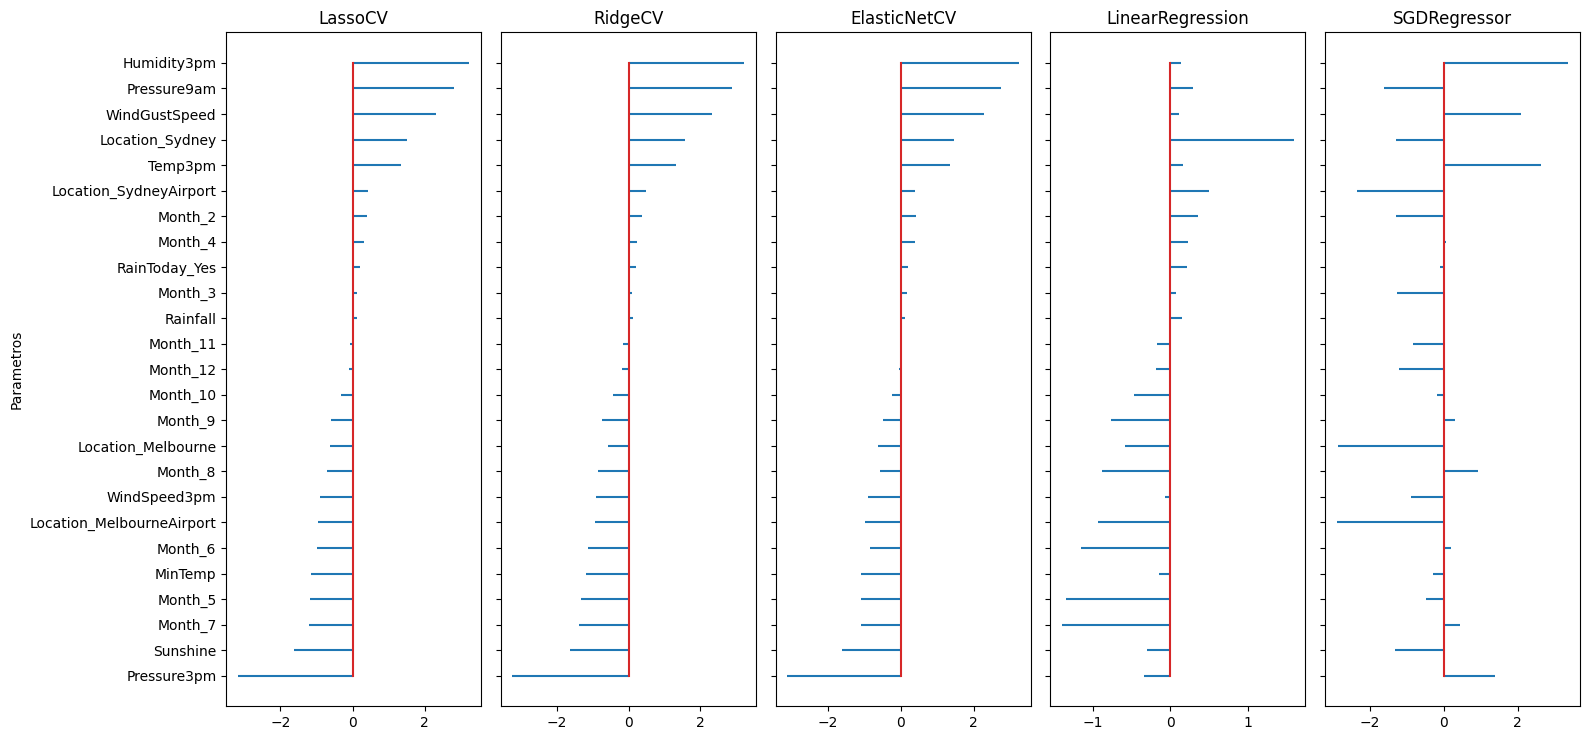

In [241]:
# df
# columnas: 'Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm','Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm','Month',"location"
# Scaler: Robust
_=evaluate_models(
    df,model_pipes=model_pipes(RobustScaler),plot_errors=False,plot_models=True,
    cols=['Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm',
          'Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm',
          'Month','Location','RainToday']+['Date']+y_target_name)

╒══════════════════╤═══════════╤═════════════╤═════════╤═════════╤═════════╤═══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │       EVS │   MAX ERROR │     MAE │     MSE │    RMSE │       R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪═══════════╪═════════════╪═════════╪═════════╪═════════╪═══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │  0.217292 │     86.6364 │ 3.03623 │ 31.1298 │ 5.57941 │  0.217196 │ 1.81418 │ 5.50348e+15 │   0.001      │            │
├──────────────────┼───────────┼─────────────┼─────────┼─────────┼─────────┼───────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │  0.217022 │     86.5801 │ 3.04122 │ 31.1402 │ 5.58034 │  0.216933 │ 1.82082 │ 5.52382e+15 │   1          │            │
├──────────────────┼───────────┼─────────────┼─────────┼─────────┼─────────┼───────────┼─────────┼─────────────┼──────────────┼────────────┤
│ ElasticNetC

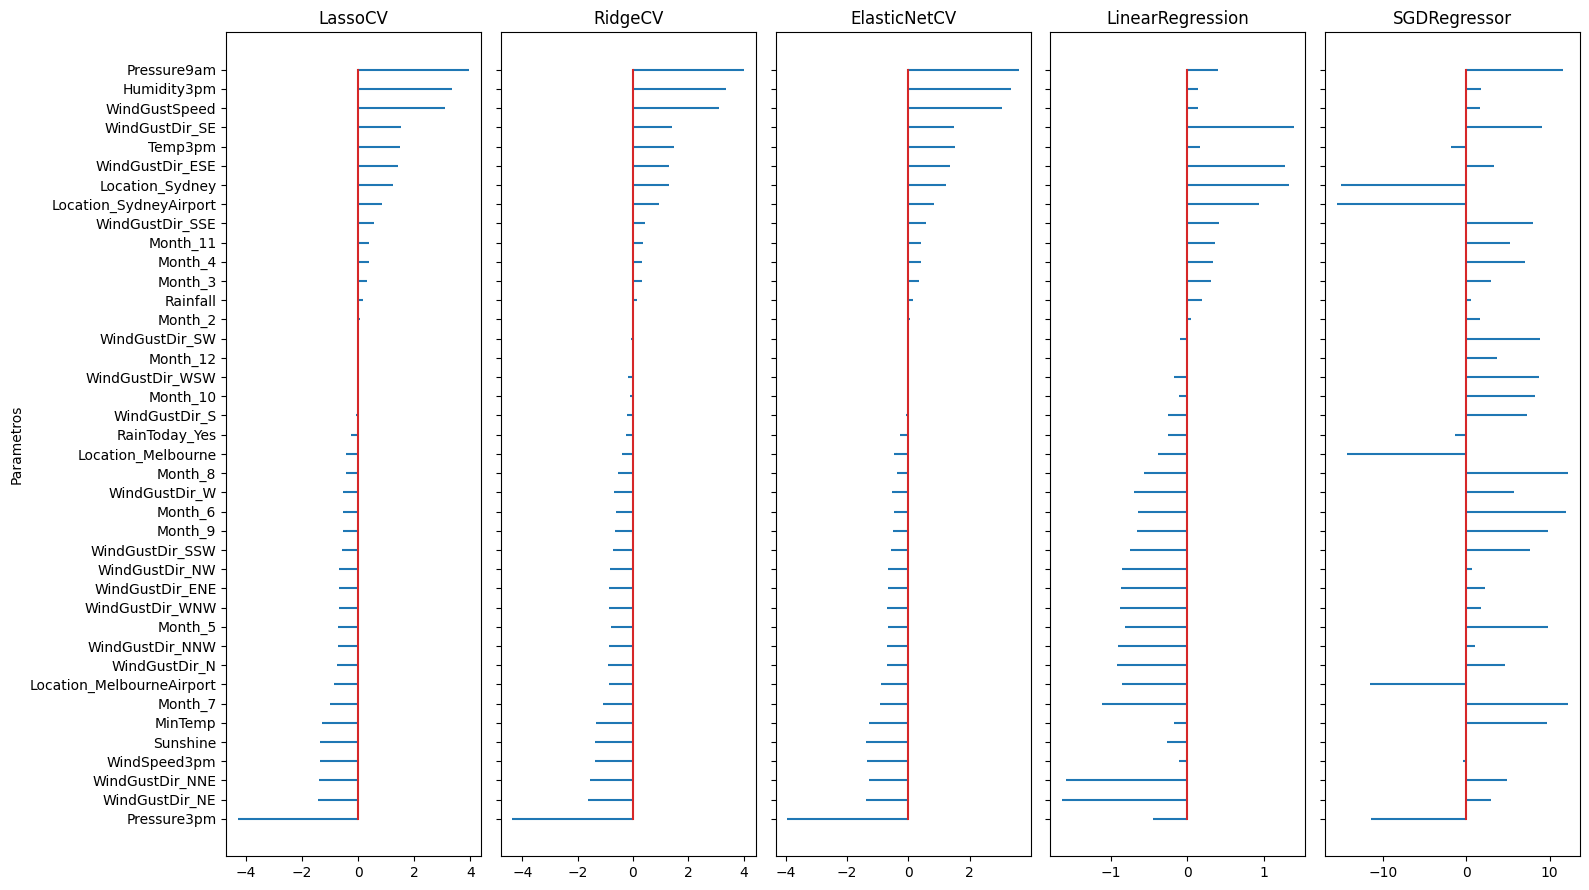

In [242]:
# df
# columnas: 'Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm','Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm','Month',"location"
# Scaler: Robust
_=evaluate_models(
    df,model_pipes=model_pipes(RobustScaler),plot_errors=False,plot_models=True,
    cols=['Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm',
          'Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm',
          'Month','Location','RainToday','WindGustDir']+['Date']+y_target_name)

### Modelo Seleccionado
Razón de su elección:
- Metodo Lasso
- $R^2$: 0.24
- MSE: 36.886

Se incluyun los diferentes graficos de residuos. En color se han separado aquellas muestras en las que SI ha llovido (rojo) y aquellas en las que NO ha llovido.

╒══════════════════╤══════════╤═════════════╤═════════╤═════════╤═════════╤══════════╤═════════╤═════════════╤══════════════╤════════════╕
│ Model Name       │      EVS │   MAX ERROR │     MAE │     MSE │    RMSE │      R^2 │    MeAE │        MAPE │   Best Alpha │   L1 ratio │
╞══════════════════╪══════════╪═════════════╪═════════╪═════════╪═════════╪══════════╪═════════╪═════════════╪══════════════╪════════════╡
│ LassoCV          │ 0.246232 │     76.6722 │ 3.16133 │ 36.8862 │ 6.0734  │ 0.245588 │ 1.89188 │ 5.71732e+15 │   0.001      │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ RidgeCV          │ 0.246135 │     76.6758 │ 3.16283 │ 36.8909 │ 6.07379 │ 0.245492 │ 1.89506 │ 5.72253e+15 │   1          │            │
├──────────────────┼──────────┼─────────────┼─────────┼─────────┼─────────┼──────────┼─────────┼─────────────┼──────────────┼────────────┤
│ ElasticNetCV     │ 0.2465

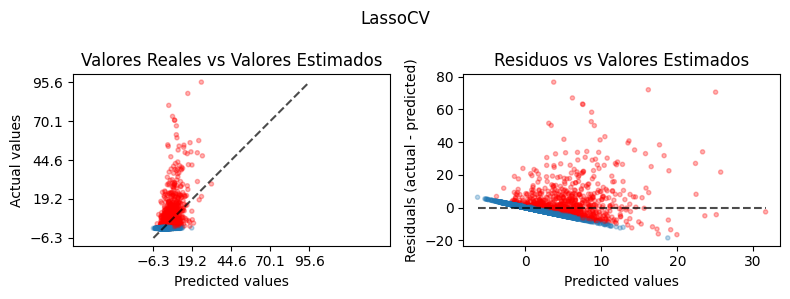

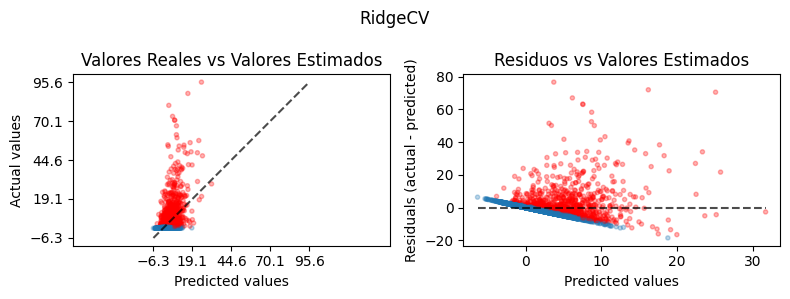

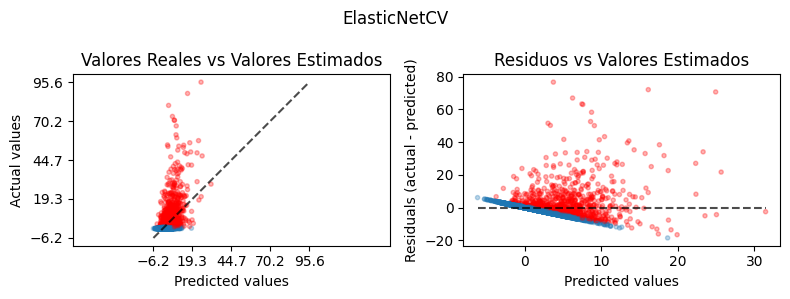

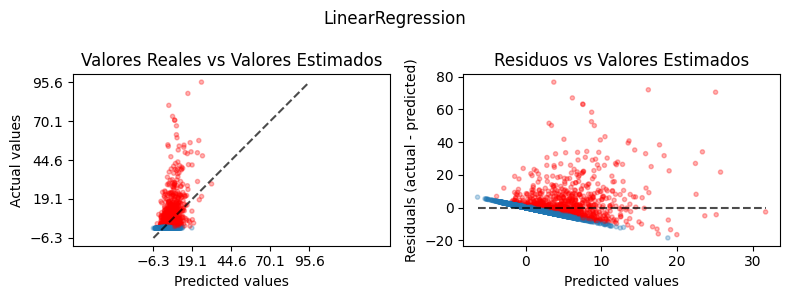

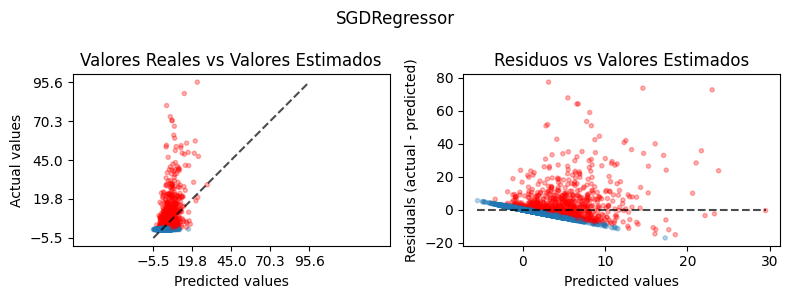

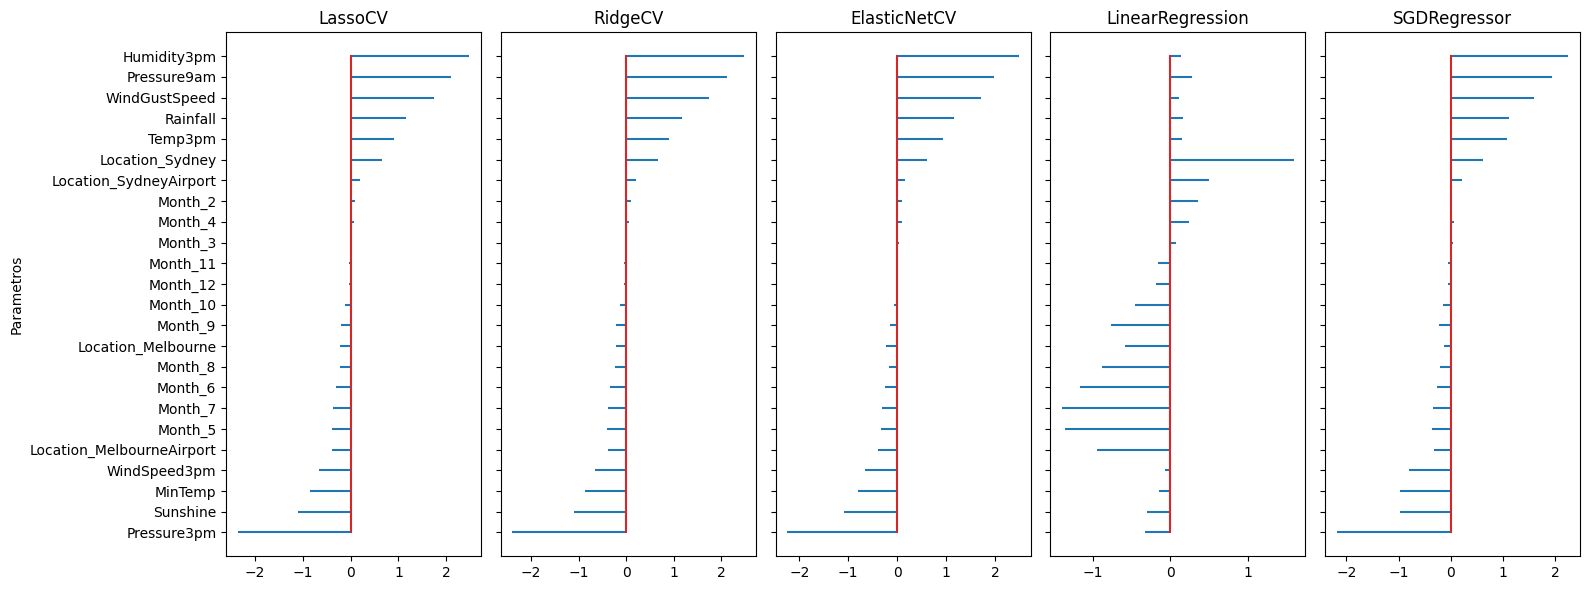

In [243]:
_=evaluate_models(
    df,model_pipes=model_pipes(StandardScaler),plot_errors=True,plot_models=True,
    cols=['Humidity3pm','WindGustSpeed', 'Pressure9am', 'Pressure3pm',
          'Rainfall','Temp3pm', 'MinTemp','Sunshine','WindSpeed3pm',
          'Month','Location']+['Date']+y_target_name)